In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="7"
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
import random
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
from sklearn.model_selection import KFold

#then import my own modules
# from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight
from timeit import default_timer as timer
from AttentiveFP.featurizing import graph_dict
from AttentiveFP.AttentiveLayers_new2 import Fingerprint, graph_dataset, null_collate, Graph, Logger, time_to_str



In [2]:
cuda_aviable = torch.cuda.is_available()
device = torch.device(0)

SEED = 28
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic=True


In [3]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set_style("darkgrid")
from IPython.display import SVG, display
import sascorer
import itertools
from sklearn.metrics import r2_score
import scipy

number of all smiles:  133885
number of successfully processed smiles:  133247


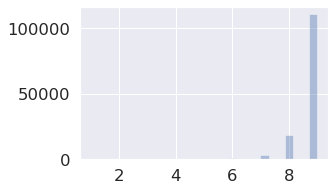

In [4]:
task_name = 'qm9'
tasks = [
   "mu","alpha","homo","lumo","gap","r2","zpve","u0","u298","h298","g298","cv"
]

raw_filename = "../data/gdb9_smiles.csv"
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)

smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ", len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
#         print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))

smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)].reset_index()
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
plt.show()
plt.close()


In [5]:
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 500
epochs = 300

p_dropout= 0.5
fingerprint_dim = 200

weight_decay = 4.9 # also known as l2_regularization_lambda
learning_rate = 3.4
K = 3
T = 2
per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num


In [6]:
test_df = smiles_tasks_df.sample(frac=1/10, random_state=SEED) # test set
training_data = smiles_tasks_df.drop(test_df.index) # training data

# get the stats of the seen dataset (the training data)
# which will be used to noramlize the dataset. 
columns = ['Task','Mean','Standard deviation', 'Mean absolute deviation','ratio']
mean_list=[]
std_list=[]
mad_list=[]
ratio_list=[]
training_label_list = []
test_label_list = []
for task in tasks:
    mean = training_data[task].mean()
    mean_list.append(mean)
    std = training_data[task].std()
    std_list.append(std)
    mad = training_data[task].mad()
    mad_list.append(mad)
    ratio_list.append(std/mad)
    training_data[task+'_normalized'] = (training_data[task]- mean)/std
    # the mean and standard deviation of training data is also used in test set
    test_df[task+'_normalized'] = (test_df[task]- mean)/std
    training_label_list.append(training_data[task+'_normalized'].values)
    test_label_list.append(test_df[task+'_normalized'].values)

training_label = np.array(training_label_list).astype(np.float).transpose()
test_label = np.array(test_label_list).astype(np.float).transpose()

    
# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=SEED) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

while (len(train_df) % batch_size) / batch_size <0.8:
    batch_size +=1
print("batch size: ", batch_size)

list_of_tuples = list(zip(tasks, mean_list, std_list, mad_list, ratio_list))
stats  = pd.DataFrame(list_of_tuples, columns = columns)
stats


batch size:  503


,Task,Mean,Standard deviation,Mean absolute deviation,ratio
0,mu,2.708713,1.531956,1.191056,1.286217
1,alpha,75.190920,8.197607,6.308065,1.299544
2,homo,-0.239974,0.022176,0.016340,1.357178
3,lumo,0.011026,0.046912,0.038618,1.214779
4,gap,0.250999,0.047505,0.039648,1.198148
5,r2,1190.034973,279.648930,202.109506,1.383651
6,zpve,0.148522,0.033298,0.026472,1.257836
7,u0,-411.587569,40.087880,31.106651,1.288724
8,u298,-411.579095,40.087661,31.106518,1.288722
9,h298,-411.578151,40.087661,31.106518,1.288722


In [7]:
# # check the value distribution of different tasks
# plt.figure(figsize=(28, 8),dpi=300)
# gs = gridspec.GridSpec(2, 6)
# sns.set(font_scale=1.8)
# for i, task in enumerate(tasks):
#     plt.subplot(gs[(i)])
#     x = pd.Series(training_data[task].values, name=task)
#     ax = sns.distplot(x, bins=28, kde=False)
#     plt.tight_layout()
# plt.show()
# plt.close()

In [8]:
# # check the distribution after normalization (should be the same)

# plt.figure(figsize=(28, 8),dpi=300)
# gs = gridspec.GridSpec(2, 6)
# sns.set(font_scale=1.8)
# for i, task in enumerate(tasks):
#     plt.subplot(gs[(i)])
#     x = pd.Series(training_data[task+"_normalized"].values, name=task)
#     ax = sns.distplot(x, bins=28, kde=False)
#     plt.tight_layout()
# plt.show()
# plt.close()

In [9]:
training_smiles = training_data['smiles'].values
test_smiles = test_df['smiles'].values
training_graph_dict = graph_dict(training_smiles, list(training_label), filename+'_training_seed'+str(SEED))
test_graph_dict = graph_dict(test_smiles, list(test_label), filename+'_test_seed'+str(SEED))
whole_graph_dict = {**training_graph_dict, **test_graph_dict}

graph dicts loaded from ../data/gdb9_smiles_training_seed28.pkl
graph dicts loaded from ../data/gdb9_smiles_test_seed28.pkl


In [10]:
ratio_array = torch.from_numpy(np.array(ratio_list).astype(np.float)).float()
ratio_array = ratio_array.to(device)
std_array = torch.from_numpy(np.array(std_list).astype(np.float)).float()
std_array = ratio_array.to(device)

ratio_array_square = ratio_array[None,:]**2
loss_function = nn.MSELoss()
model = Fingerprint(output_units_num, fingerprint_dim, K=K, T=T, p_dropout=p_dropout)
model.to(device)
# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in  model.parameters()])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

1822098
preprocess.0.linear.weight torch.Size([200, 39])
preprocess.0.linear.bias torch.Size([200])
preprocess.0.bn.weight torch.Size([200])
preprocess.0.bn.bias torch.Size([200])
encoder.0.linear.weight torch.Size([200, 49])
encoder.0.linear.bias torch.Size([200])
encoder.0.bn.weight torch.Size([200])
encoder.0.bn.bias torch.Size([200])
align.weight torch.Size([1, 400])
align.bias torch.Size([1])
attend.linear.weight torch.Size([200, 200])
attend.linear.bias torch.Size([200])
attend.bn.weight torch.Size([200])
attend.bn.bias torch.Size([200])
gru.weight_ih torch.Size([600, 200])
gru.weight_hh torch.Size([600, 200])
gru.bias_ih torch.Size([600])
gru.bias_hh torch.Size([600])
propagate.0.align.weight torch.Size([1, 400])
propagate.0.align.bias torch.Size([1])
propagate.0.attend.linear.weight torch.Size([200, 200])
propagate.0.attend.linear.bias torch.Size([200])
propagate.0.attend.bn.weight torch.Size([200])
propagate.0.attend.bn.bias torch.Size([200])
propagate.0.gru.weight_ih torch.Si

In [11]:
def train(model, smiles_list):
    model.train()
    train_loader = DataLoader(graph_dataset(smiles_list, whole_graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=True, worker_init_fn=np.random.seed(SEED))
    losses = []
    for b, (smiles, atom, bond, bond_index, mol_index, label) in tqdm(enumerate(train_loader)):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device) * ratio_array_square # set STD/MAD ratio as the weights
        mol_prediction = model(atom, bond, bond_index, mol_index) * ratio_array_square
        
        loss = loss_function(mol_prediction.reshape(-1), label.reshape(-1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

    return np.mean(losses)

def eval(model, smiles_list):
    model.eval()
    MAE_array = np.array([])
    MSE_array = np.array([])
    mol_prediction_array = np.array([])
    label_array = np.array([])
        
    eval_loader = DataLoader(graph_dataset(smiles_list, whole_graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=False, worker_init_fn=np.random.seed(SEED))
    for b, (smiles, atom, bond, bond_index, mol_index, label) in tqdm(enumerate(eval_loader)):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device)
        
        mol_prediction = model(atom, bond, bond_index, mol_index)
        MAE = F.l1_loss(mol_prediction.reshape(-1), label.reshape(-1), reduction='none').cpu().detach().numpy()      
        MSE = F.mse_loss(mol_prediction.reshape(-1), label.reshape(-1), reduction='none').cpu().detach().numpy()
        
#         mol_prediction_array = np.concatenate([mol_prediction_array, mol_prediction.cpu().detach().numpy()])
#         label = label.reshape(-1,12).cpu().detach().numpy()
#         label_array = np.concatenate([label_array.reshape(-1,12),label])
#         print(label_array.shape)
        MAE_array = np.concatenate([MAE_array.reshape(-1,12),MAE.reshape(-1,12)])
        MSE_array = np.concatenate([MSE_array.reshape(-1,12),MSE.reshape(-1,12)])
#     mol_prediction_array = mol_prediction_array.data.squeeze().cpu().numpy()
#     label_array = label_array.data.squeeze().cpu().numpy()    
#     r2_score_list = [r2_score(mol_prediction_array[:,i], label_array[:,i]) for i, task in enumerate(tasks)]
    MAE_normalized = MAE_array.mean(0).reshape(-1)    
    MAE_raw = MAE_normalized * np.array(std_list)
    RMSE_normalized = np.sqrt(MSE_array.mean(0).reshape(-1))
    RMSE_raw = RMSE_normalized * np.array(std_list)

    return MAE_normalized, MAE_raw, RMSE_normalized, RMSE_raw #, r2_score_list


In [12]:
best_param ={}
best_param["train_epoch"] = 0
best_param["valid_epoch"] = 0
best_param["train_MSE_normalized"] = 800
best_param["valid_MSE_normalized"] = 800
train_df_smiles = train_df.smiles.values
valid_df_smiles = valid_df.smiles.values

for epoch in range(300):
    losses = train(model, train_df_smiles)
    train_MAE_normalized, train_MAE, train_MSE_normalized, train_MSE = eval(model, train_df_smiles)
    valid_MAE_normalized, valid_MAE, valid_MSE_normalized, valid_MSE, = eval(model, valid_df_smiles)
    print("EPOCH:\t"+str(epoch)+' '+str(losses)+'\n'\
#         +"train_MAE_normalized: "+str(train_MAE_normalized)+'\n'\
#         +"valid_MAE_normalized: "+str(valid_MAE_normalized)+'\n'\
        +"train_MAE"+":"+"\n"+str(train_MAE)+'\n'\
        +"valid_MAE"+":"+"\n"+str(valid_MAE)+'\n'\
          
        +"train_MSE_normalized_mean: "+str(train_MSE_normalized.mean())+'\n'\
        +"valid_MSE_normalized_mean: "+str(valid_MSE_normalized.mean())+'\n'\
#         +"train_MSE_normalized: "+str(train_MSE_normalized)+'\n'\
#         +"valid_MSE_normalized: "+str(valid_MSE_normalized)+'\n'\
        )
    if train_MSE_normalized.mean() < best_param["train_MSE_normalized"]:
        best_param["train_epoch"] = epoch
        best_param["train_MSE_normalized"] = train_MSE_normalized.mean()
    if valid_MSE_normalized.mean() < best_param["valid_MSE_normalized"]:
        best_param["valid_epoch"] = epoch
        best_param["valid_MSE_normalized"] = valid_MSE_normalized.mean()
        if valid_MSE_normalized.mean() < 0.06:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
#     if (epoch - best_param["train_epoch"] >10) and (epoch - best_param["valid_epoch"] >18):        
#         break
    


212it [00:20, 13.63it/s]
212it [00:07, 30.14it/s]
27it [00:01, 19.04it/s]

EPOCH:	0 0.6586505871898723
train_MAE:
[7.79037676e-01 1.00437655e+00 8.56077298e-03 1.22587849e-02
 1.51919160e-02 6.62493896e+01 3.86387041e-03 7.60922349e+00
 7.53954157e+00 6.95718223e+00 7.30623828e+00 4.74392227e-01]
valid_MAE:
[7.69336449e-01 1.00990807e+00 8.50531194e-03 1.22759297e-02
 1.52964915e-02 6.64041785e+01 3.84408088e-03 7.58942727e+00
 7.53593631e+00 6.93566571e+00 7.30583027e+00 4.77444994e-01]
train_MSE_normalized_mean: 0.29702871122083563
valid_MSE_normalized_mean: 0.2934729887021034




212it [00:20, 10.51it/s]
212it [00:07, 27.10it/s]
27it [00:01, 25.24it/s]

EPOCH:	1 0.35015990655377227
train_MAE:
[7.47749626e-01 9.60257113e-01 7.78814462e-03 9.11743637e-03
 1.19069507e-02 5.46970574e+01 2.94552942e-03 2.91830444e+00
 2.67145910e+00 3.07874596e+00 2.94943285e+00 4.58761949e-01]
valid_MAE:
[7.40234981e-01 9.63730014e-01 7.74803424e-03 9.17415646e-03
 1.19794699e-02 5.45703869e+01 2.93891074e-03 2.92782994e+00
 2.68613146e+00 3.09523574e+00 2.96648695e+00 4.60508338e-01]
train_MSE_normalized_mean: 0.23380249542680676
valid_MSE_normalized_mean: 0.23178012144138352




212it [00:19, 14.33it/s]
212it [00:06, 32.70it/s]
27it [00:00, 39.48it/s]


EPOCH:	2 0.3020268020764837
train_MAE:
[7.22576981e-01 1.16394702e+00 7.43063121e-03 9.12426025e-03
 1.12153276e-02 5.56444472e+01 4.51958877e-03 2.03373824e+00
 2.01002997e+00 2.22476776e+00 2.10742312e+00 7.00520509e-01]
valid_MAE:
[7.16120656e-01 1.17810724e+00 7.41799334e-03 9.13506960e-03
 1.12562935e-02 5.57048418e+01 4.53178928e-03 2.03156577e+00
 2.01004054e+00 2.22216390e+00 2.11025421e+00 7.03969233e-01]
train_MSE_normalized_mean: 0.2305097966463733
valid_MSE_normalized_mean: 0.2292802997925364



212it [00:20, 10.42it/s]
212it [00:07, 28.84it/s]
27it [00:01, 21.00it/s]

EPOCH:	3 0.28176372990293325
train_MAE:
[7.00134664e-01 8.02875696e-01 7.07367933e-03 8.36248914e-03
 1.06572424e-02 4.93458753e+01 2.56211776e-03 4.36518247e+00
 4.33872606e+00 4.31316481e+00 4.32170027e+00 4.77408308e-01]
valid_MAE:
[6.93865689e-01 8.02086041e-01 7.05276272e-03 8.43337920e-03
 1.07489532e-02 4.97951914e+01 2.57248813e-03 4.34982448e+00
 4.32131079e+00 4.29607506e+00 4.30715877e+00 4.74212744e-01]
train_MSE_normalized_mean: 0.22965767512543303
valid_MSE_normalized_mean: 0.22798532849970735




212it [00:20, 10.14it/s]
212it [00:09, 22.14it/s]
27it [00:01, 21.67it/s]

EPOCH:	4 0.2695345926397252
train_MAE:
[7.04870185e-01 8.91134435e-01 7.09257926e-03 1.07616938e-02
 1.28220878e-02 4.86609183e+01 2.90484247e-03 4.26345104e+00
 4.19387486e+00 4.38863019e+00 4.39238598e+00 4.37911606e-01]
valid_MAE:
[6.98135500e-01 8.95516903e-01 7.06479799e-03 1.07523818e-02
 1.28618716e-02 4.89112608e+01 2.92022736e-03 4.28255448e+00
 4.21386728e+00 4.40687164e+00 4.40870471e+00 4.40703333e-01]
train_MSE_normalized_mean: 0.23562957857327416
valid_MSE_normalized_mean: 0.2344816093222245




212it [00:20, 13.86it/s]
212it [00:06, 30.51it/s]
27it [00:00, 28.95it/s]

EPOCH:	5 0.2611627663784432
train_MAE:
[6.98156622e-01 1.07386661e+00 7.75292099e-03 8.37629333e-03
 9.91249294e-03 4.70339456e+01 2.62142171e-03 4.96997233e+00
 4.93285203e+00 4.98396632e+00 5.02689128e+00 3.97001649e-01]
valid_MAE:
[6.90983679e-01 1.07623227e+00 7.76216200e-03 8.39498470e-03
 9.96391130e-03 4.72330501e+01 2.64533399e-03 4.95440913e+00
 4.91955407e+00 4.96869909e+00 5.01015287e+00 3.96219385e-01]
train_MSE_normalized_mean: 0.23168863091364947
valid_MSE_normalized_mean: 0.22998137115540387




212it [00:20, 14.17it/s]
212it [00:07, 28.99it/s]
27it [00:01, 22.27it/s]

EPOCH:	6 0.2536217154196973
train_MAE:
[6.78990393e-01 1.12769130e+00 6.59870668e-03 8.60180586e-03
 1.03268924e-02 5.35589128e+01 3.55835473e-03 2.55826395e+00
 2.60055473e+00 2.53369566e+00 2.51600715e+00 5.86875918e-01]
valid_MAE:
[6.74205407e-01 1.13065823e+00 6.62840646e-03 8.62238510e-03
 1.04069759e-02 5.42061616e+01 3.58195044e-03 2.54709969e+00
 2.58922912e+00 2.52303681e+00 2.50601628e+00 5.87887142e-01]
train_MSE_normalized_mean: 0.21708232539328856
valid_MSE_normalized_mean: 0.21646394000920485




212it [00:21, 10.08it/s]
212it [00:10, 19.70it/s]
27it [00:01, 20.63it/s]

EPOCH:	7 0.24626413648420908
train_MAE:
[6.59156019e-01 7.16904809e-01 6.33579504e-03 7.58013903e-03
 9.45182777e-03 4.62320405e+01 2.25240174e-03 1.36603549e+00
 1.36943547e+00 1.36137755e+00 1.35514466e+00 4.23387746e-01]
valid_MAE:
[6.55801369e-01 7.18525260e-01 6.34068163e-03 7.50995378e-03
 9.45562621e-03 4.65099400e+01 2.25564505e-03 1.37135700e+00
 1.37474658e+00 1.36693463e+00 1.36035950e+00 4.23699659e-01]
train_MSE_normalized_mean: 0.18672229234340834
valid_MSE_normalized_mean: 0.1856206559118081




212it [00:19, 10.62it/s]
212it [00:07, 28.45it/s]
27it [00:00, 28.55it/s]

EPOCH:	8 0.24039292110587065
train_MAE:
[6.87201965e-01 8.03293964e-01 6.76782024e-03 7.45343257e-03
 9.79151838e-03 4.58684451e+01 2.38923357e-03 2.59362356e+00
 2.55815434e+00 2.61533913e+00 2.63681243e+00 4.05783857e-01]
valid_MAE:
[6.84138369e-01 8.05341360e-01 6.82715935e-03 7.47441547e-03
 9.89326492e-03 4.60752266e+01 2.41623228e-03 2.60636017e+00
 2.57136539e+00 2.62781378e+00 2.64879676e+00 4.11666531e-01]
train_MSE_normalized_mean: 0.19978085558984712
valid_MSE_normalized_mean: 0.19949768637027113




212it [00:20, 10.23it/s]
212it [00:08, 26.27it/s]
27it [00:01, 22.65it/s]

EPOCH:	9 0.23505039435793768
train_MAE:
[6.61044799e-01 8.93844134e-01 6.28128262e-03 7.47324100e-03
 9.36510339e-03 5.36639266e+01 2.56843937e-03 6.01151084e+00
 6.00687250e+00 6.02337867e+00 6.02354449e+00 5.80241671e-01]
valid_MAE:
[6.58413694e-01 9.00763986e-01 6.29955185e-03 7.46782213e-03
 9.42565148e-03 5.38506922e+01 2.56113331e-03 6.03301496e+00
 6.02953093e+00 6.04446498e+00 6.04381525e+00 5.84072640e-01]
train_MSE_normalized_mean: 0.23009365878452
valid_MSE_normalized_mean: 0.22977334149882314




212it [00:20, 10.14it/s]
212it [00:06, 30.88it/s]
27it [00:00, 25.85it/s]

EPOCH:	10 0.23137568569970582
train_MAE:
[6.43854944e-01 7.88450424e-01 6.00324955e-03 6.95535010e-03
 8.89358077e-03 4.78437269e+01 2.77944480e-03 3.00516429e+00
 2.97795496e+00 3.00855925e+00 3.03031844e+00 4.81087841e-01]
valid_MAE:
[6.39831406e-01 7.87841396e-01 6.03638975e-03 6.92903318e-03
 8.94972763e-03 4.80308285e+01 2.79344298e-03 3.03626212e+00
 3.00898643e+00 3.03967980e+00 3.06120878e+00 4.82355382e-01]
train_MSE_normalized_mean: 0.19766714899378401
valid_MSE_normalized_mean: 0.19720958777990458




212it [00:20, 13.16it/s]
212it [00:07, 29.36it/s]
27it [00:01, 25.21it/s]

EPOCH:	11 0.2270335574757378
train_MAE:
[6.32670913e-01 9.84286305e-01 7.14576240e-03 7.82536105e-03
 8.79589407e-03 4.20073108e+01 5.17913679e-03 1.76447575e+00
 1.77838901e+00 1.76003450e+00 1.75821034e+00 5.64532875e-01]
valid_MAE:
[6.32056058e-01 9.87920109e-01 7.24122579e-03 7.84660492e-03
 8.86080909e-03 4.24962940e+01 5.18156590e-03 1.77561143e+00
 1.79103364e+00 1.77089142e+00 1.76837831e+00 5.64870673e-01]
train_MSE_normalized_mean: 0.20155144519799417
valid_MSE_normalized_mean: 0.20172455649497523




212it [00:19, 11.93it/s]
212it [00:09, 21.26it/s]
27it [00:01, 24.51it/s]

EPOCH:	12 0.22314475947674714
train_MAE:
[6.22929008e-01 7.25908026e-01 5.78824937e-03 7.19703888e-03
 9.11037454e-03 4.25347383e+01 2.41306887e-03 3.58147386e+00
 3.56713257e+00 3.58539207e+00 3.59437005e+00 4.22123580e-01]
valid_MAE:
[6.22445359e-01 7.26369660e-01 5.81383752e-03 7.20378618e-03
 9.19138328e-03 4.28399365e+01 2.41862615e-03 3.58191422e+00
 3.56839829e+00 3.58545784e+00 3.59419185e+00 4.31137699e-01]
train_MSE_normalized_mean: 0.1953583615948354
valid_MSE_normalized_mean: 0.19550592253638097




212it [00:20, 13.54it/s]
212it [00:06, 50.64it/s]
27it [00:00, 29.45it/s]

EPOCH:	13 0.21828819705911404
train_MAE:
[6.28747379e-01 7.97102023e-01 5.77567657e-03 6.66586505e-03
 8.57368003e-03 4.23374973e+01 3.07879037e-03 3.20386831e+00
 3.19089011e+00 3.20502275e+00 3.21130389e+00 4.20061673e-01]
valid_MAE:
[6.30984637e-01 7.97256692e-01 5.83442706e-03 6.64759891e-03
 8.64685217e-03 4.28876260e+01 3.08340711e-03 3.23437314e+00
 3.22222655e+00 3.23515900e+00 3.24103009e+00 4.20072469e-01]
train_MSE_normalized_mean: 0.19256386809932188
valid_MSE_normalized_mean: 0.1933345852861995




212it [00:20, 13.70it/s]
212it [00:07, 29.98it/s]
27it [00:00, 32.70it/s]

EPOCH:	14 0.21656403810066996
train_MAE:
[6.17656727e-01 7.21432139e-01 5.75466232e-03 7.44051486e-03
 9.61058062e-03 4.47900740e+01 1.98381504e-03 5.14895188e+00
 5.13382167e+00 5.15288566e+00 5.16320924e+00 3.97715416e-01]
valid_MAE:
[6.19740642e-01 7.25698590e-01 5.77986315e-03 7.46358137e-03
 9.64847586e-03 4.51166835e+01 1.99524817e-03 5.17052025e+00
 5.15615842e+00 5.17419384e+00 5.18411445e+00 4.03990628e-01]
train_MSE_normalized_mean: 0.20740421920321542
valid_MSE_normalized_mean: 0.2080041759582183




212it [00:20, 13.68it/s]
212it [00:10, 19.78it/s]
27it [00:01, 23.68it/s]

EPOCH:	15 0.21224263057393847
train_MAE:
[6.18764984e-01 7.27268267e-01 5.64920077e-03 7.66920408e-03
 9.20318684e-03 4.54485900e+01 2.43537442e-03 5.07000023e+00
 5.04479603e+00 5.07620409e+00 5.09017800e+00 4.01927524e-01]
valid_MAE:
[6.21524310e-01 7.30307405e-01 5.71378777e-03 7.67977417e-03
 9.31134634e-03 4.58702230e+01 2.44036186e-03 5.09584809e+00
 5.07153490e+00 5.10180145e+00 5.11519418e+00 4.09259986e-01]
train_MSE_normalized_mean: 0.20657311722582908
valid_MSE_normalized_mean: 0.20751716399021328




212it [00:20, 10.40it/s]
212it [00:06, 32.99it/s]
27it [00:01, 25.16it/s]

EPOCH:	16 0.20967599721449726
train_MAE:
[6.07178616e-01 6.91128251e-01 5.57769791e-03 7.66259293e-03
 8.98772838e-03 4.12416634e+01 1.91117726e-03 3.31011034e+00
 3.29125212e+00 3.31338866e+00 3.32444589e+00 3.89959081e-01]
valid_MAE:
[6.09167172e-01 6.98943597e-01 5.64341672e-03 7.69076819e-03
 9.08044659e-03 4.15942398e+01 1.93928824e-03 3.33462959e+00
 3.31656980e+00 3.33770591e+00 3.34830494e+00 3.91670300e-01]
train_MSE_normalized_mean: 0.1866719111747854
valid_MSE_normalized_mean: 0.18758005162982658




212it [00:20, 10.27it/s]
212it [00:06, 31.72it/s]
27it [00:00, 28.81it/s]

EPOCH:	17 0.20611300150740822
train_MAE:
[6.11860756e-01 6.60067610e-01 5.65266212e-03 6.76039199e-03
 8.40302100e-03 3.84568542e+01 1.82957252e-03 1.77528005e+00
 1.78135381e+00 1.77365691e+00 1.77075438e+00 3.51972498e-01]
valid_MAE:
[6.14299894e-01 6.61365482e-01 5.71677479e-03 6.74665539e-03
 8.47518542e-03 3.89400548e+01 1.83012206e-03 1.78514219e+00
 1.79058732e+00 1.78363721e+00 1.78102520e+00 3.55027471e-01]
train_MSE_normalized_mean: 0.17092492341414586
valid_MSE_normalized_mean: 0.1721495102616473




212it [00:20, 13.12it/s]
212it [00:07, 45.15it/s]
27it [00:01, 19.59it/s]

EPOCH:	18 0.20416765793595673
train_MAE:
[6.01187661e-01 6.51006811e-01 5.58754890e-03 6.53404439e-03
 8.65566790e-03 3.95268714e+01 2.72824904e-03 1.33331177e+00
 1.34173198e+00 1.33114578e+00 1.32671291e+00 3.91455653e-01]
valid_MAE:
[6.04251782e-01 6.54040239e-01 5.65006079e-03 6.48681900e-03
 8.69094862e-03 4.00855127e+01 2.75388807e-03 1.34873507e+00
 1.35669719e+00 1.34664922e+00 1.34237969e+00 3.96381634e-01]
train_MSE_normalized_mean: 0.1686281954742892
valid_MSE_normalized_mean: 0.16940270504145052




212it [00:20, 10.18it/s]
212it [00:06, 26.12it/s]
27it [00:01, 23.37it/s]

EPOCH:	19 0.20129518316320652
train_MAE:
[5.88951670e-01 7.05022118e-01 5.53578108e-03 6.18439994e-03
 7.93524685e-03 3.93229119e+01 1.97049911e-03 1.33268197e+00
 1.32411881e+00 1.33468260e+00 1.33997376e+00 3.39188497e-01]
valid_MAE:
[5.96700277e-01 7.09885888e-01 5.59350647e-03 6.18448731e-03
 7.99903358e-03 3.97608551e+01 1.99634679e-03 1.34155138e+00
 1.33340456e+00 1.34342970e+00 1.34848010e+00 3.42559589e-01]
train_MSE_normalized_mean: 0.1628011453558333
valid_MSE_normalized_mean: 0.16476384038679442




212it [00:19, 10.95it/s]
212it [00:08, 24.11it/s]
27it [00:01, 23.19it/s]

EPOCH:	20 0.19934117899469608
train_MAE:
[5.81812286e-01 7.02963007e-01 5.43339481e-03 6.24389051e-03
 8.20960190e-03 4.04615932e+01 1.75531122e-03 1.62766901e+00
 1.61632110e+00 1.63121107e+00 1.63823955e+00 3.83232465e-01]
valid_MAE:
[5.88343054e-01 7.08026962e-01 5.50167516e-03 6.25699177e-03
 8.32101110e-03 4.09591913e+01 1.77493802e-03 1.63958530e+00
 1.62874702e+00 1.64301568e+00 1.64976460e+00 3.86996603e-01]
train_MSE_normalized_mean: 0.1654012013462138
valid_MSE_normalized_mean: 0.16676563409371503




212it [00:20, 13.22it/s]
212it [00:07, 29.85it/s]
27it [00:00, 27.50it/s]

EPOCH:	21 0.197449396241386
train_MAE:
[5.72403176e-01 7.76747331e-01 5.29643848e-03 6.33088077e-03
 8.21806181e-03 3.85560810e+01 2.08509396e-03 2.19059443e+00
 2.19671121e+00 2.18889100e+00 2.18553277e+00 3.11299975e-01]
valid_MAE:
[5.77277999e-01 7.73711090e-01 5.39531825e-03 6.31691472e-03
 8.33701050e-03 3.94387282e+01 2.09218101e-03 2.19180569e+00
 2.19735992e+00 2.19025413e+00 2.18725867e+00 3.11239417e-01]
train_MSE_normalized_mean: 0.16904818737246796
valid_MSE_normalized_mean: 0.17060082716123703




212it [00:21, 13.09it/s]
212it [00:07, 28.33it/s]
27it [00:01, 26.25it/s]

EPOCH:	22 0.19543335495411224
train_MAE:
[5.67091546e-01 6.57130572e-01 5.22089012e-03 6.15883931e-03
 7.79800022e-03 4.19058779e+01 2.12908002e-03 2.33982185e+00
 2.34645392e+00 2.33844829e+00 2.33489033e+00 3.81890971e-01]
valid_MAE:
[5.74286959e-01 6.58613362e-01 5.30606822e-03 6.20029808e-03
 7.90473918e-03 4.26588621e+01 2.15292980e-03 2.31706934e+00
 2.32348223e+00 2.31575283e+00 2.31234649e+00 3.81138568e-01]
train_MSE_normalized_mean: 0.16859988012469718
valid_MSE_normalized_mean: 0.1701586761687531




212it [00:20, 10.57it/s]
212it [00:06, 31.26it/s]
27it [00:01, 18.66it/s]

EPOCH:	23 0.19486578778838212
train_MAE:
[5.78763525e-01 7.21077025e-01 5.21475295e-03 6.83973929e-03
 8.24558767e-03 3.88804553e+01 2.69121031e-03 2.38450841e+00
 2.37578848e+00 2.38663866e+00 2.39178454e+00 3.17656438e-01]
valid_MAE:
[5.85456425e-01 7.26221078e-01 5.32094183e-03 6.87001606e-03
 8.33904940e-03 3.94090624e+01 2.72056003e-03 2.40261334e+00
 2.39380872e+00 2.40475483e+00 2.40996160e+00 3.19659024e-01]
train_MSE_normalized_mean: 0.17189189363561375
valid_MSE_normalized_mean: 0.17380475874637827




212it [00:20, 13.67it/s]
212it [00:08, 25.81it/s]
27it [00:01, 23.33it/s]

EPOCH:	24 0.1924995612704529
train_MAE:
[5.74382663e-01 6.61867617e-01 5.15076049e-03 5.93264006e-03
 7.72701516e-03 3.73140875e+01 1.77440506e-03 1.42296847e+00
 1.42779093e+00 1.42176486e+00 1.41899928e+00 3.39227601e-01]
valid_MAE:
[5.80416352e-01 6.60688161e-01 5.23431290e-03 5.92453108e-03
 7.80677306e-03 3.78992577e+01 1.78907036e-03 1.42125530e+00
 1.42576430e+00 1.42013603e+00 1.41754895e+00 3.39277413e-01]
train_MSE_normalized_mean: 0.1572799113335942
valid_MSE_normalized_mean: 0.15884506515355484




212it [00:20, 10.25it/s]
212it [00:09, 22.00it/s]
27it [00:01, 14.10it/s]

EPOCH:	25 0.18935986327112847
train_MAE:
[5.63292282e-01 6.91509352e-01 5.27182282e-03 5.80386561e-03
 7.61184680e-03 3.71563673e+01 1.94008821e-03 3.37258957e+00
 3.36640489e+00 3.37403657e+00 3.37764280e+00 3.07965843e-01]
valid_MAE:
[5.71898924e-01 6.97992084e-01 5.39478023e-03 5.79107096e-03
 7.73552942e-03 3.77562748e+01 1.97095904e-03 3.40754800e+00
 3.40128772e+00 3.40901205e+00 3.41265079e+00 3.12769543e-01]
train_MSE_normalized_mean: 0.1737619324043418
valid_MSE_normalized_mean: 0.17645686253737772




212it [00:20, 14.06it/s]
212it [00:07, 35.31it/s]
27it [00:01, 25.00it/s]

EPOCH:	26 0.1881614440595204
train_MAE:
[5.54206896e-01 6.86471096e-01 5.37970292e-03 6.00053451e-03
 7.80849922e-03 3.69749926e+01 1.71562445e-03 2.83522327e+00
 2.83053828e+00 2.83637904e+00 2.83926798e+00 3.35523212e-01]
valid_MAE:
[5.64782395e-01 6.88771578e-01 5.49139324e-03 6.02153508e-03
 7.94324133e-03 3.76053911e+01 1.72447967e-03 2.84077191e+00
 2.83631129e+00 2.84187016e+00 2.84462768e+00 3.40547675e-01]
train_MSE_normalized_mean: 0.16811393375263994
valid_MSE_normalized_mean: 0.1704691819888198




212it [00:20, 14.05it/s]
212it [00:07, 28.23it/s]
27it [00:01, 20.13it/s]

EPOCH:	27 0.18585578345184056
train_MAE:
[5.45393659e-01 6.41263641e-01 5.12436993e-03 6.25289088e-03
 7.68176893e-03 3.88410861e+01 1.48230125e-03 1.39448882e+00
 1.39463490e+00 1.39441081e+00 1.39445393e+00 3.22430746e-01]
valid_MAE:
[5.56735633e-01 6.41898262e-01 5.24548349e-03 6.29454519e-03
 7.83001706e-03 3.94843645e+01 1.50626583e-03 1.41643604e+00
 1.41632571e+00 1.41642812e+00 1.41662547e+00 3.27783497e-01]
train_MSE_normalized_mean: 0.15466497560988793
valid_MSE_normalized_mean: 0.15757518176043167




212it [00:20, 10.36it/s]
212it [00:11, 18.19it/s]
27it [00:01, 17.15it/s]

EPOCH:	28 0.18384861208076747
train_MAE:
[5.49307512e-01 6.43016922e-01 5.01744999e-03 5.74109618e-03
 7.38601157e-03 3.63031729e+01 1.78808445e-03 1.21849061e+00
 1.21784585e+00 1.21870869e+00 1.21910010e+00 3.42697351e-01]
valid_MAE:
[5.61245369e-01 6.47562640e-01 5.15833383e-03 5.74222046e-03
 7.51342342e-03 3.68990668e+01 1.80294891e-03 1.23019664e+00
 1.22951024e+00 1.23043142e+00 1.23086246e+00 3.46405636e-01]
train_MSE_normalized_mean: 0.15135052680596084
valid_MSE_normalized_mean: 0.15445156870790555




212it [00:19, 12.95it/s]
212it [00:09, 30.87it/s]
27it [00:01, 18.59it/s]

EPOCH:	29 0.18315468046743916
train_MAE:
[5.61196875e-01 6.25534945e-01 4.96026398e-03 6.56582920e-03
 7.84241253e-03 4.07285967e+01 1.65866244e-03 3.37159340e+00
 3.37480707e+00 3.37072940e+00 3.36901615e+00 3.43233019e-01]
valid_MAE:
[5.71724213e-01 6.31210348e-01 5.08655018e-03 6.56060521e-03
 7.98714196e-03 4.18567460e+01 1.67660118e-03 3.36996953e+00
 3.37305196e+00 3.36913929e+00 3.36752291e+00 3.45888884e-01]
train_MSE_normalized_mean: 0.1719991493728874
valid_MSE_normalized_mean: 0.17475222790599665




212it [00:20, 11.60it/s]
212it [00:08, 30.78it/s]
27it [00:01, 21.84it/s]

EPOCH:	30 0.18257206052822886
train_MAE:
[5.36271466e-01 6.20349816e-01 4.94657225e-03 5.51593534e-03
 7.19723318e-03 3.60824057e+01 2.01159188e-03 1.05738666e+00
 1.05817417e+00 1.05715253e+00 1.05675851e+00 3.42350033e-01]
valid_MAE:
[5.48262103e-01 6.24945772e-01 5.08571885e-03 5.49964124e-03
 7.29054126e-03 3.69588015e+01 2.02931940e-03 1.06829054e+00
 1.06900869e+00 1.06807215e+00 1.06772669e+00 3.45173757e-01]
train_MSE_normalized_mean: 0.1485777892746231
valid_MSE_normalized_mean: 0.151117277800899




212it [00:20, 10.46it/s]
212it [00:07, 29.18it/s]
27it [00:01, 20.46it/s]

EPOCH:	31 0.18094304485141105
train_MAE:
[5.38286286e-01 7.93324356e-01 5.00089883e-03 6.04527904e-03
 7.63316288e-03 4.19216937e+01 3.40647840e-03 3.30761900e+00
 3.30392523e+00 3.30840664e+00 3.31084234e+00 5.96742266e-01]
valid_MAE:
[5.48821147e-01 7.95629038e-01 5.15253978e-03 6.05709940e-03
 7.76885649e-03 4.23708844e+01 3.45731363e-03 3.33843593e+00
 3.33482930e+00 3.33920071e+00 3.34158111e+00 6.02938487e-01]
train_MSE_normalized_mean: 0.18298687879609954
valid_MSE_normalized_mean: 0.18627383336328643




212it [00:20, 13.93it/s]
212it [00:06, 30.43it/s]
27it [00:01, 25.45it/s]

EPOCH:	32 0.17973097652759193
train_MAE:
[5.34014431e-01 6.30189233e-01 4.88283906e-03 6.43033974e-03
 7.83094756e-03 3.53038288e+01 2.28374170e-03 1.37333630e+00
 1.37294142e+00 1.37346068e+00 1.37373148e+00 3.38777414e-01]
valid_MAE:
[5.45884059e-01 6.32445636e-01 5.05285367e-03 6.48888729e-03
 8.01237532e-03 3.58798968e+01 2.29450162e-03 1.38572319e+00
 1.38534454e+00 1.38585085e+00 1.38610110e+00 3.39474047e-01]
train_MSE_normalized_mean: 0.15487034627421406
valid_MSE_normalized_mean: 0.15817665274849438




212it [00:19, 10.67it/s]
212it [00:07, 29.43it/s]
27it [00:01, 22.11it/s]

EPOCH:	33 0.17712119481754754
train_MAE:
[5.44197264e-01 7.43742957e-01 4.97826845e-03 7.14576115e-03
 8.88628309e-03 3.53472438e+01 2.30125541e-03 3.29814347e+00
 3.29516983e+00 3.29890672e+00 3.30070528e+00 3.52252728e-01]
valid_MAE:
[5.54568329e-01 7.44164983e-01 5.11039630e-03 7.15479502e-03
 8.99498573e-03 3.60382660e+01 2.32209047e-03 3.34658795e+00
 3.34365123e+00 3.34734037e+00 3.34912066e+00 3.60483821e-01]
train_MSE_normalized_mean: 0.17784022634035587
valid_MSE_normalized_mean: 0.1811650340537162




212it [00:20, 10.12it/s]
212it [00:08, 38.71it/s]
27it [00:01, 26.56it/s]

EPOCH:	34 0.17759509082391578
train_MAE:
[5.30240841e-01 6.03327715e-01 4.82624823e-03 5.87208090e-03
 7.31132387e-03 3.56280327e+01 1.94558249e-03 2.19344955e+00
 2.19141643e+00 2.19391596e+00 2.19515247e+00 3.59955398e-01]
valid_MAE:
[5.40524032e-01 6.09224034e-01 4.98684808e-03 5.87744669e-03
 7.49011524e-03 3.64478002e+01 1.97686541e-03 2.18289659e+00
 2.18092013e+00 2.18334818e+00 2.18454514e+00 3.66176297e-01]
train_MSE_normalized_mean: 0.15647572886546574
valid_MSE_normalized_mean: 0.15979789800386598




212it [00:22, 13.10it/s]
212it [00:11, 23.86it/s]
27it [00:01, 18.07it/s]

EPOCH:	35 0.17520554117717832
train_MAE:
[5.33408406e-01 7.07830638e-01 4.88939767e-03 5.51321964e-03
 6.96195476e-03 3.64688455e+01 1.98961350e-03 1.64338170e+00
 1.64113747e+00 1.64395544e+00 1.64531979e+00 3.31458123e-01]
valid_MAE:
[5.45893685e-01 7.13825937e-01 5.06272979e-03 5.53565153e-03
 7.12867551e-03 3.72627869e+01 2.01992435e-03 1.66249065e+00
 1.66035191e+00 1.66303957e+00 1.66433550e+00 3.35604792e-01]
train_MSE_normalized_mean: 0.15218541741009817
valid_MSE_normalized_mean: 0.15584511233244644




212it [00:21,  9.77it/s]
212it [00:08, 25.17it/s]
27it [00:01, 20.33it/s]

EPOCH:	36 0.17439897604427249
train_MAE:
[5.38218121e-01 5.71218017e-01 4.71470841e-03 5.46735716e-03
 7.11540618e-03 3.46006307e+01 1.64847440e-03 1.46091357e+00
 1.46190398e+00 1.46065819e+00 1.46006768e+00 3.08439963e-01]
valid_MAE:
[5.52390979e-01 5.73149212e-01 4.89335536e-03 5.49754080e-03
 7.33630604e-03 3.53585160e+01 1.68615641e-03 1.45253102e+00
 1.45346527e+00 1.45228938e+00 1.45173344e+00 3.11322791e-01]
train_MSE_normalized_mean: 0.14693140240444677
valid_MSE_normalized_mean: 0.1509111110096448




212it [00:24,  8.56it/s]
212it [00:08, 24.20it/s]
27it [00:01, 19.45it/s]

EPOCH:	37 0.1716613642309072
train_MAE:
[5.22349571e-01 6.39865709e-01 4.93645163e-03 5.14522119e-03
 6.88786170e-03 3.66825886e+01 1.63278604e-03 1.11815631e+00
 1.11787808e+00 1.11815328e+00 1.11844105e+00 3.54910111e-01]
valid_MAE:
[5.38931072e-01 6.46284946e-01 5.12584579e-03 5.22487844e-03
 7.10991092e-03 3.73554509e+01 1.66802270e-03 1.13691327e+00
 1.13662924e+00 1.13691337e+00 1.13719964e+00 3.60190746e-01]
train_MSE_normalized_mean: 0.14484772044102995
valid_MSE_normalized_mean: 0.14928855705745503




212it [00:20, 10.48it/s]
212it [00:07, 28.12it/s]
27it [00:01, 26.49it/s]

EPOCH:	38 0.17281564725738652
train_MAE:
[5.15843543e-01 6.43559127e-01 4.64752613e-03 5.26028738e-03
 6.83362491e-03 3.50429995e+01 1.74259894e-03 3.21003862e+00
 3.21126997e+00 3.20963821e+00 3.20903496e+00 3.28991924e-01]
valid_MAE:
[5.29798445e-01 6.50598350e-01 4.82035811e-03 5.35014092e-03
 7.09950434e-03 3.60065969e+01 1.76810275e-03 3.21350581e+00
 3.21470409e+00 3.21311497e+00 3.21253559e+00 3.29740583e-01]
train_MSE_normalized_mean: 0.15958192754886216
valid_MSE_normalized_mean: 0.16391201107343664




212it [00:19, 10.61it/s]
212it [00:07, 29.29it/s]
27it [00:01, 22.82it/s]

EPOCH:	39 0.1713474714109358
train_MAE:
[5.24361299e-01 6.50653161e-01 4.70459663e-03 5.94816446e-03
 7.71439116e-03 3.59601988e+01 1.91410581e-03 1.82595441e+00
 1.82484268e+00 1.82620792e+00 1.82691292e+00 3.44317307e-01]
valid_MAE:
[5.41554398e-01 6.57283498e-01 4.91711423e-03 6.03944322e-03
 7.95535807e-03 3.67585666e+01 1.94203197e-03 1.84511164e+00
 1.84402028e+00 1.84535914e+00 1.84605409e+00 3.49182151e-01]
train_MSE_normalized_mean: 0.15345794215188693
valid_MSE_normalized_mean: 0.1580185149201918




212it [00:20, 12.90it/s]
212it [00:06, 37.32it/s]
27it [00:00, 27.67it/s]

EPOCH:	40 0.17090348062931365
train_MAE:
[5.08762020e-01 5.85496648e-01 4.75646470e-03 5.69090524e-03
 7.03112170e-03 3.76515807e+01 1.56927860e-03 1.51313053e+00
 1.51288244e+00 1.51314461e+00 1.51337671e+00 3.01544564e-01]
valid_MAE:
[5.27883804e-01 5.91014767e-01 4.97087227e-03 5.75674279e-03
 7.26589419e-03 3.82479989e+01 1.59014149e-03 1.52350944e+00
 1.52324640e+00 1.52352404e+00 1.52376899e+00 3.07276758e-01]
train_MSE_normalized_mean: 0.14677637736516855
valid_MSE_normalized_mean: 0.15139429375857164




212it [00:21,  9.67it/s]
212it [00:09, 23.24it/s]
27it [00:01, 21.44it/s]

EPOCH:	41 0.16868705077553695
train_MAE:
[5.10872873e-01 5.94231086e-01 4.65860297e-03 5.45568701e-03
 6.74962620e-03 3.34024020e+01 1.61186550e-03 1.16634144e+00
 1.16615689e+00 1.16640754e+00 1.16649472e+00 2.95730669e-01]
valid_MAE:
[5.27532706e-01 6.02885796e-01 4.87859742e-03 5.50728729e-03
 7.00786777e-03 3.44586772e+01 1.63314749e-03 1.19339530e+00
 1.19320235e+00 1.19346575e+00 1.19355865e+00 3.00831078e-01]
train_MSE_normalized_mean: 0.1412502251421475
valid_MSE_normalized_mean: 0.1460207608869855




212it [00:20, 11.92it/s]
212it [00:08, 26.23it/s]
27it [00:01, 26.61it/s]

EPOCH:	42 0.16790342766721295
train_MAE:
[5.11637742e-01 5.85602225e-01 4.60165096e-03 5.90432320e-03
 7.30290369e-03 3.39891623e+01 2.12596309e-03 2.21088004e+00
 2.21153327e+00 2.21069204e+00 2.21034112e+00 2.95257781e-01]
valid_MAE:
[5.31486375e-01 5.91960307e-01 4.81360994e-03 5.96735757e-03
 7.52336895e-03 3.51502491e+01 2.12957867e-03 2.20488121e+00
 2.20547702e+00 2.20470900e+00 2.20439197e+00 2.97796160e-01]
train_MSE_normalized_mean: 0.15336958457290517
valid_MSE_normalized_mean: 0.15823758535139318




212it [00:20, 13.29it/s]
212it [00:07, 28.30it/s]
27it [00:01, 24.99it/s]

EPOCH:	43 0.16597248754411373
train_MAE:
[4.99157935e-01 5.98881534e-01 4.53746766e-03 5.03872160e-03
 6.67178813e-03 3.31233757e+01 1.73499065e-03 2.59590803e+00
 2.59630203e+00 2.59580828e+00 2.59559387e+00 3.01702622e-01]
valid_MAE:
[5.18564623e-01 6.06758630e-01 4.73934591e-03 5.06891663e-03
 6.88545545e-03 3.40437874e+01 1.75202339e-03 2.58360806e+00
 2.58398030e+00 2.58351275e+00 2.58331740e+00 3.06513667e-01]
train_MSE_normalized_mean: 0.1500931061288515
valid_MSE_normalized_mean: 0.15445864039876403




212it [00:20, 10.11it/s]
212it [00:09, 23.13it/s]
27it [00:01, 20.69it/s]

EPOCH:	44 0.16522872166813546
train_MAE:
[5.03997814e-01 6.30117272e-01 4.55028582e-03 5.96446977e-03
 7.78189994e-03 3.35511679e+01 1.68547924e-03 2.35943347e+00
 2.35986432e+00 2.35934476e+00 2.35907393e+00 3.12132518e-01]
valid_MAE:
[5.22545656e-01 6.41095018e-01 4.76908382e-03 5.98521178e-03
 7.99031884e-03 3.45551114e+01 1.72197319e-03 2.37686325e+00
 2.37727690e+00 2.37677965e+00 2.37652264e+00 3.16729443e-01]
train_MSE_normalized_mean: 0.1536033326505223
valid_MSE_normalized_mean: 0.1587792475383914




212it [00:20, 10.41it/s]
212it [00:06, 43.32it/s]
27it [00:01, 21.79it/s]

EPOCH:	45 0.1652812327978746
train_MAE:
[4.95470617e-01 6.10817011e-01 4.61409439e-03 5.19889199e-03
 6.63465894e-03 4.21998337e+01 1.83954755e-03 1.32584769e+00
 1.32574638e+00 1.32593108e+00 1.32588193e+00 3.33522619e-01]
valid_MAE:
[5.17191310e-01 6.20667935e-01 4.83192423e-03 5.22831855e-03
 6.89019420e-03 4.35304046e+01 1.85056626e-03 1.34924553e+00
 1.34915375e+00 1.34932929e+00 1.34927047e+00 3.34453203e-01]
train_MSE_normalized_mean: 0.14572215563870886
valid_MSE_normalized_mean: 0.15087857680776298




212it [00:20, 10.20it/s]
212it [00:08, 24.28it/s]
27it [00:01, 14.95it/s]

EPOCH:	46 0.16363940261444956
train_MAE:
[5.04701983e-01 5.39546844e-01 4.46823341e-03 5.36645727e-03
 6.78650358e-03 3.40268679e+01 1.74855471e-03 1.02581426e+00
 1.02562988e+00 1.02578805e+00 1.02603139e+00 3.51517755e-01]
valid_MAE:
[5.23975842e-01 5.49377469e-01 4.69153709e-03 5.47259852e-03
 7.05824737e-03 3.50999362e+01 1.79826706e-03 1.03686109e+00
 1.03670403e+00 1.03683527e+00 1.03704666e+00 3.59700681e-01]
train_MSE_normalized_mean: 0.1393573568622032
valid_MSE_normalized_mean: 0.14500935007011428




212it [00:20, 13.59it/s]
212it [00:07, 27.70it/s]
27it [00:00, 30.78it/s]

EPOCH:	47 0.16174656785321687
train_MAE:
[4.98081947e-01 5.58056503e-01 4.61422461e-03 5.34532718e-03
 6.65443925e-03 3.21456985e+01 1.73141440e-03 1.12592887e+00
 1.12612844e+00 1.12587184e+00 1.12577315e+00 3.28052350e-01]
valid_MAE:
[5.24267111e-01 5.72751542e-01 4.86617647e-03 5.46461462e-03
 6.95107755e-03 3.33661897e+01 1.73850172e-03 1.14565146e+00
 1.14585449e+00 1.14559691e+00 1.14548853e+00 3.32592758e-01]
train_MSE_normalized_mean: 0.13796862923235084
valid_MSE_normalized_mean: 0.14434263569208114




212it [00:19, 10.74it/s]
212it [00:05, 39.87it/s]
27it [00:00, 30.15it/s]

EPOCH:	48 0.16132719111892413
train_MAE:
[4.86697335e-01 5.33822847e-01 4.43893546e-03 4.99673451e-03
 6.48296016e-03 3.30201543e+01 1.64043939e-03 1.37163248e+00
 1.37179881e+00 1.37155449e+00 1.37151984e+00 2.97153102e-01]
valid_MAE:
[5.11885507e-01 5.47741737e-01 4.69566316e-03 5.06832853e-03
 6.75013850e-03 3.40084500e+01 1.66752999e-03 1.37325576e+00
 1.37342382e+00 1.37318118e+00 1.37314446e+00 3.00192315e-01]
train_MSE_normalized_mean: 0.13672926111474382
valid_MSE_normalized_mean: 0.14280423947099602




212it [00:18, 14.27it/s]
212it [00:07, 29.83it/s]
27it [00:01, 15.37it/s]

EPOCH:	49 0.16065496480408706
train_MAE:
[4.90668943e-01 5.63887500e-01 4.44588823e-03 6.01148163e-03
 7.49262468e-03 3.31028908e+01 1.98638120e-03 1.27808969e+00
 1.27824769e+00 1.27806138e+00 1.27795279e+00 2.90275083e-01]
valid_MAE:
[5.15674526e-01 5.77056040e-01 4.69759170e-03 6.13114590e-03
 7.77990264e-03 3.42778412e+01 2.01793420e-03 1.28766783e+00
 1.28783819e+00 1.28763851e+00 1.28752267e+00 2.96304192e-01]
train_MSE_normalized_mean: 0.14249216114134872
valid_MSE_normalized_mean: 0.1488183613770537




212it [00:19, 14.73it/s]
212it [00:05, 48.02it/s]
27it [00:00, 27.99it/s]

EPOCH:	50 0.16063580444117762
train_MAE:
[4.82664763e-01 7.07894581e-01 4.39579426e-03 5.37938553e-03
 6.57423600e-03 3.97193796e+01 1.56128338e-03 1.19721513e+00
 1.19728938e+00 1.19725173e+00 1.19713397e+00 4.42686514e-01]
valid_MAE:
[5.07959634e-01 7.13774561e-01 4.62487034e-03 5.50647603e-03
 6.87657669e-03 4.05593026e+01 1.58851059e-03 1.20581469e+00
 1.20588928e+00 1.20585237e+00 1.20573234e+00 4.49300203e-01]
train_MSE_normalized_mean: 0.14253866657920264
valid_MSE_normalized_mean: 0.14867880422817778




212it [00:20, 13.07it/s]
212it [00:06, 48.39it/s]
27it [00:01, 24.88it/s]

EPOCH:	51 0.15962852952334117
train_MAE:
[4.93948231e-01 6.07247457e-01 4.43037676e-03 5.35181312e-03
 6.44310642e-03 3.17311317e+01 2.47552961e-03 1.63466797e+00
 1.63480802e+00 1.63463742e+00 1.63456471e+00 2.68992897e-01]
valid_MAE:
[5.18062595e-01 6.16700563e-01 4.67860643e-03 5.46068887e-03
 6.77584435e-03 3.28670006e+01 2.51855262e-03 1.63955302e+00
 1.63968365e+00 1.63952538e+00 1.63946201e+00 2.73496282e-01]
train_MSE_normalized_mean: 0.14137001550832154
valid_MSE_normalized_mean: 0.1477829525092965




212it [00:19, 10.70it/s]
212it [00:07, 29.30it/s]
27it [00:01, 22.87it/s]

EPOCH:	52 0.1591345967970929
train_MAE:
[4.91146667e-01 5.83034765e-01 4.30983662e-03 5.05357720e-03
 6.36001294e-03 3.24725948e+01 1.69031076e-03 1.49569749e+00
 1.49551669e+00 1.49571818e+00 1.49584050e+00 2.95709834e-01]
valid_MAE:
[5.16579105e-01 5.99236219e-01 4.57850916e-03 5.15932488e-03
 6.66589157e-03 3.36548455e+01 1.73999660e-03 1.50957183e+00
 1.50939107e+00 1.50958957e+00 1.50971650e+00 3.00401671e-01]
train_MSE_normalized_mean: 0.1381895231082513
valid_MSE_normalized_mean: 0.14467436098936307




212it [00:21, 14.02it/s]
212it [00:05, 39.88it/s]
27it [00:00, 35.93it/s]

EPOCH:	53 0.15868646384410137
train_MAE:
[4.84011625e-01 6.57061764e-01 4.47239140e-03 5.18531378e-03
 6.88052005e-03 3.38513795e+01 2.20708788e-03 1.86804668e+00
 1.86788445e+00 1.86802742e+00 1.86820138e+00 3.67260932e-01]
valid_MAE:
[5.11166534e-01 6.72286003e-01 4.73532424e-03 5.25219771e-03
 7.15044201e-03 3.50273243e+01 2.24303405e-03 1.88569706e+00
 1.88553125e+00 1.88567837e+00 1.88585317e+00 3.77126525e-01]
train_MSE_normalized_mean: 0.1475229682809524
valid_MSE_normalized_mean: 0.15437069105602394




212it [00:19, 10.92it/s]
212it [00:07, 29.42it/s]
27it [00:01, 25.55it/s]

EPOCH:	54 0.15575407157247922
train_MAE:
[4.79871771e-01 7.16914320e-01 4.28386032e-03 5.10926887e-03
 6.64189176e-03 3.41577792e+01 1.80395818e-03 1.13116101e+00
 1.13118755e+00 1.13117455e+00 1.13112808e+00 3.14443259e-01]
valid_MAE:
[5.06822976e-01 7.29968706e-01 4.56077453e-03 5.21794678e-03
 6.95206255e-03 3.53481223e+01 1.84703162e-03 1.14253726e+00
 1.14256747e+00 1.14255275e+00 1.14249160e+00 3.22970926e-01]
train_MSE_normalized_mean: 0.13737980573597233
valid_MSE_normalized_mean: 0.14428115919667822




212it [00:19, 14.45it/s]
212it [00:06, 29.48it/s]
27it [00:01, 24.46it/s]

EPOCH:	55 0.15652838623467483
train_MAE:
[4.75499352e-01 7.85612272e-01 4.49824598e-03 5.63907498e-03
 6.65011598e-03 3.29008227e+01 2.54588056e-03 1.46690469e+00
 1.46690441e+00 1.46693031e+00 1.46687866e+00 3.44404948e-01]
valid_MAE:
[5.04693394e-01 7.93265312e-01 4.74311701e-03 5.74564038e-03
 6.97520431e-03 3.39981067e+01 2.60162926e-03 1.48386677e+00
 1.48386318e+00 1.48389373e+00 1.48384492e+00 3.50893723e-01]
train_MSE_normalized_mean: 0.1443362000606999
valid_MSE_normalized_mean: 0.15160443690561695




212it [00:19, 13.69it/s]
212it [00:05, 36.48it/s]
27it [00:00, 30.46it/s]

EPOCH:	56 0.1547208734137832
train_MAE:
[4.83252616e-01 6.40343305e-01 4.60408093e-03 5.43792183e-03
 6.80463690e-03 3.74308071e+01 1.90068093e-03 3.62165000e+00
 3.62139415e+00 3.62154102e+00 3.62195703e+00 4.22540371e-01]
valid_MAE:
[5.12174187e-01 6.51080559e-01 4.85819752e-03 5.57845810e-03
 7.14732992e-03 3.84494155e+01 1.94632771e-03 3.62642862e+00
 3.62617771e+00 3.62631791e+00 3.62672662e+00 4.28447775e-01]
train_MSE_normalized_mean: 0.16308510949965616
valid_MSE_normalized_mean: 0.16968960323323076




212it [00:19, 13.75it/s]
212it [00:05, 35.60it/s]
27it [00:00, 27.03it/s]

EPOCH:	57 0.15414956577543942
train_MAE:
[4.71978264e-01 6.60986573e-01 4.42300954e-03 5.43551895e-03
 6.84650164e-03 4.32868335e+01 2.28646234e-03 4.16260281e+00
 4.16235773e+00 4.16249407e+00 4.16292681e+00 4.65415989e-01]
valid_MAE:
[5.03408825e-01 6.74383150e-01 4.70888904e-03 5.54995041e-03
 7.17419645e-03 4.42232452e+01 2.32847328e-03 4.18807042e+00
 4.18783004e+00 4.18796083e+00 4.18838356e+00 4.75234870e-01]
train_MSE_normalized_mean: 0.17040201173131864
valid_MSE_normalized_mean: 0.17803312359009174




212it [00:19, 13.31it/s]
212it [00:07, 26.89it/s]
27it [00:01, 25.81it/s]

EPOCH:	58 0.15435574878499192
train_MAE:
[4.68475484e-01 6.37740730e-01 4.22735761e-03 5.76179156e-03
 6.76196138e-03 3.32968277e+01 2.66704037e-03 2.21199640e+00
 2.21189992e+00 2.21199309e+00 2.21217282e+00 3.11347272e-01]
valid_MAE:
[4.99780726e-01 6.50542913e-01 4.50749964e-03 5.91931969e-03
 7.05945129e-03 3.47044325e+01 2.67505532e-03 2.20861729e+00
 2.20852480e+00 2.20861287e+00 2.20878417e+00 3.14232661e-01]
train_MSE_normalized_mean: 0.14748001062308033
valid_MSE_normalized_mean: 0.1547725511039302




212it [00:20, 12.58it/s]
212it [00:07, 29.44it/s]
27it [00:00, 33.81it/s]

EPOCH:	59 0.1527601327957972
train_MAE:
[4.66179518e-01 6.41098294e-01 4.15662046e-03 5.13153723e-03
 6.37874965e-03 3.30354938e+01 2.79917062e-03 1.39453462e+00
 1.39454892e+00 1.39454128e+00 1.39451120e+00 3.22208350e-01]
valid_MAE:
[4.98712895e-01 6.46798857e-01 4.44623323e-03 5.27707179e-03
 6.76231273e-03 3.44587480e+01 2.82458099e-03 1.40428693e+00
 1.40430247e+00 1.40429666e+00 1.40425559e+00 3.29203024e-01]
train_MSE_normalized_mean: 0.1386353845843297
valid_MSE_normalized_mean: 0.14642763307488757




212it [00:19, 10.72it/s]
212it [00:06, 33.85it/s]
27it [00:00, 34.68it/s]

EPOCH:	60 0.15305378140424783
train_MAE:
[4.78991222e-01 5.77967594e-01 4.42503895e-03 4.94168688e-03
 6.38655223e-03 3.21484283e+01 1.89946584e-03 1.56294001e+00
 1.56291809e+00 1.56294709e+00 1.56296140e+00 2.79649580e-01]
valid_MAE:
[5.11976206e-01 5.93914426e-01 4.70872834e-03 5.11536785e-03
 6.77790485e-03 3.34345205e+01 1.92211539e-03 1.58540234e+00
 1.58538072e+00 1.58540872e+00 1.58541716e+00 2.82751611e-01]
train_MSE_normalized_mean: 0.1378253820638079
valid_MSE_normalized_mean: 0.14597282592453983




212it [00:20, 10.25it/s]
212it [00:07, 45.13it/s]
27it [00:00, 32.26it/s]

EPOCH:	61 0.15251094159090295
train_MAE:
[4.67209011e-01 5.82109194e-01 4.38003463e-03 6.31175235e-03
 6.87986758e-03 3.42499153e+01 2.07356122e-03 2.22674206e+00
 2.22663679e+00 2.22673023e+00 2.22687500e+00 3.02381632e-01]
valid_MAE:
[5.04752267e-01 6.04444725e-01 4.68134995e-03 6.44757119e-03
 7.21534578e-03 3.55744373e+01 2.08800131e-03 2.23716262e+00
 2.23706007e+00 2.23715164e+00 2.23728711e+00 3.07960266e-01]
train_MSE_normalized_mean: 0.14687214045510477
valid_MSE_normalized_mean: 0.15482936135133651




212it [00:20, 10.18it/s]
212it [00:10, 21.15it/s]
27it [00:01, 17.77it/s]

EPOCH:	62 0.149753166186922
train_MAE:
[4.57648613e-01 5.09545510e-01 4.19527065e-03 4.71906183e-03
 6.23704250e-03 3.25734691e+01 1.68508583e-03 4.40854211e+00
 4.40850654e+00 4.40845133e+00 4.40861744e+00 3.53069067e-01]
valid_MAE:
[4.95388341e-01 5.23164089e-01 4.50596521e-03 4.88004846e-03
 6.60779585e-03 3.39809622e+01 1.71119528e-03 4.39183421e+00
 4.39179699e+00 4.39174405e+00 4.39191639e+00 3.55256808e-01]
train_MSE_normalized_mean: 0.1563071371012918
valid_MSE_normalized_mean: 0.16445532437036053




212it [00:21, 14.24it/s]
212it [00:07, 30.02it/s]
27it [00:01, 19.91it/s]

EPOCH:	63 0.1510080300833819
train_MAE:
[4.65582540e-01 7.02995650e-01 4.08281377e-03 4.79375347e-03
 6.12752404e-03 3.56752026e+01 1.95282524e-03 1.10974850e+00
 1.10973079e+00 1.10973096e+00 1.10978831e+00 3.31386444e-01]
valid_MAE:
[5.04939819e-01 7.14011157e-01 4.39273980e-03 4.97549087e-03
 6.54597570e-03 3.71431717e+01 1.96174403e-03 1.12775136e+00
 1.12772778e+00 1.12773144e+00 1.12780039e+00 3.33227817e-01]
train_MSE_normalized_mean: 0.13351204616855666
valid_MSE_normalized_mean: 0.14219545007607762




212it [00:20, 10.14it/s]
212it [00:08, 24.85it/s]
27it [00:01, 22.95it/s]

EPOCH:	64 0.1498923660168108
train_MAE:
[4.55663500e-01 5.77744551e-01 4.05208357e-03 4.80590507e-03
 6.03212935e-03 3.17237809e+01 1.49505966e-03 1.37440596e+00
 1.37439048e+00 1.37436022e+00 1.37441547e+00 3.02367653e-01]
valid_MAE:
[4.95170463e-01 5.92468345e-01 4.37024218e-03 4.99609576e-03
 6.41877041e-03 3.31405249e+01 1.52415140e-03 1.37888689e+00
 1.37887113e+00 1.37884272e+00 1.37890036e+00 3.03900855e-01]
train_MSE_normalized_mean: 0.13074442624326682
valid_MSE_normalized_mean: 0.13928021535363788




212it [00:20, 14.21it/s]
212it [00:08, 24.17it/s]
27it [00:01, 17.35it/s]

EPOCH:	65 0.1490631324221503
train_MAE:
[4.50929202e-01 5.41618485e-01 4.11278264e-03 4.62345204e-03
 6.03132469e-03 3.11074181e+01 1.39431500e-03 1.32392648e+00
 1.32395103e+00 1.32392327e+00 1.32390137e+00 2.74007936e-01]
valid_MAE:
[4.91229179e-01 5.54527050e-01 4.44512158e-03 4.84382632e-03
 6.47825790e-03 3.25582258e+01 1.43161816e-03 1.33177325e+00
 1.33179535e+00 1.33177003e+00 1.33175580e+00 2.77816401e-01]
train_MSE_normalized_mean: 0.12790134493460567
valid_MSE_normalized_mean: 0.13713183970384818




212it [00:21, 12.92it/s]
212it [00:07, 27.62it/s]
27it [00:01, 26.79it/s]

EPOCH:	66 0.14771040992916756
train_MAE:
[4.60517083e-01 6.00632490e-01 4.10857567e-03 5.38391537e-03
 6.40467568e-03 3.13066189e+01 2.67835537e-03 9.71769640e-01
 9.71766889e-01 9.71740877e-01 9.71769588e-01 3.87467362e-01]
valid_MAE:
[5.02276644e-01 6.13315665e-01 4.44877228e-03 5.53705464e-03
 6.78331498e-03 3.28621154e+01 2.67701839e-03 9.74702335e-01
 9.74701313e-01 9.74676876e-01 9.74701553e-01 3.88624916e-01]
train_MSE_normalized_mean: 0.13317600644388403
valid_MSE_normalized_mean: 0.14169232716932223




212it [00:21,  9.80it/s]
212it [00:08, 36.38it/s]
27it [00:01, 22.25it/s]


EPOCH:	67 0.1479075456846435
train_MAE:
[4.42567849e-01 5.62993083e-01 3.96811347e-03 4.74760951e-03
 6.00822285e-03 3.44921868e+01 1.50560820e-03 1.42622919e+00
 1.42622597e+00 1.42621644e+00 1.42624054e+00 2.79153656e-01]
valid_MAE:
[4.83667954e-01 5.76060940e-01 4.30731404e-03 4.91263455e-03
 6.42204626e-03 3.58362028e+01 1.53574365e-03 1.42925186e+00
 1.42924990e+00 1.42924182e+00 1.42926332e+00 2.86164174e-01]
train_MSE_normalized_mean: 0.130038478316024
valid_MSE_normalized_mean: 0.13934882623737507



212it [00:22, 12.14it/s]
212it [00:09, 22.75it/s]
27it [00:01, 24.33it/s]

EPOCH:	68 0.1477620375325095
train_MAE:
[4.44123727e-01 5.41361758e-01 4.10137751e-03 4.79632771e-03
 6.24053457e-03 3.21077948e+01 1.97490044e-03 1.22279165e+00
 1.22282572e+00 1.22280795e+00 1.22274127e+00 3.15668246e-01]
valid_MAE:
[4.88175891e-01 5.52320511e-01 4.42692781e-03 5.00769423e-03
 6.67451078e-03 3.33810475e+01 1.98819597e-03 1.24023445e+00
 1.24026969e+00 1.24025164e+00 1.24018931e+00 3.18754504e-01]
train_MSE_normalized_mean: 0.13066880919766408
valid_MSE_normalized_mean: 0.14005031559048717




212it [00:21,  9.87it/s]
212it [00:07, 35.43it/s]
27it [00:01, 19.53it/s]

EPOCH:	69 0.1468506360531978
train_MAE:
[4.50768652e-01 6.84915473e-01 4.28135587e-03 4.85792685e-03
 5.83435403e-03 2.97001521e+01 2.12470653e-03 3.55562617e+00
 3.55560984e+00 3.55559702e+00 3.55569647e+00 2.53293630e-01]
valid_MAE:
[4.94618481e-01 7.00627867e-01 4.59904468e-03 5.01239915e-03
 6.27156107e-03 3.11845051e+01 2.16795755e-03 3.55464981e+00
 3.55463390e+00 3.55462187e+00 3.55472659e+00 2.57094192e-01]
train_MSE_normalized_mean: 0.14979056402027066
valid_MSE_normalized_mean: 0.1595654735434984




212it [00:21,  9.84it/s]
212it [00:09, 22.50it/s]
27it [00:01, 18.06it/s]

EPOCH:	70 0.14633440148999105
train_MAE:
[4.48476971e-01 5.87894491e-01 4.10906432e-03 5.45208477e-03
 6.53883036e-03 3.49572851e+01 2.01331906e-03 1.62050120e+00
 1.62049465e+00 1.62049892e+00 1.62051638e+00 2.61500688e-01]
valid_MAE:
[4.93759303e-01 6.05626291e-01 4.41929988e-03 5.58361184e-03
 6.91152212e-03 3.65907526e+01 2.04159380e-03 1.62746634e+00
 1.62746208e+00 1.62746666e+00 1.62747633e+00 2.67404392e-01]
train_MSE_normalized_mean: 0.1362053341762328
valid_MSE_normalized_mean: 0.14572586135536073




212it [00:21, 12.47it/s]
212it [00:07, 26.83it/s]
27it [00:01, 20.78it/s]

EPOCH:	71 0.14652061504575442
train_MAE:
[4.43002087e-01 5.59220868e-01 4.05908012e-03 5.00124255e-03
 6.11574190e-03 3.17277535e+01 1.44548678e-03 1.42231563e+00
 1.42228576e+00 1.42229495e+00 1.42232922e+00 3.13276045e-01]
valid_MAE:
[4.89162769e-01 5.76117939e-01 4.40605782e-03 5.20227682e-03
 6.57687763e-03 3.32418301e+01 1.48765262e-03 1.43831438e+00
 1.43828503e+00 1.43829369e+00 1.43832537e+00 3.21354460e-01]
train_MSE_normalized_mean: 0.13058147219439406
valid_MSE_normalized_mean: 0.14080868285496687




212it [00:21,  9.66it/s]
212it [00:07, 27.24it/s]
27it [00:01, 24.48it/s]

EPOCH:	72 0.14496379268338094
train_MAE:
[4.33526278e-01 5.57716584e-01 4.11840378e-03 4.93136685e-03
 6.27370253e-03 3.02654946e+01 2.24876383e-03 3.11371577e+00
 3.11370039e+00 3.11368866e+00 3.11375453e+00 2.59279558e-01]
valid_MAE:
[4.80901113e-01 5.76330750e-01 4.46321759e-03 5.07846908e-03
 6.69787600e-03 3.18388077e+01 2.30624105e-03 3.11618076e+00
 3.11616529e+00 3.11615417e+00 3.11622521e+00 2.63129402e-01]
train_MSE_normalized_mean: 0.1445090222195356
valid_MSE_normalized_mean: 0.15464158491993474




212it [00:20, 10.40it/s]
212it [00:08, 21.93it/s]
27it [00:01, 18.02it/s]

EPOCH:	73 0.14387676984352885
train_MAE:
[4.43424487e-01 5.75894403e-01 3.90370416e-03 4.67689791e-03
 5.85001911e-03 2.99645986e+01 1.73257752e-03 2.38431335e+00
 2.38429875e+00 2.38430808e+00 2.38437378e+00 2.85296123e-01]
valid_MAE:
[4.92976432e-01 5.89452753e-01 4.25762519e-03 4.88552061e-03
 6.27347978e-03 3.13551075e+01 1.75063148e-03 2.39137684e+00
 2.39136080e+00 2.39136993e+00 2.39143521e+00 2.89820002e-01]
train_MSE_normalized_mean: 0.13583276817921822
valid_MSE_normalized_mean: 0.14608572300629566




212it [00:21, 13.10it/s]
212it [00:06, 30.43it/s]
27it [00:01, 20.91it/s]

EPOCH:	74 0.1435706071063595
train_MAE:
[4.28947698e-01 5.60904151e-01 3.93964220e-03 4.67471435e-03
 5.82594793e-03 3.10926598e+01 1.49072010e-03 1.28399915e+00
 1.28401170e+00 1.28400476e+00 1.28399279e+00 2.86352676e-01]
valid_MAE:
[4.77784694e-01 5.79849550e-01 4.30209977e-03 4.86464541e-03
 6.28501963e-03 3.27754337e+01 1.51570278e-03 1.28890064e+00
 1.28891461e+00 1.28890806e+00 1.28889408e+00 2.94204238e-01]
train_MSE_normalized_mean: 0.1254390327599217
valid_MSE_normalized_mean: 0.1361707318702081




212it [00:20, 10.38it/s]
212it [00:07, 28.58it/s]
27it [00:01, 24.37it/s]

EPOCH:	75 0.14391974359750748
train_MAE:
[4.30513254e-01 6.62580435e-01 4.03644614e-03 5.13519710e-03
 6.09404189e-03 3.01246712e+01 2.18033714e-03 1.65715091e+00
 1.65717256e+00 1.65718175e+00 1.65712258e+00 2.90311968e-01]
valid_MAE:
[4.81782363e-01 6.80192014e-01 4.42713710e-03 5.35870855e-03
 6.56849294e-03 3.17975535e+01 2.20332247e-03 1.68121714e+00
 1.68123829e+00 1.68124751e+00 1.68118715e+00 2.92467514e-01]
train_MSE_normalized_mean: 0.13322943054001757
valid_MSE_normalized_mean: 0.14399108334253433




212it [00:20, 12.88it/s]
212it [00:06, 30.65it/s]
27it [00:01, 22.44it/s]

EPOCH:	76 0.14218676687692697
train_MAE:
[4.34021377e-01 5.74758328e-01 3.90297184e-03 4.79761294e-03
 6.05245334e-03 3.02467827e+01 1.43115118e-03 1.11983180e+00
 1.11982562e+00 1.11982240e+00 1.11982187e+00 3.07865346e-01]
valid_MAE:
[4.85350222e-01 5.89847594e-01 4.28826835e-03 4.98633072e-03
 6.51949369e-03 3.19035250e+01 1.46359939e-03 1.12925760e+00
 1.12925334e+00 1.12925039e+00 1.12924387e+00 3.11231805e-01]
train_MSE_normalized_mean: 0.12402209040873324
valid_MSE_normalized_mean: 0.1348015024125255




212it [00:21, 12.92it/s]
212it [00:07, 27.94it/s]
27it [00:01, 26.25it/s]

EPOCH:	77 0.14206813349616979
train_MAE:
[4.24375135e-01 5.17854101e-01 4.05696473e-03 4.48493922e-03
 5.84076661e-03 3.05674676e+01 1.78281174e-03 1.23898859e+00
 1.23898490e+00 1.23898973e+00 1.23901124e+00 2.85019101e-01]
valid_MAE:
[4.75123755e-01 5.38925084e-01 4.43795812e-03 4.69931566e-03
 6.34884945e-03 3.23095776e+01 1.78576832e-03 1.24198776e+00
 1.24198452e+00 1.24198908e+00 1.24200238e+00 2.88398188e-01]
train_MSE_normalized_mean: 0.12444782247905745
valid_MSE_normalized_mean: 0.13547839016100963




212it [00:20, 10.13it/s]
212it [00:08, 23.78it/s]
27it [00:01, 19.93it/s]

EPOCH:	78 0.14132304714535768
train_MAE:
[4.29713615e-01 6.69945201e-01 3.93164701e-03 4.71578245e-03
 5.90609658e-03 3.42663419e+01 2.25614741e-03 1.10895235e+00
 1.10888472e+00 1.10887994e+00 1.10903578e+00 4.32436126e-01]
valid_MAE:
[4.81473775e-01 6.86448563e-01 4.30196658e-03 4.91737643e-03
 6.34052453e-03 3.58846349e+01 2.26925975e-03 1.10895533e+00
 1.10888532e+00 1.10888116e+00 1.10904065e+00 4.30402917e-01]
train_MSE_normalized_mean: 0.13062931713866616
valid_MSE_normalized_mean: 0.14093403583647257




212it [00:20, 10.36it/s]
212it [00:07, 26.83it/s]
27it [00:01, 22.14it/s]

EPOCH:	79 0.14174997430505618
train_MAE:
[4.20893432e-01 5.22662217e-01 3.85984851e-03 4.90019887e-03
 6.16861831e-03 3.13992394e+01 1.49717972e-03 1.69773217e+00
 1.69769956e+00 1.69769394e+00 1.69778608e+00 2.83715900e-01]
valid_MAE:
[4.75579108e-01 5.37351272e-01 4.25225137e-03 5.09944289e-03
 6.65956304e-03 3.30812306e+01 1.51612184e-03 1.70389218e+00
 1.70386211e+00 1.70385656e+00 1.70394302e+00 2.87607090e-01]
train_MSE_normalized_mean: 0.12843789474506068
valid_MSE_normalized_mean: 0.13965622836767003




212it [00:21, 10.00it/s]
212it [00:07, 28.86it/s]
27it [00:01, 23.97it/s]

EPOCH:	80 0.14063963445149502
train_MAE:
[4.26789160e-01 5.50462807e-01 4.25421208e-03 4.51550435e-03
 6.05072056e-03 3.05032265e+01 1.78781540e-03 1.61149026e+00
 1.61151485e+00 1.61150990e+00 1.61143709e+00 2.96546119e-01]
valid_MAE:
[4.82345404e-01 5.67650100e-01 4.63650518e-03 4.72190397e-03
 6.52564200e-03 3.20662825e+01 1.80086865e-03 1.60398797e+00
 1.60401292e+00 1.60400822e+00 1.60393841e+00 3.02180446e-01]
train_MSE_normalized_mean: 0.12927167349676955
valid_MSE_normalized_mean: 0.14036586206976323




212it [00:20, 13.03it/s]
212it [00:08, 25.12it/s]
27it [00:01, 19.70it/s]

EPOCH:	81 0.13974480225511318
train_MAE:
[4.36854958e-01 5.90725887e-01 3.84815144e-03 5.35602881e-03
 6.43185754e-03 3.45725272e+01 2.00920886e-03 2.30125533e+00
 2.30117605e+00 2.30118124e+00 2.30135111e+00 3.65174401e-01]
valid_MAE:
[4.90268497e-01 6.09343377e-01 4.26217615e-03 5.55963105e-03
 6.88687325e-03 3.62449834e+01 2.01982303e-03 2.31885874e+00
 2.31877794e+00 2.31878313e+00 2.31895207e+00 3.74276266e-01]
train_MSE_normalized_mean: 0.1415123212856995
valid_MSE_normalized_mean: 0.15280056487225954




212it [00:21,  9.66it/s]
212it [00:07, 28.22it/s]
27it [00:01, 22.46it/s]

EPOCH:	82 0.1393643302737542
train_MAE:
[4.18161740e-01 5.36445717e-01 3.85008069e-03 4.46906573e-03
 5.75562028e-03 2.94776148e+01 1.42573943e-03 8.11493998e-01
 8.11467789e-01 8.11465651e-01 8.11533300e-01 3.08247335e-01]
valid_MAE:
[4.75904251e-01 5.54693322e-01 4.25822649e-03 4.69202271e-03
 6.26600584e-03 3.12148668e+01 1.43656087e-03 8.22449799e-01
 8.22425902e-01 8.22423940e-01 8.22486795e-01 3.08844465e-01]
train_MSE_normalized_mean: 0.11789006130762085
valid_MSE_normalized_mean: 0.12970542228174547




212it [00:20, 10.27it/s]
212it [00:09, 23.44it/s]
27it [00:01, 22.33it/s]

EPOCH:	83 0.13896321656428418
train_MAE:
[4.18173870e-01 5.05719627e-01 3.86213249e-03 4.71141047e-03
 6.02222340e-03 3.06275149e+01 1.36051497e-03 2.36370022e+00
 2.36369924e+00 2.36369537e+00 2.36369064e+00 2.55868147e-01]
valid_MAE:
[4.74700880e-01 5.18635391e-01 4.24003567e-03 4.94471805e-03
 6.48675126e-03 3.22684276e+01 1.38555043e-03 2.35661550e+00
 2.35661417e+00 2.35661041e+00 2.35661508e+00 2.62358567e-01]
train_MSE_normalized_mean: 0.13043466401895154
valid_MSE_normalized_mean: 0.1420725856063447




212it [00:22,  9.62it/s]
212it [00:08, 25.75it/s]
27it [00:01, 23.77it/s]

EPOCH:	84 0.13930239978263964
train_MAE:
[4.15520880e-01 5.38589355e-01 3.87553073e-03 4.75941311e-03
 5.92718396e-03 3.31269686e+01 1.68136678e-03 1.19961203e+00
 1.19960221e+00 1.19960095e+00 1.19959573e+00 3.15578836e-01]
valid_MAE:
[4.75207740e-01 5.57453063e-01 4.27640494e-03 4.97426441e-03
 6.40624890e-03 3.49191695e+01 1.70792355e-03 1.20701988e+00
 1.20701072e+00 1.20700955e+00 1.20700206e+00 3.23915149e-01]
train_MSE_normalized_mean: 0.12492837552632914
valid_MSE_normalized_mean: 0.13679016252698972




212it [00:20, 10.39it/s]
212it [00:07, 28.83it/s]
27it [00:01, 16.77it/s]

EPOCH:	85 0.1384555088742724
train_MAE:
[4.13260747e-01 5.52362277e-01 3.76491831e-03 4.57852610e-03
 5.75610332e-03 2.99176894e+01 1.57950474e-03 8.61369562e-01
 8.61349445e-01 8.61349906e-01 8.61386186e-01 2.63184726e-01]
valid_MAE:
[4.75157136e-01 5.72872191e-01 4.15186220e-03 4.77529641e-03
 6.22320913e-03 3.16610351e+01 1.61272970e-03 8.62998448e-01
 8.62978216e-01 8.62978727e-01 8.63014858e-01 2.67248908e-01]
train_MSE_normalized_mean: 0.11882370829036172
valid_MSE_normalized_mean: 0.13064538274258866




212it [00:20, 10.28it/s]
212it [00:09, 23.49it/s]
27it [00:01, 16.06it/s]

EPOCH:	86 0.13863369193420094
train_MAE:
[4.15415820e-01 5.30065048e-01 3.78701917e-03 4.49471494e-03
 5.61903485e-03 3.04505400e+01 1.64128237e-03 2.05586387e+00
 2.05586622e+00 2.05586421e+00 2.05584962e+00 2.71832457e-01]
valid_MAE:
[4.75299206e-01 5.49646353e-01 4.21289799e-03 4.68438699e-03
 6.13062695e-03 3.21631602e+01 1.67700147e-03 2.06402666e+00
 2.06403222e+00 2.06403026e+00 2.06400884e+00 2.77684248e-01]
train_MSE_normalized_mean: 0.12858061131521165
valid_MSE_normalized_mean: 0.14136913955314992




212it [00:20, 10.30it/s]
212it [00:08, 25.91it/s]
27it [00:01, 17.96it/s]

EPOCH:	87 0.137452720014273
train_MAE:
[4.08126614e-01 5.18616124e-01 4.03793312e-03 4.75460215e-03
 6.35322945e-03 3.08153789e+01 2.18331396e-03 1.44175263e+00
 1.44172019e+00 1.44171859e+00 1.44178549e+00 2.82708790e-01]
valid_MAE:
[4.73001889e-01 5.37704143e-01 4.43713309e-03 4.98119860e-03
 6.84678126e-03 3.26933583e+01 2.19494410e-03 1.45363363e+00
 1.45360282e+00 1.45360127e+00 1.45366734e+00 2.85312100e-01]
train_MSE_normalized_mean: 0.1270234888570423
valid_MSE_normalized_mean: 0.13958979440474834




212it [00:20, 13.51it/s]
212it [00:08, 35.11it/s]
27it [00:01, 15.72it/s]

EPOCH:	88 0.13634590695629706
train_MAE:
[4.07201679e-01 5.10917379e-01 3.66709951e-03 4.33206739e-03
 5.48956038e-03 2.94287357e+01 1.45341953e-03 1.52792207e+00
 1.52789694e+00 1.52789656e+00 1.52794668e+00 2.73118211e-01]
valid_MAE:
[4.71832528e-01 5.33926101e-01 4.10667398e-03 4.56839081e-03
 6.04130480e-03 3.12917529e+01 1.48520856e-03 1.53474801e+00
 1.53472480e+00 1.53472445e+00 1.53477218e+00 2.77456971e-01]
train_MSE_normalized_mean: 0.1211043824682788
valid_MSE_normalized_mean: 0.13422822671309695




212it [00:20, 12.88it/s]
212it [00:10, 20.49it/s]
27it [00:01, 16.20it/s]

EPOCH:	89 0.13575605141385547
train_MAE:
[4.07159111e-01 6.43030470e-01 3.79487503e-03 4.45709190e-03
 5.61299568e-03 3.01324364e+01 1.95612973e-03 1.94656386e+00
 1.94657104e+00 1.94657140e+00 1.94653762e+00 3.53933393e-01]
valid_MAE:
[4.72618644e-01 6.62254497e-01 4.20985973e-03 4.67687274e-03
 6.13270722e-03 3.17314231e+01 1.97305451e-03 1.98065287e+00
 1.98065941e+00 1.98065984e+00 1.98062156e+00 3.53517098e-01]
train_MSE_normalized_mean: 0.1316756948150906
valid_MSE_normalized_mean: 0.14446342128669948




212it [00:21, 11.84it/s]
212it [00:07, 28.88it/s]
27it [00:01, 24.28it/s]

EPOCH:	90 0.13609479322045478
train_MAE:
[4.09084642e-01 6.55520986e-01 3.73288701e-03 5.44598714e-03
 6.47674693e-03 2.99326851e+01 2.11917882e-03 3.52108096e+00
 3.52106043e+00 3.52106164e+00 3.52112149e+00 3.21970377e-01]
valid_MAE:
[4.74250620e-01 6.77026013e-01 4.14540397e-03 5.70837419e-03
 7.00306412e-03 3.17860212e+01 2.12525173e-03 3.52336816e+00
 3.52334681e+00 3.52334800e+00 3.52340278e+00 3.26513521e-01]
train_MSE_normalized_mean: 0.1468379893378121
valid_MSE_normalized_mean: 0.15954332648902178




212it [00:19, 12.33it/s]
212it [00:09, 21.95it/s]
27it [00:01, 17.32it/s]

EPOCH:	91 0.1366147858986877
train_MAE:
[4.15938102e-01 4.93474676e-01 3.84420779e-03 4.49068101e-03
 6.01309607e-03 2.90734171e+01 1.93193750e-03 1.79590430e+00
 1.79587084e+00 1.79587108e+00 1.79591916e+00 3.16747797e-01]
valid_MAE:
[4.85628656e-01 5.15457110e-01 4.28336209e-03 4.72105952e-03
 6.54409521e-03 3.10388474e+01 1.95972423e-03 1.79149510e+00
 1.79146253e+00 1.79146276e+00 1.79151663e+00 3.17138051e-01]
train_MSE_normalized_mean: 0.12701699739701153
valid_MSE_normalized_mean: 0.13986417778233742




212it [00:20, 13.54it/s]
212it [00:08, 24.40it/s]
27it [00:01, 22.04it/s]

EPOCH:	92 0.13497337846542304
train_MAE:
[4.19055419e-01 5.50751740e-01 3.79355707e-03 4.77759223e-03
 5.85933692e-03 3.17681818e+01 1.60241281e-03 1.55903340e+00
 1.55901297e+00 1.55901336e+00 1.55905777e+00 3.25718445e-01]
valid_MAE:
[4.84136319e-01 5.70380541e-01 4.20689337e-03 5.02383847e-03
 6.38389242e-03 3.37552596e+01 1.60580702e-03 1.58025630e+00
 1.58023631e+00 1.58023675e+00 1.58027816e+00 3.32984496e-01]
train_MSE_normalized_mean: 0.12730571588967676
valid_MSE_normalized_mean: 0.14002134109985417




212it [00:20, 10.26it/s]
212it [00:08, 26.06it/s]
27it [00:01, 25.67it/s]

EPOCH:	93 0.13531033445219948
train_MAE:
[3.97848831e-01 4.96970928e-01 3.66623093e-03 4.45420524e-03
 5.56481280e-03 2.91075203e+01 1.37708120e-03 1.33502493e+00
 1.33498610e+00 1.33498564e+00 1.33508118e+00 3.05763191e-01]
valid_MAE:
[4.68772882e-01 5.16673757e-01 4.13689269e-03 4.68060332e-03
 6.08555266e-03 3.10972625e+01 1.40465109e-03 1.33542631e+00
 1.33539016e+00 1.33538974e+00 1.33547763e+00 3.11274872e-01]
train_MSE_normalized_mean: 0.1192282568444657
valid_MSE_normalized_mean: 0.13313310519083005




212it [00:20, 13.41it/s]
212it [00:07, 26.60it/s]
27it [00:01, 18.86it/s]

EPOCH:	94 0.13427405737621603
train_MAE:
[4.06435381e-01 5.75405870e-01 3.78693817e-03 4.45214036e-03
 5.66161637e-03 3.19700849e+01 1.74777550e-03 1.76802882e+00
 1.76799044e+00 1.76799110e+00 1.76811058e+00 2.82161512e-01]
valid_MAE:
[4.75914195e-01 5.97528227e-01 4.23231033e-03 4.69382600e-03
 6.22456628e-03 3.38394437e+01 1.76073047e-03 1.78352482e+00
 1.78348734e+00 1.78348798e+00 1.78360708e+00 2.89801939e-01]
train_MSE_normalized_mean: 0.12728875812301818
valid_MSE_normalized_mean: 0.1408365421160405




212it [00:20, 10.19it/s]
212it [00:08, 25.90it/s]
27it [00:01, 23.55it/s]

EPOCH:	95 0.13381480766495443
train_MAE:
[4.03410045e-01 5.42377628e-01 3.64055976e-03 5.26181222e-03
 6.11733527e-03 2.90057233e+01 1.99730088e-03 9.51583323e-01
 9.51580433e-01 9.51580581e-01 9.51603711e-01 3.00969466e-01]
valid_MAE:
[4.76052870e-01 5.60835296e-01 4.09787892e-03 5.53987445e-03
 6.68246065e-03 3.07896525e+01 2.00554189e-03 9.56987988e-01
 9.56986545e-01 9.56986676e-01 9.57001111e-01 3.07535579e-01]
train_MSE_normalized_mean: 0.12026241574890127
valid_MSE_normalized_mean: 0.1340400086181521




212it [00:20, 11.96it/s]
212it [00:07, 27.12it/s]
27it [00:01, 21.40it/s]

EPOCH:	96 0.13288768363308232
train_MAE:
[3.95943687e-01 5.60379301e-01 3.76078482e-03 4.47829136e-03
 5.71457723e-03 2.85400946e+01 2.19909091e-03 1.34330862e+00
 1.34330323e+00 1.34330279e+00 1.34332484e+00 2.55631738e-01]
valid_MAE:
[4.71779420e-01 5.82301212e-01 4.20876908e-03 4.74810176e-03
 6.28358739e-03 3.06899475e+01 2.21862150e-03 1.34092660e+00
 1.34091909e+00 1.34091871e+00 1.34094646e+00 2.58672675e-01]
train_MSE_normalized_mean: 0.1211235262042194
valid_MSE_normalized_mean: 0.13558753761848483




212it [00:20, 14.18it/s]
212it [00:07, 26.81it/s]
27it [00:01, 21.46it/s]

EPOCH:	97 0.13334528817180194
train_MAE:
[3.95196928e-01 5.14241296e-01 3.64330176e-03 4.72837703e-03
 5.82665265e-03 3.12109043e+01 1.37012743e-03 2.31926216e+00
 2.31921707e+00 2.31921663e+00 2.31935847e+00 2.76448874e-01]
valid_MAE:
[4.70084114e-01 5.35639724e-01 4.12229371e-03 4.93187348e-03
 6.33666591e-03 3.32618669e+01 1.39472242e-03 2.32196881e+00
 2.32192479e+00 2.32192434e+00 2.32206849e+00 2.83439436e-01]
train_MSE_normalized_mean: 0.12818437922023293
valid_MSE_normalized_mean: 0.14247010360128784




212it [00:21, 13.56it/s]
212it [00:07, 28.24it/s]
27it [00:01, 25.70it/s]

EPOCH:	98 0.13312392084384864
train_MAE:
[3.89938266e-01 6.42820743e-01 3.74365486e-03 5.12092037e-03
 5.87933558e-03 3.19268697e+01 1.89222393e-03 1.77846196e+00
 1.77842678e+00 1.77842734e+00 1.77852308e+00 2.99953250e-01]
valid_MAE:
[4.67421733e-01 6.65470247e-01 4.21756127e-03 5.41560107e-03
 6.48519250e-03 3.38545426e+01 1.91371426e-03 1.79188484e+00
 1.79185009e+00 1.79185063e+00 1.79194448e+00 3.09538095e-01]
train_MSE_normalized_mean: 0.12916842907800627
valid_MSE_normalized_mean: 0.14404614504826882




212it [00:20, 13.25it/s]
212it [00:09, 21.70it/s]
27it [00:01, 21.13it/s]

EPOCH:	99 0.13155177938488294
train_MAE:
[3.93375640e-01 5.27123261e-01 3.57184307e-03 4.66774214e-03
 5.57379251e-03 2.88734302e+01 1.75610419e-03 1.07455481e+00
 1.07456977e+00 1.07456977e+00 1.07452161e+00 2.94011944e-01]
valid_MAE:
[4.68339742e-01 5.49888960e-01 4.05021737e-03 4.92261866e-03
 6.13038917e-03 3.08303032e+01 1.77908737e-03 1.09075152e+00
 1.09076600e+00 1.09076602e+00 1.09071835e+00 2.98708441e-01]
train_MSE_normalized_mean: 0.1174509133792286
valid_MSE_normalized_mean: 0.13212292338307033




212it [00:19, 10.61it/s]
212it [00:08, 24.24it/s]
27it [00:01, 18.68it/s]

EPOCH:	100 0.13221796746102144
train_MAE:
[3.89917294e-01 5.85987931e-01 3.52526400e-03 4.46097116e-03
 5.43788886e-03 3.00845889e+01 1.74389427e-03 1.06903250e+00
 1.06901224e+00 1.06901251e+00 1.06905621e+00 2.90240955e-01]
valid_MAE:
[4.69112205e-01 6.06806147e-01 4.02467695e-03 4.71022375e-03
 6.05329285e-03 3.22687713e+01 1.75794858e-03 1.07255992e+00
 1.07253983e+00 1.07254010e+00 1.07258526e+00 3.00356412e-01]
train_MSE_normalized_mean: 0.1171848892700681
valid_MSE_normalized_mean: 0.13243653146548603




212it [00:20, 14.22it/s]
212it [00:06, 31.95it/s]
27it [00:01, 26.98it/s]

EPOCH:	101 0.13231869428506438
train_MAE:
[3.90890074e-01 5.08145657e-01 3.61941865e-03 4.74133474e-03
 5.63399460e-03 2.92119891e+01 1.39262454e-03 8.17304008e-01
 8.17328921e-01 8.17328678e-01 8.17245334e-01 2.52020035e-01]
valid_MAE:
[4.70611453e-01 5.30246603e-01 4.11496991e-03 4.99496342e-03
 6.23329016e-03 3.13723541e+01 1.41516701e-03 8.24133317e-01
 8.24156246e-01 8.24156027e-01 8.24080539e-01 2.55882313e-01]
train_MSE_normalized_mean: 0.11322805843557254
valid_MSE_normalized_mean: 0.12826359294106962




212it [00:19, 12.00it/s]
212it [00:06, 33.67it/s]
27it [00:01, 26.15it/s]

EPOCH:	102 0.130821805587917
train_MAE:
[3.91411231e-01 5.38557771e-01 3.61975615e-03 4.66898161e-03
 5.51759544e-03 2.89974204e+01 1.68811369e-03 1.01342758e+00
 1.01341666e+00 1.01341657e+00 1.01343788e+00 2.84617992e-01]
valid_MAE:
[4.69980471e-01 5.60420146e-01 4.12260845e-03 4.94353105e-03
 6.12635547e-03 3.11410967e+01 1.71360719e-03 1.01410320e+00
 1.01409214e+00 1.01409205e+00 1.01411262e+00 2.91610726e-01]
train_MSE_normalized_mean: 0.11612779111080646
valid_MSE_normalized_mean: 0.13127996948008178




212it [00:20, 10.29it/s]
212it [00:08, 26.12it/s]
27it [00:01, 21.46it/s]


EPOCH:	103 0.13157561238644258
train_MAE:
[3.90601309e-01 4.73385295e-01 3.63234997e-03 4.34149099e-03
 5.38219562e-03 2.84294086e+01 1.44165327e-03 1.94474542e+00
 1.94474082e+00 1.94474050e+00 1.94474748e+00 2.50755074e-01]
valid_MAE:
[4.69401926e-01 4.95657548e-01 4.12172739e-03 4.62164058e-03
 6.00742160e-03 3.06402072e+01 1.45815703e-03 1.95418842e+00
 1.95418452e+00 1.95418422e+00 1.95419489e+00 2.57315746e-01]
train_MSE_normalized_mean: 0.12151164471601199
valid_MSE_normalized_mean: 0.1369301800466851



212it [00:19, 10.76it/s]
212it [00:07, 38.59it/s]
27it [00:01, 24.13it/s]

EPOCH:	104 0.13055058238360118
train_MAE:
[3.81969811e-01 4.77069376e-01 3.51571833e-03 4.41660995e-03
 5.37091905e-03 2.79937580e+01 1.38717740e-03 1.04374608e+00
 1.04376034e+00 1.04376028e+00 1.04374051e+00 2.66828371e-01]
valid_MAE:
[4.63670909e-01 5.02188002e-01 4.01854055e-03 4.67423779e-03
 6.00219216e-03 3.00681087e+01 1.39736637e-03 1.04544421e+00
 1.04545976e+00 1.04545969e+00 1.04543754e+00 2.75313250e-01]
train_MSE_normalized_mean: 0.11219034858542053
valid_MSE_normalized_mean: 0.12818109529810107




212it [00:19, 13.27it/s]
212it [00:05, 38.12it/s]
27it [00:01, 25.90it/s]

EPOCH:	105 0.1298092745666234
train_MAE:
[4.03005309e-01 5.63213733e-01 3.58859698e-03 4.40055171e-03
 5.41622348e-03 2.88391743e+01 1.82252012e-03 1.81652090e+00
 1.81650718e+00 1.81650706e+00 1.81652922e+00 2.91440301e-01]
valid_MAE:
[4.81127129e-01 5.84423805e-01 4.11136153e-03 4.70301407e-03
 6.07128587e-03 3.07460149e+01 1.85334444e-03 1.82523610e+00
 1.82522119e+00 1.82522106e+00 1.82524453e+00 3.00116105e-01]
train_MSE_normalized_mean: 0.12505657032834294
valid_MSE_normalized_mean: 0.14084691111045264




212it [00:20, 10.19it/s]
212it [00:07, 27.37it/s]
27it [00:01, 19.82it/s]

EPOCH:	106 0.12935247293339586
train_MAE:
[3.88001516e-01 5.66174075e-01 3.87222365e-03 4.63603520e-03
 5.49342660e-03 2.95570772e+01 2.22287589e-03 2.05390575e+00
 2.05385703e+00 2.05385702e+00 2.05397077e+00 3.51323050e-01]
valid_MAE:
[4.71926441e-01 5.89471434e-01 4.37582868e-03 4.90414285e-03
 6.11516846e-03 3.17117394e+01 2.24342623e-03 2.08518486e+00
 2.08513598e+00 2.08513594e+00 2.08525048e+00 3.61218104e-01]
train_MSE_normalized_mean: 0.1303325154349873
valid_MSE_normalized_mean: 0.14624748523554218




212it [00:20, 10.48it/s]
212it [00:06, 33.22it/s]
27it [00:01, 24.74it/s]

EPOCH:	107 0.1291085341418127
train_MAE:
[3.81256858e-01 5.20057887e-01 3.59043861e-03 4.23591398e-03
 5.39608325e-03 2.72163715e+01 1.55758868e-03 7.41258440e-01
 7.41256152e-01 7.41256130e-01 7.41287697e-01 2.47933437e-01]
valid_MAE:
[4.69587927e-01 5.43025283e-01 4.11198874e-03 4.53917884e-03
 6.02497938e-03 2.95713582e+01 1.59135977e-03 7.46567665e-01
 7.46567110e-01 7.46567105e-01 7.46591352e-01 2.53285522e-01]
train_MSE_normalized_mean: 0.10936227905066441
valid_MSE_normalized_mean: 0.1257835550183429




212it [00:20, 10.28it/s]
212it [00:06, 32.13it/s]
27it [00:00, 22.83it/s]

EPOCH:	108 0.12925676470798142
train_MAE:
[3.81569993e-01 6.03461499e-01 3.72423746e-03 4.82097572e-03
 5.75716105e-03 3.65092461e+01 1.52139259e-03 3.00410583e+00
 3.00404325e+00 3.00404314e+00 3.00422470e+00 3.15912813e-01]
valid_MAE:
[4.66887037e-01 6.20593849e-01 4.21977084e-03 5.13514186e-03
 6.37658269e-03 3.83103506e+01 1.54185098e-03 3.03112383e+00
 3.03106084e+00 3.03106073e+00 3.03123594e+00 3.25586575e-01]
train_MSE_normalized_mean: 0.13879745148460118
valid_MSE_normalized_mean: 0.15438405624703752




212it [00:20, 12.90it/s]
212it [00:08, 25.04it/s]
27it [00:01, 20.77it/s]

EPOCH:	109 0.12926534763625208
train_MAE:
[3.77027565e-01 5.75574187e-01 3.50947308e-03 4.35765135e-03
 5.33027264e-03 3.24145377e+01 1.56137195e-03 1.59862657e+00
 1.59856199e+00 1.59856211e+00 1.59873186e+00 3.26594706e-01]
valid_MAE:
[4.65086208e-01 5.94017846e-01 4.03863229e-03 4.67866154e-03
 5.98118854e-03 3.44880050e+01 1.59039802e-03 1.61804159e+00
 1.61797596e+00 1.61797608e+00 1.61814490e+00 3.36473110e-01]
train_MSE_normalized_mean: 0.12204909235145811
valid_MSE_normalized_mean: 0.13872918950407628




212it [00:20, 13.10it/s]
212it [00:06, 37.96it/s]
27it [00:01, 24.27it/s]

EPOCH:	110 0.12994849147661677
train_MAE:
[3.81820953e-01 5.12029579e-01 3.59832041e-03 4.33277277e-03
 5.51079426e-03 2.99386204e+01 1.90216256e-03 1.12024214e+00
 1.12022584e+00 1.12022573e+00 1.12026536e+00 2.86678802e-01]
valid_MAE:
[4.72604855e-01 5.33819747e-01 4.13108781e-03 4.63180848e-03
 6.16582452e-03 3.22329089e+01 1.92019468e-03 1.13562181e+00
 1.13560408e+00 1.13560396e+00 1.13564964e+00 2.91310294e-01]
train_MSE_normalized_mean: 0.11633993647192598
valid_MSE_normalized_mean: 0.1329502288894562




212it [00:20, 13.02it/s]
212it [00:08, 25.16it/s]
27it [00:01, 17.31it/s]

EPOCH:	111 0.12839767663686905
train_MAE:
[3.76229543e-01 5.39889194e-01 3.55775099e-03 4.58157804e-03
 5.61050679e-03 2.92883087e+01 1.51352486e-03 1.48173723e+00
 1.48169214e+00 1.48169216e+00 1.48181329e+00 2.83546281e-01]
valid_MAE:
[4.66487504e-01 5.60052883e-01 4.06925170e-03 4.89153955e-03
 6.23298803e-03 3.15991294e+01 1.55030230e-03 1.49030838e+00
 1.49026640e+00 1.49026640e+00 1.49037154e+00 2.93245214e-01]
train_MSE_normalized_mean: 0.11904085837740135
valid_MSE_normalized_mean: 0.13582309679082288




212it [00:20, 10.18it/s]
212it [00:08, 26.06it/s]
27it [00:01, 21.20it/s]

EPOCH:	112 0.12745757520479975
train_MAE:
[3.70244946e-01 4.94486920e-01 3.72082456e-03 4.41339744e-03
 5.67568364e-03 2.91955626e+01 1.50768885e-03 1.43871739e+00
 1.43866452e+00 1.43866476e+00 1.43879349e+00 2.83171983e-01]
valid_MAE:
[4.62119161e-01 5.22345216e-01 4.24114382e-03 4.70636973e-03
 6.30068951e-03 3.15513456e+01 1.52815396e-03 1.43295777e+00
 1.43290839e+00 1.43290861e+00 1.43303146e+00 2.86381820e-01]
train_MSE_normalized_mean: 0.11684883148326508
valid_MSE_normalized_mean: 0.1334819450968656




212it [00:19, 13.68it/s]
212it [00:06, 31.10it/s]
27it [00:01, 25.87it/s]

EPOCH:	113 0.12796322685086503
train_MAE:
[3.69986806e-01 6.08602473e-01 3.62066923e-03 4.72500542e-03
 5.72074594e-03 2.93727266e+01 1.42291505e-03 1.67487374e+00
 1.67483881e+00 1.67483895e+00 1.67490793e+00 3.12342688e-01]
valid_MAE:
[4.65093404e-01 6.30749561e-01 4.14371582e-03 5.02964861e-03
 6.35248404e-03 3.15482932e+01 1.45117928e-03 1.70197350e+00
 1.70193881e+00 1.70193895e+00 1.70200708e+00 3.22595052e-01]
train_MSE_normalized_mean: 0.12264699946300588
valid_MSE_normalized_mean: 0.13995307276861138




212it [00:20, 10.17it/s]
212it [00:08, 25.93it/s]
27it [00:01, 21.87it/s]

EPOCH:	114 0.12791071185525857
train_MAE:
[3.78773187e-01 5.17936907e-01 3.42271666e-03 4.55738460e-03
 5.58551581e-03 2.73234848e+01 1.69965500e-03 2.08215117e+00
 2.08214441e+00 2.08214413e+00 2.08217751e+00 2.48357614e-01]
valid_MAE:
[4.74571235e-01 5.42198063e-01 3.97556262e-03 4.84216247e-03
 6.22389222e-03 2.96679579e+01 1.73599833e-03 2.10120044e+00
 2.10119363e+00 2.10119336e+00 2.10122557e+00 2.57122512e-01]
train_MSE_normalized_mean: 0.12307222965539748
valid_MSE_normalized_mean: 0.14073898684290717




212it [00:19, 13.58it/s]
212it [00:06, 46.29it/s]
27it [00:00, 29.43it/s]

EPOCH:	115 0.12760482928803507
train_MAE:
[3.67286260e-01 6.42242179e-01 3.65673009e-03 4.39671522e-03
 5.29028889e-03 3.10728307e+01 1.78550553e-03 4.37376991e+00
 4.37370126e+00 4.37370094e+00 4.37386665e+00 3.43814237e-01]
valid_MAE:
[4.65105955e-01 6.62464998e-01 4.19247355e-03 4.72297742e-03
 6.03000825e-03 3.37143080e+01 1.81068083e-03 4.39353466e+00
 4.39346535e+00 4.39346504e+00 4.39363824e+00 3.46863077e-01]
train_MSE_normalized_mean: 0.14570269055743826
valid_MSE_normalized_mean: 0.16356412991990824




212it [00:20, 13.51it/s]
212it [00:07, 37.36it/s]
27it [00:00, 27.43it/s]

EPOCH:	116 0.12682894937131764
train_MAE:
[3.69958212e-01 4.92593483e-01 3.61199709e-03 4.40538148e-03
 5.18524486e-03 2.84998716e+01 1.50841981e-03 1.03967682e+00
 1.03968017e+00 1.03968038e+00 1.03968860e+00 2.69822754e-01]
valid_MAE:
[4.64958776e-01 5.12978838e-01 4.14540278e-03 4.70037309e-03
 5.83446320e-03 3.10143496e+01 1.51210001e-03 1.04340549e+00
 1.04340945e+00 1.04340961e+00 1.04341973e+00 2.76229659e-01]
train_MSE_normalized_mean: 0.11175843620783704
valid_MSE_normalized_mean: 0.12890436293362403




212it [00:21, 13.42it/s]
212it [00:12, 21.88it/s]
27it [00:01, 14.89it/s]

EPOCH:	117 0.12723638781539673
train_MAE:
[3.72586225e-01 5.28099718e-01 3.59399220e-03 4.61927180e-03
 5.41517857e-03 2.89106792e+01 1.60563679e-03 1.20201256e+00
 1.20198583e+00 1.20198556e+00 1.20207198e+00 2.95021502e-01]
valid_MAE:
[4.68003435e-01 5.51499449e-01 4.13670090e-03 4.91795998e-03
 6.05631146e-03 3.13932246e+01 1.61323374e-03 1.21119000e+00
 1.21116321e+00 1.21116290e+00 1.21124316e+00 3.02772488e-01]
train_MSE_normalized_mean: 0.1155596371647908
valid_MSE_normalized_mean: 0.13299103449130084




212it [00:22,  9.44it/s]
212it [00:10, 19.98it/s]
27it [00:01, 18.21it/s]

EPOCH:	118 0.12569685308438427
train_MAE:
[3.68589581e-01 5.53694175e-01 3.38336236e-03 4.45363291e-03
 5.42261080e-03 2.97372026e+01 1.80900388e-03 1.06661673e+00
 1.06662245e+00 1.06662221e+00 1.06662618e+00 3.00082997e-01]
valid_MAE:
[4.69274888e-01 5.82062932e-01 3.97231901e-03 4.77156244e-03
 6.10824976e-03 3.23226010e+01 1.83422520e-03 1.07918150e+00
 1.07918920e+00 1.07918896e+00 1.07918596e+00 3.05550714e-01]
train_MSE_normalized_mean: 0.11324301863880666
valid_MSE_normalized_mean: 0.13144031421332955




212it [00:22, 12.73it/s]
212it [00:11, 25.07it/s]
27it [00:01, 14.71it/s]

EPOCH:	119 0.12509756334969457
train_MAE:
[3.63661243e-01 5.73248374e-01 3.43542123e-03 4.23771788e-03
 5.32624365e-03 3.07085051e+01 1.73152294e-03 2.08884981e+00
 2.08874779e+00 2.08874807e+00 2.08899514e+00 3.73941262e-01]
valid_MAE:
[4.62540810e-01 5.96657046e-01 3.98341390e-03 4.54783078e-03
 6.00782533e-03 3.32731132e+01 1.75634148e-03 2.09359584e+00
 2.09349525e+00 2.09349548e+00 2.09374669e+00 3.75162660e-01]
train_MSE_normalized_mean: 0.12272148044257518
valid_MSE_normalized_mean: 0.1404194627188089




212it [00:22, 13.34it/s]
212it [00:11, 18.53it/s]
27it [00:01, 17.97it/s]

EPOCH:	120 0.1245656208890789
train_MAE:
[3.65654639e-01 5.48012604e-01 3.52485292e-03 4.44475991e-03
 5.33932463e-03 2.90790943e+01 1.51225531e-03 1.33068985e+00
 1.33064730e+00 1.33064696e+00 1.33073164e+00 3.12730173e-01]
valid_MAE:
[4.62633640e-01 5.73605628e-01 4.09603940e-03 4.76826603e-03
 6.03604841e-03 3.14991036e+01 1.54731475e-03 1.32039626e+00
 1.32035626e+00 1.32035597e+00 1.32043790e+00 3.18061162e-01]
train_MSE_normalized_mean: 0.1155520168726052
valid_MSE_normalized_mean: 0.13328016198942993




212it [00:20, 10.35it/s]
212it [00:09, 21.59it/s]
27it [00:01, 18.81it/s]

EPOCH:	121 0.12577271095986636
train_MAE:
[3.65528254e-01 5.72155659e-01 3.38299955e-03 4.91217056e-03
 5.81716615e-03 2.97996195e+01 1.99001395e-03 1.32215996e+00
 1.32211458e+00 1.32211468e+00 1.32222887e+00 3.20810590e-01]
valid_MAE:
[4.66305761e-01 5.93558902e-01 3.97097728e-03 5.19334479e-03
 6.41732291e-03 3.22280098e+01 2.03449385e-03 1.34087830e+00
 1.34083247e+00 1.34083257e+00 1.34094180e+00 3.28563286e-01]
train_MSE_normalized_mean: 0.11874653450922534
valid_MSE_normalized_mean: 0.13710449881761927




212it [00:22, 13.48it/s]
212it [00:11, 20.15it/s]
27it [00:01, 17.39it/s]

EPOCH:	122 0.12667631902644094
train_MAE:
[3.60824639e-01 5.20932833e-01 3.47015187e-03 4.39648890e-03
 5.42693008e-03 2.82735297e+01 1.50411624e-03 1.03344459e+00
 1.03344142e+00 1.03344140e+00 1.03345973e+00 2.72122046e-01]
valid_MAE:
[4.61259979e-01 5.44832473e-01 4.04773148e-03 4.73524773e-03
 6.13844458e-03 3.09270090e+01 1.53342151e-03 1.03049354e+00
 1.03049102e+00 1.03049094e+00 1.03050355e+00 2.77447444e-01]
train_MSE_normalized_mean: 0.11036516208940873
valid_MSE_normalized_mean: 0.12894224695795445




212it [00:21, 12.47it/s]
212it [00:13, 16.05it/s]
27it [00:01, 15.16it/s]

EPOCH:	123 0.12338782586860207
train_MAE:
[3.66934546e-01 5.46521473e-01 3.47019370e-03 4.43759925e-03
 5.55447627e-03 2.91345635e+01 1.80743815e-03 1.41012713e+00
 1.41011314e+00 1.41011312e+00 1.41013996e+00 3.00534736e-01]
valid_MAE:
[4.70566132e-01 5.65808561e-01 4.04261702e-03 4.76158537e-03
 6.24303625e-03 3.16893488e+01 1.84527990e-03 1.42454115e+00
 1.42452785e+00 1.42452780e+00 1.42455251e+00 3.09809176e-01]
train_MSE_normalized_mean: 0.11712861982797886
valid_MSE_normalized_mean: 0.13587723358474316




212it [00:23,  9.02it/s]
212it [00:10, 20.93it/s]
27it [00:01, 18.51it/s]

EPOCH:	124 0.12420936617648827
train_MAE:
[3.56227142e-01 7.80072387e-01 3.35872284e-03 4.18483585e-03
 5.20274208e-03 3.17069696e+01 2.37445543e-03 1.94414401e+00
 1.94405414e+00 1.94405406e+00 1.94428374e+00 3.63512926e-01]
valid_MAE:
[4.60597824e-01 7.98615704e-01 3.97669227e-03 4.50392527e-03
 5.90383454e-03 3.45226379e+01 2.39050400e-03 1.96468032e+00
 1.96458986e+00 1.96458979e+00 1.96482931e+00 3.65647727e-01]
train_MSE_normalized_mean: 0.12379186944780109
valid_MSE_normalized_mean: 0.142374202509322




212it [00:22, 14.66it/s]
212it [00:10, 19.51it/s]
27it [00:01, 16.87it/s]

EPOCH:	125 0.12357169786854735
train_MAE:
[3.59228506e-01 4.52198785e-01 3.50021244e-03 5.11151909e-03
 5.99646482e-03 2.74394170e+01 1.44940837e-03 7.41298525e-01
 7.41291878e-01 7.41291852e-01 7.41309179e-01 2.73763720e-01]
valid_MAE:
[4.61652274e-01 4.79031309e-01 4.10141847e-03 5.42480227e-03
 6.68599823e-03 3.00238106e+01 1.48097347e-03 7.58611058e-01
 7.58607634e-01 7.58607613e-01 7.58614724e-01 2.83508855e-01]
train_MSE_normalized_mean: 0.10909743324987796
valid_MSE_normalized_mean: 0.12780146140176168




212it [00:20, 12.43it/s]
212it [00:10, 20.10it/s]
27it [00:01, 17.81it/s]

EPOCH:	126 0.12344231959080922
train_MAE:
[3.65122247e-01 5.24070136e-01 3.52416863e-03 4.32510767e-03
 5.23556548e-03 2.72745945e+01 1.69341348e-03 1.13391359e+00
 1.13389393e+00 1.13389391e+00 1.13395779e+00 2.74694338e-01]
valid_MAE:
[4.67659145e-01 5.49150161e-01 4.10766849e-03 4.65231313e-03
 5.94655366e-03 2.97788384e+01 1.73161435e-03 1.14592451e+00
 1.14590453e+00 1.14590451e+00 1.14596785e+00 2.80413066e-01]
train_MSE_normalized_mean: 0.11204875933968882
valid_MSE_normalized_mean: 0.13052472949421653




212it [00:22,  9.29it/s]
212it [00:11, 18.11it/s]
27it [00:01, 14.88it/s]

EPOCH:	127 0.12333289410848662
train_MAE:
[3.55777566e-01 8.28437817e-01 3.59250580e-03 4.30097143e-03
 5.23072303e-03 3.17297339e+01 2.42977273e-03 2.28035668e+00
 2.28025606e+00 2.28025596e+00 2.28050493e+00 4.22908704e-01]
valid_MAE:
[4.64022581e-01 8.46804452e-01 4.19088179e-03 4.65991751e-03
 6.02654724e-03 3.44281165e+01 2.45042349e-03 2.31714871e+00
 2.31704857e+00 2.31704848e+00 2.31730279e+00 4.22853650e-01]
train_MSE_normalized_mean: 0.13026133958765226
valid_MSE_normalized_mean: 0.14949596668284496




212it [00:22, 12.16it/s]
212it [00:11, 17.82it/s]
27it [00:01, 15.34it/s]

EPOCH:	128 0.12349065266690164
train_MAE:
[3.53834099e-01 5.54051003e-01 3.56446305e-03 4.16281719e-03
 5.40184448e-03 2.98606077e+01 1.83487644e-03 1.25937098e+00
 1.25938951e+00 1.25938949e+00 1.25935036e+00 3.01430559e-01]
valid_MAE:
[4.65845095e-01 5.72856736e-01 4.16910720e-03 4.51363281e-03
 6.15429485e-03 3.22523048e+01 1.86135131e-03 1.26827134e+00
 1.26829088e+00 1.26829087e+00 1.26824904e+00 3.08280633e-01]
train_MSE_normalized_mean: 0.11461586712841072
valid_MSE_normalized_mean: 0.13413796060522454




212it [00:23,  9.17it/s]
212it [00:11, 18.37it/s]
27it [00:01, 19.59it/s]


EPOCH:	129 0.12285749136276965
train_MAE:
[3.55556292e-01 4.87819331e-01 3.41083443e-03 4.23157659e-03
 5.19366703e-03 2.75957726e+01 1.35517190e-03 1.30655559e+00
 1.30653900e+00 1.30653900e+00 1.30658728e+00 2.54374621e-01]
valid_MAE:
[4.66365371e-01 5.12865182e-01 4.03181027e-03 4.54661822e-03
 5.91980927e-03 3.02827092e+01 1.39422741e-03 1.31481525e+00
 1.31479774e+00 1.31479772e+00 1.31485170e+00 2.62301932e-01]
train_MSE_normalized_mean: 0.11076280321263127
valid_MSE_normalized_mean: 0.13085172170031867



212it [00:23, 12.29it/s]
212it [00:11, 18.02it/s]
27it [00:02, 12.23it/s]

EPOCH:	130 0.12294423024890558
train_MAE:
[3.48209529e-01 5.44974584e-01 3.43517465e-03 4.13783053e-03
 5.05038672e-03 2.81799567e+01 1.52511358e-03 1.41877856e+00
 1.41877765e+00 1.41877758e+00 1.41877536e+00 2.84344465e-01]
valid_MAE:
[4.58764255e-01 5.66433290e-01 4.05422961e-03 4.50887033e-03
 5.85631504e-03 3.06729709e+01 1.56568823e-03 1.43651442e+00
 1.43651332e+00 1.43651322e+00 1.43651435e+00 2.92965169e-01]
train_MSE_normalized_mean: 0.11212226225128073
valid_MSE_normalized_mean: 0.13244413560264548




212it [00:22,  9.25it/s]
212it [00:14, 14.25it/s]
27it [00:01, 14.06it/s]

EPOCH:	131 0.12157034406543903
train_MAE:
[3.56807440e-01 4.91272496e-01 3.42042285e-03 4.17931816e-03
 5.24203774e-03 2.74107442e+01 1.40376737e-03 9.96972670e-01
 9.96947045e-01 9.96947056e-01 9.97019588e-01 2.53176060e-01]
valid_MAE:
[4.64351061e-01 5.17638316e-01 4.06163624e-03 4.57493113e-03
 6.03793329e-03 2.99869109e+01 1.44275239e-03 9.99040370e-01
 9.99015320e-01 9.99015343e-01 9.99085290e-01 2.60263674e-01]
train_MSE_normalized_mean: 0.10736773703273157
valid_MSE_normalized_mean: 0.12750068270033746




212it [00:23,  9.08it/s]
212it [00:12, 16.61it/s]
27it [00:02, 12.48it/s]

EPOCH:	132 0.1211435538980196
train_MAE:
[3.44586912e-01 4.86712782e-01 3.29716604e-03 4.97581780e-03
 5.66999059e-03 2.81265705e+01 1.92983739e-03 1.10788292e+00
 1.10788593e+00 1.10788602e+00 1.10788609e+00 2.93365961e-01]
valid_MAE:
[4.59886901e-01 5.10153048e-01 3.93683895e-03 5.33932580e-03
 6.44104438e-03 3.08382159e+01 1.95089198e-03 1.10836911e+00
 1.10837193e+00 1.10837201e+00 1.10836620e+00 2.98904980e-01]
train_MSE_normalized_mean: 0.11203388656682423
valid_MSE_normalized_mean: 0.13226976618810682




212it [00:23, 14.59it/s]
212it [00:12, 17.67it/s]
27it [00:01, 17.46it/s]

EPOCH:	133 0.12198077929469775
train_MAE:
[3.51998065e-01 7.13772450e-01 3.56355798e-03 4.32453679e-03
 5.05293579e-03 3.84642149e+01 2.36228241e-03 8.18884919e-01
 8.18840794e-01 8.18840921e-01 8.18960820e-01 4.00716184e-01]
valid_MAE:
[4.66862263e-01 7.33455381e-01 4.15482152e-03 4.70915349e-03
 5.83727664e-03 4.09871027e+01 2.37635635e-03 8.34349372e-01
 8.34303306e-01 8.34303433e-01 8.34432813e-01 4.02549633e-01]
train_MSE_normalized_mean: 0.11643764006345247
valid_MSE_normalized_mean: 0.13609600810085418




212it [00:23, 14.44it/s]
212it [00:13, 19.44it/s]
27it [00:01, 15.13it/s]

EPOCH:	134 0.12206533052167802
train_MAE:
[3.56456098e-01 6.03411491e-01 3.33477370e-03 4.43678237e-03
 5.27404895e-03 2.84893464e+01 2.71556739e-03 1.06292757e+00
 1.06296251e+00 1.06296243e+00 1.06290177e+00 4.06679404e-01]
valid_MAE:
[4.71149819e-01 6.26749955e-01 3.97303907e-03 4.81440717e-03
 6.05465895e-03 3.14434392e+01 2.74669604e-03 1.07634155e+00
 1.07637266e+00 1.07637254e+00 1.07632452e+00 4.09409155e-01]
train_MSE_normalized_mean: 0.11616362364152337
valid_MSE_normalized_mean: 0.13652823085160934




212it [00:22, 13.21it/s]
212it [00:12, 17.52it/s]
27it [00:01, 14.40it/s]

EPOCH:	135 0.1220739365397197
train_MAE:
[3.44515282e-01 5.70153332e-01 3.48139057e-03 4.36320318e-03
 5.47103657e-03 3.13217528e+01 1.63632973e-03 1.02776647e+00
 1.02772095e+00 1.02772097e+00 1.02784665e+00 3.70013750e-01]
valid_MAE:
[4.62072232e-01 5.91900124e-01 4.11008845e-03 4.70354306e-03
 6.19286125e-03 3.36825396e+01 1.67404543e-03 1.03466740e+00
 1.03462072e+00 1.03462076e+00 1.03475109e+00 3.80288045e-01]
train_MSE_normalized_mean: 0.11401942474270231
valid_MSE_normalized_mean: 0.13446692832767188




212it [00:22,  9.31it/s]
212it [00:12, 17.28it/s]
27it [00:02, 12.97it/s]

EPOCH:	136 0.12056521853467203
train_MAE:
[3.50198742e-01 5.21935835e-01 3.30367554e-03 4.17589314e-03
 5.16732435e-03 2.68229732e+01 1.37925304e-03 1.56644422e+00
 1.56643374e+00 1.56643378e+00 1.56646213e+00 2.38189174e-01]
valid_MAE:
[4.68120480e-01 5.44442481e-01 3.98558713e-03 4.53461078e-03
 5.93484119e-03 2.95418482e+01 1.42667403e-03 1.56963127e+00
 1.56962035e+00 1.56962038e+00 1.56965553e+00 2.46890386e-01]
train_MSE_normalized_mean: 0.11049226106339978
valid_MSE_normalized_mean: 0.13176129207037238




212it [00:27, 11.65it/s]
212it [00:15, 13.28it/s]
27it [00:01, 16.88it/s]

EPOCH:	137 0.12038649688914137
train_MAE:
[3.42063939e-01 6.18972023e-01 3.25797761e-03 4.64294578e-03
 5.58388155e-03 2.78672640e+01 2.57074995e-03 2.59680006e+00
 2.59681210e+00 2.59681209e+00 2.59679686e+00 2.88161943e-01]
valid_MAE:
[4.64623236e-01 6.42971890e-01 3.93941188e-03 5.03609722e-03
 6.38997735e-03 3.04988652e+01 2.59160281e-03 2.62859850e+00
 2.62860886e+00 2.62860887e+00 2.62859666e+00 2.92666052e-01]
train_MSE_normalized_mean: 0.12765659847857605
valid_MSE_normalized_mean: 0.14923867041290362




212it [00:21,  9.69it/s]
212it [00:13, 16.20it/s]
27it [00:01, 13.63it/s]

EPOCH:	138 0.11965378317630516
train_MAE:
[3.45909747e-01 5.28064697e-01 3.41468150e-03 4.97474309e-03
 5.68724028e-03 2.78420949e+01 1.88161779e-03 1.11390181e+00
 1.11388956e+00 1.11388966e+00 1.11391920e+00 2.77494917e-01]
valid_MAE:
[4.64271840e-01 5.57086798e-01 4.05223436e-03 5.29666269e-03
 6.41555512e-03 3.03666405e+01 1.93252846e-03 1.13042854e+00
 1.13041723e+00 1.13041737e+00 1.13044591e+00 2.86254710e-01]
train_MSE_normalized_mean: 0.11277187951681399
valid_MSE_normalized_mean: 0.1339324788945587




212it [00:26,  7.91it/s]
212it [00:11, 17.99it/s]
27it [00:01, 17.96it/s]

EPOCH:	139 0.12011209383325756
train_MAE:
[3.37511727e-01 7.82606192e-01 3.29694359e-03 4.17617529e-03
 5.17821372e-03 3.34444287e+01 1.85976086e-03 2.21516840e+00
 2.21509569e+00 2.21509573e+00 2.21527894e+00 3.32578855e-01]
valid_MAE:
[4.57449573e-01 8.03329638e-01 3.95489179e-03 4.57553201e-03
 5.99220188e-03 3.61378636e+01 1.89278126e-03 2.22225145e+00
 2.22217929e+00 2.22217932e+00 2.22236630e+00 3.37062956e-01]
train_MSE_normalized_mean: 0.12256162836465571
valid_MSE_normalized_mean: 0.1435812962938007




212it [00:23,  9.03it/s]
212it [00:13, 15.89it/s]
27it [00:02, 13.49it/s]

EPOCH:	140 0.11969155428122799
train_MAE:
[3.58223000e-01 5.92965333e-01 3.36321001e-03 4.07975402e-03
 4.95234738e-03 2.75919768e+01 1.93008693e-03 1.18714610e+00
 1.18715990e+00 1.18715971e+00 1.18715565e+00 2.68767090e-01]
valid_MAE:
[4.78056735e-01 6.16632059e-01 4.03485069e-03 4.47385367e-03
 5.79502314e-03 3.01708215e+01 1.95545665e-03 1.19574704e+00
 1.19576041e+00 1.19576018e+00 1.19576339e+00 2.77541569e-01]
train_MSE_normalized_mean: 0.110159534936681
valid_MSE_normalized_mean: 0.13185103799167727




212it [00:22, 11.89it/s]
212it [00:10, 19.30it/s]
27it [00:01, 22.86it/s]

EPOCH:	141 0.11936329477378782
train_MAE:
[3.48345426e-01 7.28844437e-01 3.29903741e-03 4.42125389e-03
 5.32368784e-03 3.21898829e+01 1.99956778e-03 1.11609686e+00
 1.11602589e+00 1.11602588e+00 1.11620694e+00 3.49323852e-01]
valid_MAE:
[4.68026874e-01 7.49792202e-01 3.97318096e-03 4.78413853e-03
 6.10941810e-03 3.51884756e+01 2.03783323e-03 1.11635955e+00
 1.11628900e+00 1.11628900e+00 1.11646675e+00 3.49569103e-01]
train_MSE_normalized_mean: 0.11467040469546709
valid_MSE_normalized_mean: 0.13631712985307357




212it [00:22,  9.35it/s]
212it [00:10, 20.84it/s]
27it [00:01, 20.36it/s]

EPOCH:	142 0.11952302966899467
train_MAE:
[3.41860666e-01 5.74070510e-01 3.39936411e-03 4.50776294e-03
 5.25914262e-03 2.85872779e+01 1.44504463e-03 1.54350115e+00
 1.54347418e+00 1.54347431e+00 1.54354504e+00 2.93613182e-01]
valid_MAE:
[4.63496392e-01 5.97935876e-01 4.06422269e-03 4.87861658e-03
 6.03692310e-03 3.10286353e+01 1.48148171e-03 1.56076464e+00
 1.56073853e+00 1.56073868e+00 1.56080256e+00 3.02219184e-01]
train_MSE_normalized_mean: 0.1143649368907872
valid_MSE_normalized_mean: 0.13615044150066147




212it [00:23,  9.17it/s]
212it [00:14, 14.66it/s]
27it [00:01, 15.60it/s]

EPOCH:	143 0.11882494590333048
train_MAE:
[3.31967560e-01 5.04364507e-01 3.32338029e-03 4.45992299e-03
 5.18235779e-03 2.65138087e+01 1.34957684e-03 8.32899317e-01
 8.32906876e-01 8.32906896e-01 8.32886478e-01 2.38691980e-01]
valid_MAE:
[4.56779306e-01 5.27849183e-01 3.99337213e-03 4.82484997e-03
 5.99610422e-03 2.93613986e+01 1.36962360e-03 8.43143798e-01
 8.43148853e-01 8.43148854e-01 8.43135549e-01 2.45386318e-01]
train_MSE_normalized_mean: 0.10315973503425079
valid_MSE_normalized_mean: 0.12516588836648584




212it [00:21, 13.60it/s]
212it [00:10, 22.25it/s]
27it [00:01, 15.00it/s]

EPOCH:	144 0.11907873000457601
train_MAE:
[3.31926423e-01 4.92838186e-01 3.43727281e-03 4.22094951e-03
 5.00456726e-03 2.67764445e+01 1.68678345e-03 9.84794733e-01
 9.84792800e-01 9.84792724e-01 9.84788318e-01 2.83625987e-01]
valid_MAE:
[4.59895640e-01 5.22347429e-01 4.12014132e-03 4.56954702e-03
 5.85561817e-03 2.96750744e+01 1.70433636e-03 9.87302851e-01
 9.87303507e-01 9.87303459e-01 9.87290889e-01 2.87892962e-01]
train_MSE_normalized_mean: 0.10620952867390425
valid_MSE_normalized_mean: 0.12823543272512414




212it [00:24,  8.79it/s]
212it [00:10, 28.75it/s]
27it [00:01, 15.76it/s]

EPOCH:	145 0.11908077968741362
train_MAE:
[3.40304812e-01 5.41595422e-01 3.31368097e-03 4.21604777e-03
 5.12649522e-03 2.82461797e+01 1.68274148e-03 1.61595721e+00
 1.61592798e+00 1.61592819e+00 1.61602729e+00 2.86796515e-01]
valid_MAE:
[4.66644998e-01 5.67722112e-01 4.01001383e-03 4.62127581e-03
 5.97667479e-03 3.10511426e+01 1.71011289e-03 1.62097457e+00
 1.62094626e+00 1.62094652e+00 1.62103953e+00 2.94673529e-01]
train_MSE_normalized_mean: 0.1138528000996875
valid_MSE_normalized_mean: 0.13573120398329083




212it [00:24,  8.70it/s]
212it [00:13, 15.69it/s]
27it [00:01, 14.06it/s]

EPOCH:	146 0.11828285448674886
train_MAE:
[3.36184745e-01 6.60115443e-01 3.28064283e-03 4.26072501e-03
 5.26423933e-03 2.93931683e+01 1.44461988e-03 1.07781819e+00
 1.07785933e+00 1.07785924e+00 1.07775069e+00 2.78605421e-01]
valid_MAE:
[4.63840962e-01 6.86356007e-01 3.97036818e-03 4.69492532e-03
 6.12926928e-03 3.20015256e+01 1.47418048e-03 1.08669049e+00
 1.08673233e+00 1.08673219e+00 1.08662450e+00 2.85162730e-01]
train_MSE_normalized_mean: 0.10865634466219444
valid_MSE_normalized_mean: 0.1308597241653097




212it [00:22, 12.58it/s]
212it [00:11, 26.83it/s]
27it [00:01, 17.18it/s]

EPOCH:	147 0.11862912250436702
train_MAE:
[3.44150818e-01 6.33176041e-01 3.37264642e-03 4.30043212e-03
 5.15568348e-03 3.49348720e+01 1.34733129e-03 4.25252472e+00
 4.25242822e+00 4.25242826e+00 4.25272657e+00 3.39636068e-01]
valid_MAE:
[4.75728937e-01 6.56691079e-01 4.05009461e-03 4.66768183e-03
 5.98671945e-03 3.77962740e+01 1.37974314e-03 4.26087199e+00
 4.26077562e+00 4.26077565e+00 4.26107816e+00 3.45760569e-01]
train_MSE_normalized_mean: 0.13737105317304746
valid_MSE_normalized_mean: 0.1598063735940066




212it [00:23,  9.09it/s]
212it [00:11, 19.03it/s]
27it [00:01, 14.57it/s]

EPOCH:	148 0.11771699624522677
train_MAE:
[3.33496542e-01 5.44059334e-01 3.19117140e-03 4.76703742e-03
 5.51670300e-03 2.73986225e+01 2.56616610e-03 1.38488769e+00
 1.38490195e+00 1.38490189e+00 1.38488659e+00 2.88975901e-01]
valid_MAE:
[4.59763915e-01 5.69892785e-01 3.90023996e-03 5.16980959e-03
 6.34135196e-03 3.03123297e+01 2.57684290e-03 1.39342780e+00
 1.39344054e+00 1.39344046e+00 1.39342914e+00 2.95004644e-01]
train_MSE_normalized_mean: 0.11436433189856716
valid_MSE_normalized_mean: 0.1366232325384814




212it [00:23,  9.02it/s]
212it [00:12, 16.60it/s]
27it [00:01, 17.58it/s]

EPOCH:	149 0.11786362398767246
train_MAE:
[3.28426866e-01 5.40864246e-01 3.25016443e-03 4.49331389e-03
 5.18856756e-03 2.73849397e+01 1.39811873e-03 1.88865767e+00
 1.88864901e+00 1.88864898e+00 1.88869583e+00 2.47179363e-01]
valid_MAE:
[4.61282514e-01 5.67306211e-01 3.98673680e-03 4.85105919e-03
 6.05513402e-03 3.03128341e+01 1.42711818e-03 1.89596662e+00
 1.89595967e+00 1.89595964e+00 1.89600652e+00 2.55670510e-01]
train_MSE_normalized_mean: 0.11154544019805775
valid_MSE_normalized_mean: 0.13514717903511517




212it [00:22, 12.05it/s]
212it [00:11, 19.22it/s]
27it [00:01, 15.97it/s]

EPOCH:	150 0.11760847706277415
train_MAE:
[3.30874964e-01 5.22722683e-01 3.27025496e-03 4.08525682e-03
 4.99080994e-03 2.79489585e+01 1.63929124e-03 9.61449786e-01
 9.61409263e-01 9.61409318e-01 9.61513678e-01 2.70276217e-01]
valid_MAE:
[4.58154667e-01 5.50275644e-01 3.96779454e-03 4.48908882e-03
 5.88013973e-03 3.09292252e+01 1.67533639e-03 9.61637399e-01
 9.61597684e-01 9.61597752e-01 9.61696209e-01 2.81015231e-01]
train_MSE_normalized_mean: 0.10504122371671006
valid_MSE_normalized_mean: 0.12779597803191203




212it [00:23,  9.03it/s]
212it [00:10, 20.25it/s]
27it [00:01, 21.89it/s]

EPOCH:	151 0.11738849937353495
train_MAE:
[3.45950748e-01 7.21158338e-01 3.22261620e-03 4.08686988e-03
 4.89877593e-03 3.00578950e+01 2.28685019e-03 1.48078289e+00
 1.48071632e+00 1.48071631e+00 1.48086090e+00 4.18270241e-01]
valid_MAE:
[4.74158003e-01 7.44156809e-01 3.94690726e-03 4.49019367e-03
 5.78269451e-03 3.28567326e+01 2.31429054e-03 1.49187960e+00
 1.49181340e+00 1.49181336e+00 1.49195207e+00 4.28381278e-01]
train_MSE_normalized_mean: 0.11866189832391345
valid_MSE_normalized_mean: 0.14160207337866634




212it [00:22, 12.77it/s]
212it [00:11, 18.43it/s]
27it [00:01, 14.77it/s]

EPOCH:	152 0.11708260787967241
train_MAE:
[3.28060612e-01 4.89441103e-01 3.22598459e-03 4.35985327e-03
 5.24832026e-03 2.78459837e+01 1.63025077e-03 1.21987980e+00
 1.21984626e+00 1.21984627e+00 1.21990408e+00 2.74265614e-01]
valid_MAE:
[4.59129369e-01 5.17596301e-01 3.96006571e-03 4.75042232e-03
 6.11837137e-03 3.05773816e+01 1.66546903e-03 1.22598876e+00
 1.22595698e+00 1.22595698e+00 1.22600940e+00 2.81749712e-01]
train_MSE_normalized_mean: 0.10780310034449765
valid_MSE_normalized_mean: 0.13101029693061278




212it [00:22, 12.97it/s]
212it [00:10, 20.22it/s]
27it [00:01, 17.01it/s]

EPOCH:	153 0.11674887651823601
train_MAE:
[3.32795684e-01 6.16634621e-01 3.44642492e-03 4.23131033e-03
 5.14005126e-03 2.71190837e+01 2.20325120e-03 7.93971934e-01
 7.93971179e-01 7.93971191e-01 7.93975521e-01 3.16209195e-01]
valid_MAE:
[4.62070614e-01 6.40706373e-01 4.11438642e-03 4.67293555e-03
 5.99950189e-03 3.01150358e+01 2.21865734e-03 7.98640142e-01
 7.98637353e-01 7.98637359e-01 7.98647873e-01 3.19951415e-01]
train_MSE_normalized_mean: 0.1077164761803397
valid_MSE_normalized_mean: 0.13022728838042694




212it [00:23, 12.36it/s]
212it [00:11, 30.45it/s]
27it [00:01, 16.11it/s]

EPOCH:	154 0.11634575786455623
train_MAE:
[3.23732387e-01 4.74985616e-01 3.22814114e-03 4.47055438e-03
 5.57392073e-03 2.60524932e+01 1.71349892e-03 9.60116295e-01
 9.60133362e-01 9.60133406e-01 9.60112627e-01 2.69937284e-01]
valid_MAE:
[4.63026485e-01 4.99082451e-01 3.97780158e-03 4.81171336e-03
 6.35101983e-03 2.91228179e+01 1.73901834e-03 9.75055365e-01
 9.75074251e-01 9.75074277e-01 9.75046906e-01 2.78114581e-01]
train_MSE_normalized_mean: 0.10443632251838574
valid_MSE_normalized_mean: 0.12837356253801893




212it [00:24, 10.91it/s]
212it [00:10, 19.78it/s]
27it [00:01, 15.11it/s]

EPOCH:	155 0.11655188875518879
train_MAE:
[3.32062626e-01 5.47646622e-01 3.21494092e-03 3.96589882e-03
 4.95928801e-03 2.85639128e+01 1.60006807e-03 1.61467230e+00
 1.61469911e+00 1.61469909e+00 1.61461169e+00 2.64970602e-01]
valid_MAE:
[4.66032322e-01 5.76629048e-01 3.94805950e-03 4.34692544e-03
 5.83125545e-03 3.18945779e+01 1.63040540e-03 1.62116127e+00
 1.62118766e+00 1.62118768e+00 1.62109889e+00 2.69048807e-01]
train_MSE_normalized_mean: 0.1106963676996665
valid_MSE_normalized_mean: 0.13371471732517848




212it [00:23,  9.10it/s]
212it [00:11, 19.05it/s]
27it [00:01, 23.78it/s]

EPOCH:	156 0.11637520118844959
train_MAE:
[3.25780998e-01 4.79338708e-01 3.17640476e-03 4.07282772e-03
 4.93513027e-03 2.85015887e+01 1.39591613e-03 1.43688099e+00
 1.43684391e+00 1.43684383e+00 1.43695921e+00 2.61490289e-01]
valid_MAE:
[4.61296322e-01 5.10691665e-01 3.92977411e-03 4.47991811e-03
 5.86232141e-03 3.15767462e+01 1.43739616e-03 1.45210901e+00
 1.45207257e+00 1.45207247e+00 1.45218881e+00 2.67703522e-01]
train_MSE_normalized_mean: 0.10766022941473925
valid_MSE_normalized_mean: 0.1319674689598295




212it [00:22, 12.72it/s]
212it [00:11, 22.75it/s]
27it [00:01, 14.79it/s]

EPOCH:	157 0.11613482514501743
train_MAE:
[3.24881091e-01 4.77356072e-01 3.19412495e-03 4.27145673e-03
 5.17763504e-03 2.69654275e+01 1.22492661e-03 1.37340164e+00
 1.37337283e+00 1.37337274e+00 1.37344996e+00 2.63051250e-01]
valid_MAE:
[4.64635967e-01 5.03097575e-01 3.96023910e-03 4.65293838e-03
 6.06833749e-03 3.01944895e+01 1.25847508e-03 1.37186230e+00
 1.37183373e+00 1.37183366e+00 1.37191657e+00 2.71441958e-01]
train_MSE_normalized_mean: 0.10545056647130789
valid_MSE_normalized_mean: 0.12960536916414675




212it [00:22, 14.45it/s]
212it [00:10, 27.50it/s]
27it [00:01, 17.77it/s]

EPOCH:	158 0.114576084222996
train_MAE:
[3.26494934e-01 4.85154398e-01 3.28188464e-03 4.19514387e-03
 5.20567030e-03 2.61493610e+01 1.42824333e-03 7.62787026e-01
 7.62767083e-01 7.62767074e-01 7.62846202e-01 2.56095557e-01]
valid_MAE:
[4.62978217e-01 5.11692114e-01 4.02881809e-03 4.62351813e-03
 6.11328545e-03 2.91662446e+01 1.45914244e-03 7.69111178e-01
 7.69095469e-01 7.69095417e-01 7.69163586e-01 2.64641721e-01]
train_MSE_normalized_mean: 0.10090532899546208
valid_MSE_normalized_mean: 0.12502212734385712




212it [00:24,  8.50it/s]
212it [00:11, 28.45it/s]
27it [00:01, 18.85it/s]

EPOCH:	159 0.11455511618054139
train_MAE:
[3.20645682e-01 5.08417248e-01 3.21025754e-03 4.05920627e-03
 5.00268776e-03 2.64501853e+01 1.41966391e-03 1.17603728e+00
 1.17599232e+00 1.17599214e+00 1.17610855e+00 2.72447191e-01]
valid_MAE:
[4.57121360e-01 5.32735300e-01 3.96547567e-03 4.43459253e-03
 5.86656366e-03 2.95031319e+01 1.44974529e-03 1.18711197e+00
 1.18706738e+00 1.18706719e+00 1.18718058e+00 2.81194245e-01]
train_MSE_normalized_mean: 0.10497029201154791
valid_MSE_normalized_mean: 0.12899785270925226




212it [00:23,  8.93it/s]
212it [00:14, 15.14it/s]
27it [00:01, 13.72it/s]

EPOCH:	160 0.11588933582435239
train_MAE:
[3.25369649e-01 5.81838300e-01 3.22224216e-03 4.25480765e-03
 5.06574731e-03 2.93109631e+01 1.57660422e-03 1.39112207e+00
 1.39112698e+00 1.39112691e+00 1.39108937e+00 2.64705271e-01]
valid_MAE:
[4.64019856e-01 6.04998953e-01 3.95757394e-03 4.67092931e-03
 5.96258496e-03 3.22942259e+01 1.61850396e-03 1.39188166e+00
 1.39188617e+00 1.39188609e+00 1.39185077e+00 2.72827053e-01]
train_MSE_normalized_mean: 0.10972703415450674
valid_MSE_normalized_mean: 0.13323980590368498




212it [00:24,  8.51it/s]
212it [00:10, 19.34it/s]
27it [00:01, 15.17it/s]

EPOCH:	161 0.11542944434397626
train_MAE:
[3.22429302e-01 5.03622619e-01 3.21987069e-03 4.57098265e-03
 5.30787048e-03 2.65360338e+01 1.68159595e-03 1.24864047e+00
 1.24863525e+00 1.24863531e+00 1.24864808e+00 2.97371579e-01]
valid_MAE:
[4.60989336e-01 5.31757802e-01 3.98735839e-03 4.97258627e-03
 6.19393480e-03 2.96413652e+01 1.73440433e-03 1.24383818e+00
 1.24383377e+00 1.24383382e+00 1.24384689e+00 3.07204516e-01]
train_MSE_normalized_mean: 0.10801818196229497
valid_MSE_normalized_mean: 0.13246265926969844




212it [00:24,  8.65it/s]
212it [00:10, 19.57it/s]
27it [00:01, 14.85it/s]

EPOCH:	162 0.11399829071366561
train_MAE:
[3.22040855e-01 5.65854593e-01 3.35423532e-03 4.75026873e-03
 5.13397896e-03 2.77980618e+01 1.97502030e-03 2.75052245e+00
 2.75050338e+00 2.75050320e+00 2.75054652e+00 2.98039750e-01]
valid_MAE:
[4.63658482e-01 5.96206633e-01 4.07074126e-03 5.14560741e-03
 6.05408917e-03 3.09925579e+01 1.99906593e-03 2.77685752e+00
 2.77683964e+00 2.77683948e+00 2.77687319e+00 3.06128637e-01]
train_MSE_normalized_mean: 0.1256576939476852
valid_MSE_normalized_mean: 0.1500799614675485




212it [00:26,  7.88it/s]
212it [00:12, 17.14it/s]
27it [00:01, 14.18it/s]

EPOCH:	163 0.11538196548397811
train_MAE:
[3.23455520e-01 4.90705433e-01 3.45033419e-03 4.63204261e-03
 5.63893274e-03 2.56534907e+01 1.61911287e-03 9.37572919e-01
 9.37585881e-01 9.37585916e-01 9.37543623e-01 2.73103209e-01]
valid_MAE:
[4.62157960e-01 5.20550112e-01 4.16565352e-03 5.03944757e-03
 6.51779432e-03 2.88198943e+01 1.65920359e-03 9.48577163e-01
 9.48589100e-01 9.48589132e-01 9.48549811e-01 2.82387923e-01]
train_MSE_normalized_mean: 0.10506855367184625
valid_MSE_normalized_mean: 0.12913888524464642




212it [00:23,  8.90it/s]
212it [00:11, 18.94it/s]
27it [00:01, 12.78it/s]

EPOCH:	164 0.11581914629435765
train_MAE:
[3.14377398e-01 5.05755495e-01 3.15284705e-03 3.99496487e-03
 4.87588023e-03 2.75670503e+01 1.59714480e-03 8.86118245e-01
 8.86123524e-01 8.86123415e-01 8.86102157e-01 2.60012525e-01]
valid_MAE:
[4.59133992e-01 5.27908707e-01 3.92961996e-03 4.41081050e-03
 5.83043810e-03 3.05425965e+01 1.61477804e-03 8.86282853e-01
 8.86287463e-01 8.86287349e-01 8.86265129e-01 2.68516826e-01]
train_MSE_normalized_mean: 0.10114945150964584
valid_MSE_normalized_mean: 0.12628747655266637




212it [00:23,  9.14it/s]
212it [00:11, 18.01it/s]
27it [00:01, 14.89it/s]

EPOCH:	165 0.11506032711773548
train_MAE:
[3.11922007e-01 6.15996305e-01 3.14901223e-03 4.59982104e-03
 5.62832162e-03 2.57436791e+01 2.97846945e-03 1.37878598e+00
 1.37874162e+00 1.37874148e+00 1.37881773e+00 3.63799780e-01]
valid_MAE:
[4.59509631e-01 6.44162573e-01 3.92728716e-03 5.03192011e-03
 6.51351771e-03 2.90668353e+01 3.00157534e-03 1.38122125e+00
 1.38117964e+00 1.38117950e+00 1.38124915e+00 3.68128680e-01]
train_MSE_normalized_mean: 0.11328107765674307
valid_MSE_normalized_mean: 0.1382013001243229




212it [00:22,  9.25it/s]
212it [00:12, 29.09it/s]
27it [00:01, 14.35it/s]

EPOCH:	166 0.11459942678657342
train_MAE:
[3.14975555e-01 4.96958592e-01 3.25039079e-03 4.36039236e-03
 4.99786997e-03 2.69231008e+01 1.46239233e-03 1.93523367e+00
 1.93522351e+00 1.93522348e+00 1.93523903e+00 2.38400509e-01]
valid_MAE:
[4.62901175e-01 5.23745759e-01 4.00121359e-03 4.78234860e-03
 5.90268726e-03 3.00790095e+01 1.50882103e-03 1.95295343e+00
 1.95294273e+00 1.95294275e+00 1.95295482e+00 2.49777103e-01]
train_MSE_normalized_mean: 0.11086405475479151
valid_MSE_normalized_mean: 0.13618470050011502




212it [00:23,  9.09it/s]
212it [00:11, 19.10it/s]
27it [00:01, 13.87it/s]

EPOCH:	167 0.11367493091186262
train_MAE:
[3.11282810e-01 5.01460400e-01 3.21366270e-03 3.92812626e-03
 4.87740327e-03 2.73548316e+01 1.82758827e-03 1.88368308e+00
 1.88367342e+00 1.88367358e+00 1.88366420e+00 2.57172352e-01]
valid_MAE:
[4.62188404e-01 5.30952536e-01 4.01539209e-03 4.39177899e-03
 5.87082978e-03 3.05626907e+01 1.85074466e-03 1.89456482e+00
 1.89455254e+00 1.89455271e+00 1.89455032e+00 2.67846239e-01]
train_MSE_normalized_mean: 0.11090187408616019
valid_MSE_normalized_mean: 0.13705120486219038




212it [00:25,  8.31it/s]
212it [00:10, 19.76it/s]
27it [00:01, 16.12it/s]

EPOCH:	168 0.11326177063275059
train_MAE:
[3.10558889e-01 4.65922740e-01 3.10247123e-03 4.16812380e-03
 5.05745420e-03 2.70872511e+01 1.43169892e-03 8.61176443e-01
 8.61143939e-01 8.61143933e-01 8.61209326e-01 3.08606647e-01]
valid_MAE:
[4.57743639e-01 4.95992956e-01 3.90725464e-03 4.58353567e-03
 5.97852927e-03 3.03299640e+01 1.47301038e-03 8.76115070e-01
 8.76085191e-01 8.76085187e-01 8.76146007e-01 3.14887364e-01]
train_MSE_normalized_mean: 0.10031996450495793
valid_MSE_normalized_mean: 0.12573250009067252




212it [00:23,  9.03it/s]
212it [00:11, 23.32it/s]
27it [00:01, 14.60it/s]

EPOCH:	169 0.1138545359432135
train_MAE:
[3.09475802e-01 4.86088477e-01 3.19583000e-03 4.13019571e-03
 5.30051761e-03 2.70032761e+01 1.53229024e-03 1.34750352e+00
 1.34748219e+00 1.34748236e+00 1.34755076e+00 2.44774412e-01]
valid_MAE:
[4.58522429e-01 5.17078214e-01 3.99639788e-03 4.57446540e-03
 6.20348115e-03 3.01848709e+01 1.57264168e-03 1.37020564e+00
 1.37018337e+00 1.37018350e+00 1.37025413e+00 2.53176074e-01]
train_MSE_normalized_mean: 0.10505495990130587
valid_MSE_normalized_mean: 0.1309029308308743




212it [00:25,  9.09it/s]
212it [00:10, 20.22it/s]
27it [00:02, 13.42it/s]

EPOCH:	170 0.11377901306270428
train_MAE:
[3.08212154e-01 5.71675517e-01 3.13188351e-03 3.91085988e-03
 4.71557454e-03 2.57897928e+01 1.43947456e-03 3.04785306e+00
 3.04783546e+00 3.04783534e+00 3.04790811e+00 2.60058516e-01]
valid_MAE:
[4.56392817e-01 5.95991070e-01 3.93477793e-03 4.35868845e-03
 5.72217110e-03 2.91043905e+01 1.47349158e-03 3.05264619e+00
 3.05262836e+00 3.05262828e+00 3.05270737e+00 2.70525645e-01]
train_MSE_normalized_mean: 0.11710076279664401
valid_MSE_normalized_mean: 0.1433788495914597




212it [00:25,  8.28it/s]
212it [00:10, 19.62it/s]
27it [00:01, 17.05it/s]

EPOCH:	171 0.11394370417549925
train_MAE:
[3.11935176e-01 5.44360480e-01 3.17688843e-03 4.40352456e-03
 5.12269856e-03 2.69829713e+01 1.72770820e-03 9.79379019e-01
 9.79385147e-01 9.79385135e-01 9.79369255e-01 2.61210303e-01]
valid_MAE:
[4.59435948e-01 5.72360435e-01 3.95004741e-03 4.84463016e-03
 6.03920783e-03 3.00134684e+01 1.75349739e-03 1.00448264e+00
 1.00448884e+00 1.00448884e+00 1.00447075e+00 2.68227899e-01]
train_MSE_normalized_mean: 0.10384006005266877
valid_MSE_normalized_mean: 0.12897266881055716




212it [00:24, 12.34it/s]
212it [00:13, 15.70it/s]
27it [00:01, 14.39it/s]

EPOCH:	172 0.11277728246630363
train_MAE:
[3.20516537e-01 5.68063110e-01 3.12733515e-03 4.08676456e-03
 4.83278642e-03 2.85433259e+01 2.08131205e-03 1.38732508e+00
 1.38726862e+00 1.38726863e+00 1.38739062e+00 3.12015138e-01]
valid_MAE:
[4.68388543e-01 5.91845051e-01 3.93037137e-03 4.50315690e-03
 5.81280032e-03 3.16312807e+01 2.11700872e-03 1.39415086e+00
 1.39409456e+00 1.39409459e+00 1.39421116e+00 3.22288609e-01]
train_MSE_normalized_mean: 0.10922300229900501
valid_MSE_normalized_mean: 0.13471228027462176




212it [00:23, 13.41it/s]
212it [00:11, 17.97it/s]
27it [00:02, 12.14it/s]

EPOCH:	173 0.11302577683104659
train_MAE:
[3.08298363e-01 5.69964759e-01 3.05842031e-03 4.00804952e-03
 4.82885199e-03 2.51745224e+01 1.26962791e-03 1.47861977e+00
 1.47860573e+00 1.47860575e+00 1.47864592e+00 2.42522968e-01]
valid_MAE:
[4.58550498e-01 5.94137135e-01 3.85854913e-03 4.44974321e-03
 5.80910377e-03 2.84759931e+01 1.31465784e-03 1.49326591e+00
 1.49325106e+00 1.49325109e+00 1.49329052e+00 2.52062974e-01]
train_MSE_normalized_mean: 0.10421607596571596
valid_MSE_normalized_mean: 0.13061297513833778




212it [00:48,  8.20it/s]
212it [00:14, 23.28it/s]
27it [00:02, 12.29it/s]

EPOCH:	174 0.113110293230077
train_MAE:
[3.13674518e-01 4.57990574e-01 3.18085216e-03 4.41627473e-03
 4.86263851e-03 2.80266562e+01 1.24729222e-03 2.16568404e+00
 2.16559994e+00 2.16560003e+00 2.16583209e+00 2.79638533e-01]
valid_MAE:
[4.60791874e-01 4.93340453e-01 3.98906743e-03 4.84704500e-03
 5.85630362e-03 3.13994884e+01 1.29514186e-03 2.17375407e+00
 2.17367166e+00 2.17367173e+00 2.17390474e+00 2.84389395e-01]
train_MSE_normalized_mean: 0.11010255656913681
valid_MSE_normalized_mean: 0.13589358348107625




212it [00:47,  4.44it/s]
212it [00:12, 26.93it/s]
27it [00:01, 14.98it/s]

EPOCH:	175 0.11289544575759825
train_MAE:
[3.04903251e-01 6.74592628e-01 3.03578442e-03 4.03549833e-03
 4.76460633e-03 3.14625749e+01 2.15348532e-03 2.21420352e+00
 2.21410782e+00 2.21410768e+00 2.21432727e+00 4.00692170e-01]
valid_MAE:
[4.61350823e-01 6.94696157e-01 3.90089325e-03 4.47764865e-03
 5.79061597e-03 3.45556066e+01 2.17675650e-03 2.22181106e+00
 2.22171454e+00 2.22171440e+00 2.22194072e+00 4.04489318e-01]
train_MSE_normalized_mean: 0.11683342032477638
valid_MSE_normalized_mean: 0.14322588875045414




212it [00:48,  4.34it/s]
212it [00:12, 17.46it/s]
27it [00:01, 16.25it/s]

EPOCH:	176 0.11272191776419585
train_MAE:
[3.09656557e-01 5.94139736e-01 3.06214534e-03 4.23730082e-03
 4.84833346e-03 2.74123124e+01 1.87645065e-03 1.48879363e+00
 1.48876297e+00 1.48876325e+00 1.48881696e+00 2.84602067e-01]
valid_MAE:
[4.64431714e-01 6.21398946e-01 3.90555308e-03 4.67611407e-03
 5.83988218e-03 3.07237212e+01 1.92682804e-03 1.51348543e+00
 1.51345601e+00 1.51345630e+00 1.51350119e+00 2.96442889e-01]
train_MSE_normalized_mean: 0.10912214452566006
valid_MSE_normalized_mean: 0.13564072670909585




212it [00:47,  7.29it/s]
212it [00:11, 24.17it/s]
27it [00:02, 13.40it/s]

EPOCH:	177 0.11275962624206858
train_MAE:
[3.05510409e-01 4.70617963e-01 3.26155955e-03 3.91813374e-03
 4.74127021e-03 2.61703116e+01 1.10798368e-03 1.66244364e+00
 1.66240441e+00 1.66240465e+00 1.66251639e+00 2.51405867e-01]
valid_MAE:
[4.62164658e-01 5.06173914e-01 4.08030332e-03 4.38652183e-03
 5.77679156e-03 2.96095982e+01 1.15189118e-03 1.67633166e+00
 1.67629257e+00 1.67629279e+00 1.67641104e+00 2.58735086e-01]
train_MSE_normalized_mean: 0.10408378804671005
valid_MSE_normalized_mean: 0.13133906367612128




212it [00:50,  7.74it/s]
212it [00:14, 18.16it/s]
27it [00:01, 21.84it/s]

EPOCH:	178 0.11177397410402883
train_MAE:
[3.01375085e-01 4.83802204e-01 3.30412817e-03 4.04474466e-03
 4.97945782e-03 2.49579038e+01 1.31685341e-03 1.86220023e+00
 1.86219769e+00 1.86219730e+00 1.86221906e+00 2.40409784e-01]
valid_MAE:
[4.55409948e-01 5.09860050e-01 4.11079326e-03 4.51773651e-03
 5.96982694e-03 2.84473125e+01 1.34858184e-03 1.87215425e+00
 1.87215279e+00 1.87215238e+00 1.87217706e+00 2.47239189e-01]
train_MSE_normalized_mean: 0.1062493917579812
valid_MSE_normalized_mean: 0.13240263305290764




212it [00:50,  6.21it/s]
212it [00:12, 26.64it/s]
27it [00:01, 17.27it/s]

EPOCH:	179 0.11226486432243069
train_MAE:
[2.96687814e-01 4.71153944e-01 3.12413721e-03 3.88689677e-03
 4.83538972e-03 2.70830813e+01 1.22418875e-03 7.64196921e-01
 7.64185471e-01 7.64185470e-01 7.64219073e-01 2.66102252e-01]
valid_MAE:
[4.57018270e-01 5.00435649e-01 3.93556356e-03 4.35446757e-03
 5.83721192e-03 3.05322770e+01 1.26743735e-03 7.70774327e-01
 7.70762617e-01 7.70762612e-01 7.70794545e-01 2.75273793e-01]
train_MSE_normalized_mean: 0.09633136642980067
valid_MSE_normalized_mean: 0.12360751085603072




212it [00:50,  6.79it/s]
212it [00:11, 17.89it/s]
27it [00:02, 13.35it/s]

EPOCH:	180 0.11143305514640403
train_MAE:
[3.04996654e-01 5.40935110e-01 3.05144420e-03 4.54571842e-03
 5.32532427e-03 2.61811386e+01 1.62320724e-03 1.04002964e+00
 1.04004028e+00 1.04004026e+00 1.04002138e+00 2.66463156e-01]
valid_MAE:
[4.56618841e-01 5.63447890e-01 3.89155828e-03 4.91960544e-03
 6.24152201e-03 2.96600298e+01 1.66575260e-03 1.03622478e+00
 1.03623618e+00 1.03623614e+00 1.03621328e+00 2.75206765e-01]
train_MSE_normalized_mean: 0.10311676559610002
valid_MSE_normalized_mean: 0.12921949726852947




212it [00:47,  3.18it/s]
212it [00:13, 17.81it/s]
27it [00:01, 13.78it/s]

EPOCH:	181 0.1119093165012463
train_MAE:
[2.97598357e-01 4.58940597e-01 3.07836274e-03 3.99532482e-03
 4.93647481e-03 2.52508913e+01 1.24754552e-03 3.54415176e+00
 3.54414657e+00 3.54414639e+00 3.54419064e+00 2.31507871e-01]
valid_MAE:
[4.55642633e-01 4.85970406e-01 3.89763245e-03 4.48438452e-03
 5.95793041e-03 2.86464622e+01 1.28618832e-03 3.55631203e+00
 3.55630738e+00 3.55630719e+00 3.55635183e+00 2.40949824e-01]
train_MSE_normalized_mean: 0.11693877924333228
valid_MSE_normalized_mean: 0.14440222199670194




212it [00:49,  7.25it/s]
212it [00:11, 19.14it/s]
27it [00:01, 17.47it/s]

EPOCH:	182 0.11172258214287038
train_MAE:
[3.05728704e-01 4.90962261e-01 3.06144961e-03 4.99915042e-03
 5.65323221e-03 2.61113316e+01 1.51546376e-03 1.75918309e+00
 1.75917282e+00 1.75917263e+00 1.75921285e+00 2.71385989e-01]
valid_MAE:
[4.63537856e-01 5.20561389e-01 3.90528442e-03 5.44353133e-03
 6.59974842e-03 2.96120088e+01 1.55938685e-03 1.76884551e+00
 1.76883581e+00 1.76883562e+00 1.76887558e+00 2.80636930e-01]
train_MSE_normalized_mean: 0.10990641729939128
valid_MSE_normalized_mean: 0.13685010091608163




212it [00:45,  4.46it/s]
212it [00:11, 28.07it/s]
27it [00:02, 12.94it/s]

EPOCH:	183 0.11164920654077574
train_MAE:
[2.96916052e-01 5.06831631e-01 3.08503472e-03 4.06522120e-03
 4.86350069e-03 2.61755755e+01 1.70367930e-03 1.54040750e+00
 1.54041338e+00 1.54041331e+00 1.54039289e+00 2.55259202e-01]
valid_MAE:
[4.61774711e-01 5.34874728e-01 3.90064860e-03 4.53749697e-03
 5.86708973e-03 2.96245424e+01 1.74996543e-03 1.55996632e+00
 1.55997227e+00 1.55997216e+00 1.55995274e+00 2.65414629e-01]
train_MSE_normalized_mean: 0.10641130604208325
valid_MSE_normalized_mean: 0.1341823057202435




212it [00:48,  4.21it/s]
212it [00:14, 14.98it/s]
27it [00:02, 16.54it/s]

EPOCH:	184 0.11133428040962175
train_MAE:
[3.00391400e-01 4.47067154e-01 2.96930153e-03 3.80448176e-03
 4.61750945e-03 2.47824647e+01 1.13212603e-03 2.13547325e+00
 2.13543068e+00 2.13543090e+00 2.13551985e+00 2.55031775e-01]
valid_MAE:
[4.57918510e-01 4.79209577e-01 3.81223112e-03 4.28668494e-03
 5.67356037e-03 2.84167268e+01 1.17770003e-03 2.14495254e+00
 2.14491193e+00 2.14491217e+00 2.14499944e+00 2.61795927e-01]
train_MSE_normalized_mean: 0.10427807162968243
valid_MSE_normalized_mean: 0.13182922029841979




212it [00:49,  6.04it/s]
212it [00:13, 15.57it/s]
27it [00:02, 11.94it/s]

EPOCH:	185 0.11056485561267385
train_MAE:
[3.17653003e-01 5.17378000e-01 3.03328733e-03 3.87732296e-03
 4.63402772e-03 2.54449347e+01 1.38613889e-03 8.61215236e-01
 8.61235858e-01 8.61235960e-01 8.61160974e-01 2.49525780e-01]
valid_MAE:
[4.74289349e-01 5.50206990e-01 3.87217393e-03 4.35855757e-03
 5.69081117e-03 2.89493086e+01 1.41884612e-03 8.68153955e-01
 8.68174836e-01 8.68174932e-01 8.68100476e-01 2.61398020e-01]
train_MSE_normalized_mean: 0.0980403092937958
valid_MSE_normalized_mean: 0.1254720704739009




212it [00:47,  5.45it/s]
212it [00:13, 15.41it/s]
27it [00:02, 11.69it/s]

EPOCH:	186 0.11065083253636675
train_MAE:
[2.99629025e-01 4.61732368e-01 3.29308357e-03 4.17489638e-03
 4.69139948e-03 2.52373783e+01 1.67887818e-03 3.68995187e+00
 3.68991856e+00 3.68991835e+00 3.68999272e+00 2.39580286e-01]
valid_MAE:
[4.59703857e-01 4.89364034e-01 4.11005730e-03 4.62229470e-03
 5.74413428e-03 2.87888986e+01 1.71693016e-03 3.69823735e+00
 3.69820464e+00 3.69820446e+00 3.69828234e+00 2.49159825e-01]
train_MSE_normalized_mean: 0.12074918243650783
valid_MSE_normalized_mean: 0.14808498467931017




212it [00:45,  4.84it/s]
212it [00:11, 27.80it/s]
27it [00:01, 14.86it/s]

EPOCH:	187 0.11045237177244897
train_MAE:
[2.97401120e-01 5.40044253e-01 3.02111279e-03 4.47496288e-03
 5.04380286e-03 2.59440665e+01 1.89208484e-03 1.16890985e+00
 1.16893129e+00 1.16893133e+00 1.16885978e+00 2.80781525e-01]
valid_MAE:
[4.59692158e-01 5.67802016e-01 3.86483919e-03 4.94545752e-03
 6.04041745e-03 2.94514709e+01 1.91802799e-03 1.19291308e+00
 1.19293501e+00 1.19293502e+00 1.19285888e+00 2.88157185e-01]
train_MSE_normalized_mean: 0.10370316078436331
valid_MSE_normalized_mean: 0.1310558903760308




212it [00:27,  7.91it/s]
212it [00:12, 18.85it/s]
27it [00:02, 14.87it/s]

EPOCH:	188 0.11048007144961718
train_MAE:
[2.92056641e-01 5.59961346e-01 3.01842785e-03 4.18752875e-03
 4.80433555e-03 3.36393232e+01 1.49874076e-03 1.10530873e+00
 1.10525463e+00 1.10525467e+00 1.10537946e+00 3.30626490e-01]
valid_MAE:
[4.57041371e-01 5.92961674e-01 3.88547193e-03 4.68689716e-03
 5.85986532e-03 3.65728216e+01 1.53215343e-03 1.11249217e+00
 1.11243721e+00 1.11243722e+00 1.11256442e+00 3.38568459e-01]
train_MSE_normalized_mean: 0.10434240689674774
valid_MSE_normalized_mean: 0.1322960311735043




212it [00:37,  6.55it/s]
212it [00:13, 18.74it/s]
27it [00:02, 12.01it/s]

EPOCH:	189 0.1115331536264352
train_MAE:
[2.94256608e-01 6.29688676e-01 3.25036033e-03 4.48068880e-03
 5.01107727e-03 2.95076536e+01 1.67978214e-03 1.55551979e+00
 1.55552078e+00 1.55552074e+00 1.55551304e+00 2.85160291e-01]
valid_MAE:
[4.61896661e-01 6.56963507e-01 4.05493318e-03 4.96379150e-03
 6.02405749e-03 3.26827777e+01 1.70714128e-03 1.56200707e+00
 1.56200611e+00 1.56200606e+00 1.56200170e+00 2.94843799e-01]
train_MSE_normalized_mean: 0.10965653164637418
valid_MSE_normalized_mean: 0.13698752345238457




212it [00:43,  7.86it/s]
212it [00:13, 16.18it/s]
27it [00:02, 13.29it/s]

EPOCH:	190 0.10974182061991601
train_MAE:
[2.91633907e-01 4.53863721e-01 3.06392083e-03 3.87377890e-03
 4.65142491e-03 2.70579522e+01 1.35279447e-03 1.49832220e+00
 1.49829454e+00 1.49829434e+00 1.49837753e+00 2.39726188e-01]
valid_MAE:
[4.55524750e-01 4.84253832e-01 3.93912616e-03 4.35497522e-03
 5.75788409e-03 3.07394840e+01 1.38194288e-03 1.49929727e+00
 1.49926923e+00 1.49926902e+00 1.49935911e+00 2.48015673e-01]
train_MSE_normalized_mean: 0.100697430546271
valid_MSE_normalized_mean: 0.1292320891660116




212it [00:45,  4.69it/s]
212it [00:11, 27.65it/s]
27it [00:01, 17.74it/s]

EPOCH:	191 0.1100024539836735
train_MAE:
[2.91812333e-01 4.80737377e-01 2.97886020e-03 3.84745923e-03
 4.67560041e-03 2.54465981e+01 1.38083606e-03 1.00197637e+00
 1.00197198e+00 1.00197193e+00 1.00198376e+00 2.36312554e-01]
valid_MAE:
[4.61229762e-01 5.13614707e-01 3.86673768e-03 4.33560087e-03
 5.75232846e-03 2.91018705e+01 1.40841985e-03 1.00696268e+00
 1.00696139e+00 1.00696134e+00 1.00696739e+00 2.47357147e-01]
train_MSE_normalized_mean: 0.09570510996201821
valid_MSE_normalized_mean: 0.12454279029182642




212it [00:40, 10.27it/s]
212it [00:12, 16.47it/s]
27it [00:01, 14.77it/s]

EPOCH:	192 0.10986477951958494
train_MAE:
[3.02724818e-01 4.58883100e-01 3.04678226e-03 4.28978098e-03
 4.75345951e-03 2.51924475e+01 1.33978147e-03 1.07573047e+00
 1.07571865e+00 1.07571861e+00 1.07575489e+00 2.37738973e-01]
valid_MAE:
[4.63679259e-01 4.93382157e-01 3.95158798e-03 4.74677556e-03
 5.86996820e-03 2.87437908e+01 1.37934930e-03 1.07641145e+00
 1.07639840e+00 1.07639834e+00 1.07644007e+00 2.47357928e-01]
train_MSE_normalized_mean: 0.09728881567824076
valid_MSE_normalized_mean: 0.12575428821201176




212it [00:42,  4.97it/s]
212it [00:11, 17.75it/s]
27it [00:02, 12.99it/s]

EPOCH:	193 0.10982196813203254
train_MAE:
[2.93538723e-01 5.93120996e-01 3.02430522e-03 4.20672058e-03
 4.77856547e-03 2.61613939e+01 1.89859657e-03 1.88914572e+00
 1.88917573e+00 1.88917562e+00 1.88911864e+00 2.48244818e-01]
valid_MAE:
[4.60591862e-01 6.19381653e-01 3.91495504e-03 4.67542426e-03
 5.88925992e-03 2.99312402e+01 1.92492308e-03 1.88586920e+00
 1.88590079e+00 1.88590067e+00 1.88584139e+00 2.59830425e-01]
train_MSE_normalized_mean: 0.10824238589675267
valid_MSE_normalized_mean: 0.13700835903054806




212it [00:44,  4.77it/s]
212it [00:13, 15.51it/s]
27it [00:02, 13.48it/s]

EPOCH:	194 0.10981818562689817
train_MAE:
[2.92684503e-01 5.04436918e-01 3.84236925e-03 4.71651615e-03
 5.46643043e-03 2.72915880e+01 1.72838977e-03 1.62092200e+00
 1.62090400e+00 1.62090390e+00 1.62092214e+00 3.04390990e-01]
valid_MAE:
[4.60619547e-01 5.39595643e-01 4.60586967e-03 5.16516327e-03
 6.45777057e-03 3.07563438e+01 1.76481347e-03 1.63867830e+00
 1.63866139e+00 1.63866129e+00 1.63867069e+00 3.13374956e-01]
train_MSE_normalized_mean: 0.11234899187673723
valid_MSE_normalized_mean: 0.13996811006082183




212it [00:42,  4.98it/s]
212it [00:12, 17.03it/s]
27it [00:02, 12.46it/s]

EPOCH:	195 0.10879889274683763
train_MAE:
[2.89792489e-01 4.42453138e-01 3.00682278e-03 4.01636615e-03
 4.62625628e-03 2.50819196e+01 1.62421169e-03 7.72798108e-01
 7.72809764e-01 7.72809758e-01 7.72784662e-01 2.58882221e-01]
valid_MAE:
[4.60381913e-01 4.75345541e-01 3.91596044e-03 4.52806392e-03
 5.74960035e-03 2.86532028e+01 1.66262856e-03 7.72077043e-01
 7.72088000e-01 7.72087973e-01 7.72061656e-01 2.69830921e-01]
train_MSE_normalized_mean: 0.0945881655162951
valid_MSE_normalized_mean: 0.12389634003969043




212it [00:43,  9.07it/s]
212it [00:11, 18.30it/s]
27it [00:01, 18.02it/s]

EPOCH:	196 0.10845062220996281
train_MAE:
[2.87190445e-01 5.33076736e-01 3.07934480e-03 3.83598701e-03
 4.68917953e-03 2.61481073e+01 1.60835407e-03 1.21569563e+00
 1.21565319e+00 1.21565315e+00 1.21574169e+00 2.83803153e-01]
valid_MAE:
[4.55237704e-01 5.59293935e-01 3.95002541e-03 4.32648523e-03
 5.78445945e-03 2.96937403e+01 1.63616543e-03 1.22131782e+00
 1.22127575e+00 1.22127573e+00 1.22136740e+00 2.90700042e-01]
train_MSE_normalized_mean: 0.09988878985473221
valid_MSE_normalized_mean: 0.12823302342718815




212it [00:42,  8.97it/s]
212it [00:12, 16.39it/s]
27it [00:01, 16.64it/s]

EPOCH:	197 0.10894556909377845
train_MAE:
[2.89983173e-01 6.71853501e-01 2.98483193e-03 4.21408371e-03
 4.84752572e-03 3.37259063e+01 1.76332994e-03 8.33252473e-01
 8.33258584e-01 8.33258558e-01 8.33247993e-01 3.49036418e-01]
valid_MAE:
[4.57651796e-01 7.00854736e-01 3.87851515e-03 4.71393096e-03
 5.95825443e-03 3.67304175e+01 1.79989875e-03 8.33588392e-01
 8.33597922e-01 8.33597849e-01 8.33577024e-01 3.57713751e-01]
train_MSE_normalized_mean: 0.10398274683871395
valid_MSE_normalized_mean: 0.13243269613633293




212it [00:42,  7.04it/s]
212it [00:11, 19.06it/s]
27it [00:01, 13.88it/s]

EPOCH:	198 0.10920512700839988
train_MAE:
[2.86260316e-01 5.34566186e-01 2.93743301e-03 3.97820907e-03
 4.63036556e-03 2.62212620e+01 1.28395428e-03 1.13957024e+00
 1.13954391e+00 1.13954387e+00 1.13961366e+00 2.43695182e-01]
valid_MAE:
[4.57577937e-01 5.65751208e-01 3.84104895e-03 4.46805159e-03
 5.77441674e-03 2.97618048e+01 1.30855778e-03 1.13873797e+00
 1.13871087e+00 1.13871085e+00 1.13878470e+00 2.52656486e-01]
train_MSE_normalized_mean: 0.09700206447882588
valid_MSE_normalized_mean: 0.12583442185552973




212it [00:40,  7.35it/s]
212it [00:12, 17.33it/s]
27it [00:02, 11.65it/s]

EPOCH:	199 0.10935134451203751
train_MAE:
[2.85569383e-01 4.78702185e-01 3.09841427e-03 4.17233351e-03
 4.90975792e-03 2.57402516e+01 1.37342797e-03 9.79317627e-01
 9.79329201e-01 9.79329200e-01 9.79299753e-01 2.35772023e-01]
valid_MAE:
[4.59550806e-01 5.11970702e-01 3.99909612e-03 4.64662149e-03
 6.00260641e-03 2.94215942e+01 1.40398891e-03 9.86687774e-01
 9.86700071e-01 9.86700065e-01 9.86660434e-01 2.45407877e-01]
train_MSE_normalized_mean: 0.09657388216203304
valid_MSE_normalized_mean: 0.1261108709951206




212it [00:42,  4.97it/s]
212it [00:12, 16.34it/s]
27it [00:02, 13.20it/s]

EPOCH:	200 0.10819026237388826
train_MAE:
[2.94598327e-01 5.37598618e-01 3.01127785e-03 4.22118182e-03
 4.86000767e-03 2.68275795e+01 2.01702500e-03 1.75292211e+00
 1.75291928e+00 1.75291927e+00 1.75294422e+00 2.90999307e-01]
valid_MAE:
[4.63197091e-01 5.64522914e-01 3.90579743e-03 4.72350418e-03
 5.94270940e-03 3.04712367e+01 2.03731172e-03 1.76579244e+00
 1.76579157e+00 1.76579158e+00 1.76580386e+00 2.99496510e-01]
train_MSE_normalized_mean: 0.10794181138072075
valid_MSE_normalized_mean: 0.13597303874980568




212it [00:40,  5.18it/s]
212it [00:11, 17.95it/s]
27it [00:02, 12.96it/s]

EPOCH:	201 0.10883264855112669
train_MAE:
[2.82146114e-01 6.46463867e-01 2.91355409e-03 4.47552514e-03
 5.16137046e-03 2.89598743e+01 2.40790263e-03 1.02161185e+00
 1.02165814e+00 1.02165812e+00 1.02154187e+00 3.80151735e-01]
valid_MAE:
[4.53914745e-01 6.73634198e-01 3.83083088e-03 4.95503447e-03
 6.19254685e-03 3.24667132e+01 2.43655756e-03 1.03282107e+00
 1.03286652e+00 1.03286652e+00 1.03275636e+00 3.88833524e-01]
train_MSE_normalized_mean: 0.10619418225041027
valid_MSE_normalized_mean: 0.13508554140049633




212it [00:42,  8.68it/s]
212it [00:12, 19.20it/s]
27it [00:01, 15.65it/s]

EPOCH:	202 0.10823369103501428
train_MAE:
[2.81831227e-01 4.67656085e-01 2.92326236e-03 4.28682243e-03
 4.79527539e-03 2.57153988e+01 1.38069039e-03 1.47921396e+00
 1.47921189e+00 1.47921196e+00 1.47921772e+00 2.33579540e-01]
valid_MAE:
[4.53665821e-01 5.02513379e-01 3.85611167e-03 4.78466200e-03
 5.87773089e-03 2.94310069e+01 1.41804189e-03 1.48214945e+00
 1.48214739e+00 1.48214745e+00 1.48215683e+00 2.40887529e-01]
train_MSE_normalized_mean: 0.09945298811760238
valid_MSE_normalized_mean: 0.1284237538432703




212it [00:42,  6.21it/s]
212it [00:12, 16.83it/s]
27it [00:02, 12.25it/s]

EPOCH:	203 0.10804560769981933
train_MAE:
[2.92943567e-01 4.99343350e-01 3.10872841e-03 4.56152072e-03
 5.31118711e-03 2.79844441e+01 1.71779505e-03 1.23871925e+00
 1.23869219e+00 1.23869228e+00 1.23874465e+00 3.07984152e-01]
valid_MAE:
[4.57403574e-01 5.29989846e-01 4.00016301e-03 5.01882450e-03
 6.34812642e-03 3.14990140e+01 1.75099718e-03 1.23762778e+00
 1.23760271e+00 1.23760278e+00 1.23765174e+00 3.18234598e-01]
train_MSE_normalized_mean: 0.10417647484661861
valid_MSE_normalized_mean: 0.13239223850498202




212it [00:31, 10.51it/s]
212it [00:12, 17.56it/s]
27it [00:01, 15.78it/s]

EPOCH:	204 0.1082598680173451
train_MAE:
[2.85265644e-01 5.85844978e-01 3.09400166e-03 3.94289580e-03
 4.64720136e-03 2.87077129e+01 1.81084209e-03 2.47484672e+00
 2.47478138e+00 2.47478138e+00 2.47495429e+00 3.25270004e-01]
valid_MAE:
[4.59022870e-01 6.18920345e-01 3.97101706e-03 4.44439915e-03
 5.76751467e-03 3.22922905e+01 1.83735134e-03 2.49189416e+00
 2.49182758e+00 2.49182759e+00 2.49200148e+00 3.34872525e-01]
train_MSE_normalized_mean: 0.11565962734224088
valid_MSE_normalized_mean: 0.1449066797706545




212it [00:21,  9.98it/s]
212it [00:08, 25.49it/s]
27it [00:01, 24.60it/s]

EPOCH:	205 0.10791195264824156
train_MAE:
[2.88779859e-01 5.34329556e-01 3.08530419e-03 4.27801176e-03
 4.88812243e-03 2.60623935e+01 1.89285399e-03 1.34390829e+00
 1.34390695e+00 1.34390693e+00 1.34390619e+00 3.01761732e-01]
valid_MAE:
[4.60442866e-01 5.62366313e-01 3.97239964e-03 4.75466953e-03
 5.96351021e-03 2.98349359e+01 1.92712471e-03 1.35230437e+00
 1.35230563e+00 1.35230562e+00 1.35229648e+00 3.11231362e-01]
train_MSE_normalized_mean: 0.10394559779291405
valid_MSE_normalized_mean: 0.13258620455644468




212it [00:20, 10.55it/s]
212it [00:10, 20.86it/s]
27it [00:01, 17.86it/s]

EPOCH:	206 0.10876336542643467
train_MAE:
[2.78663594e-01 5.37081607e-01 3.04773672e-03 4.12246696e-03
 5.05783926e-03 2.70729190e+01 1.67873526e-03 1.31939861e+00
 1.31938478e+00 1.31938489e+00 1.31941833e+00 3.18362440e-01]
valid_MAE:
[4.52975899e-01 5.69217364e-01 3.92463601e-03 4.59909202e-03
 6.11823747e-03 3.07078683e+01 1.70606884e-03 1.31764532e+00
 1.31763135e+00 1.31763147e+00 1.31766264e+00 3.29191559e-01]
train_MSE_normalized_mean: 0.10340188262584381
valid_MSE_normalized_mean: 0.1325397099124699




212it [00:19, 11.54it/s]
212it [00:10, 19.66it/s]
27it [00:01, 15.87it/s]


EPOCH:	207 0.10706708956298963
train_MAE:
[2.82777966e-01 4.73390172e-01 3.02417073e-03 4.35895117e-03
 5.28174913e-03 2.53117349e+01 2.00702869e-03 1.34285164e+00
 1.34285617e+00 1.34285631e+00 1.34285436e+00 2.50148541e-01]
valid_MAE:
[4.62629480e-01 5.06631574e-01 3.95941210e-03 4.85797575e-03
 6.32087355e-03 2.92471986e+01 2.04401970e-03 1.36370293e+00
 1.36370581e+00 1.36370597e+00 1.36370418e+00 2.59138718e-01]
train_MSE_normalized_mean: 0.10247511341722282
valid_MSE_normalized_mean: 0.1328296944241776



212it [00:25,  8.34it/s]
212it [00:08, 25.78it/s]
27it [00:01, 21.22it/s]

EPOCH:	208 0.10796470437550319
train_MAE:
[2.86259878e-01 4.48326787e-01 2.92041182e-03 3.89484083e-03
 4.69443428e-03 2.69177439e+01 1.46469075e-03 1.20735544e+00
 1.20737684e+00 1.20737693e+00 1.20728772e+00 2.33575870e-01]
valid_MAE:
[4.59744431e-01 4.82531034e-01 3.88592654e-03 4.42563629e-03
 5.82647930e-03 3.08836864e+01 1.50137867e-03 1.22870386e+00
 1.22872581e+00 1.22872589e+00 1.22863826e+00 2.44985015e-01]
train_MSE_normalized_mean: 0.09667634143184077
valid_MSE_normalized_mean: 0.12722930885306014




212it [00:20, 10.31it/s]
212it [00:09, 23.89it/s]
27it [00:01, 24.44it/s]

EPOCH:	209 0.10742855940084413
train_MAE:
[2.81757967e-01 5.35060775e-01 3.18839163e-03 4.09819652e-03
 4.57745719e-03 2.59796043e+01 1.62832437e-03 1.13213800e+00
 1.13210429e+00 1.13210422e+00 1.13217672e+00 3.14980565e-01]
valid_MAE:
[4.58875583e-01 5.63338776e-01 4.10112939e-03 4.63443133e-03
 5.78337277e-03 2.98537632e+01 1.66750591e-03 1.13512591e+00
 1.13509404e+00 1.13509398e+00 1.13515818e+00 3.22337599e-01]
train_MSE_normalized_mean: 0.09973909719398148
valid_MSE_normalized_mean: 0.12979157705186803




212it [00:22,  5.10it/s]
212it [00:08, 23.80it/s]
27it [00:01, 16.08it/s]

EPOCH:	210 0.10724973095194348
train_MAE:
[2.95609620e-01 6.08476164e-01 3.35125861e-03 4.54174509e-03
 5.49685674e-03 3.09889159e+01 1.86530244e-03 2.49610640e+00
 2.49603303e+00 2.49603302e+00 2.49623450e+00 3.61315334e-01]
valid_MAE:
[4.64913147e-01 6.33307465e-01 4.20089372e-03 4.98950625e-03
 6.46125205e-03 3.47073224e+01 1.88561430e-03 2.50994659e+00
 2.50987270e+00 2.50987271e+00 2.51007542e+00 3.74312872e-01]
train_MSE_normalized_mean: 0.12223441875233688
valid_MSE_normalized_mean: 0.1500527791505614




212it [00:43,  4.86it/s]
212it [00:12, 17.21it/s]
27it [00:01, 13.45it/s]

EPOCH:	211 0.10796760655236694
train_MAE:
[2.78783600e-01 5.22054086e-01 3.04894303e-03 4.55142559e-03
 5.35197039e-03 2.77014076e+01 2.05378995e-03 1.22408227e+00
 1.22405294e+00 1.22405293e+00 1.22412579e+00 2.88290444e-01]
valid_MAE:
[4.54863309e-01 5.51372870e-01 3.95340080e-03 5.03438932e-03
 6.40102807e-03 3.14361464e+01 2.09591491e-03 1.23047450e+00
 1.23044259e+00 1.23044257e+00 1.23052276e+00 2.98805938e-01]
train_MSE_normalized_mean: 0.10395194674251289
valid_MSE_normalized_mean: 0.1338037926921141




212it [00:47,  3.34it/s]
212it [00:11, 23.13it/s]
27it [00:01, 16.68it/s]

EPOCH:	212 0.10728227273332623
train_MAE:
[2.93332735e-01 5.52274976e-01 3.04969152e-03 4.76059560e-03
 5.38713337e-03 2.61335505e+01 2.44529267e-03 1.35185523e+00
 1.35182727e+00 1.35182723e+00 1.35187911e+00 3.07023044e-01]
valid_MAE:
[4.62858166e-01 5.85166635e-01 3.99676284e-03 5.22103815e-03
 6.44801649e-03 3.00734482e+01 2.48379592e-03 1.36434518e+00
 1.36431139e+00 1.36431134e+00 1.36437550e+00 3.18420568e-01]
train_MSE_normalized_mean: 0.10797434438969312
valid_MSE_normalized_mean: 0.13739193900255983




212it [00:45,  3.28it/s]
212it [00:11, 18.03it/s]
27it [00:01, 19.06it/s]

EPOCH:	213 0.1067324531668762
train_MAE:
[2.76071311e-01 5.41835283e-01 3.23029196e-03 3.83560598e-03
 4.51723285e-03 2.53173501e+01 1.53721874e-03 1.80988127e+00
 1.80986563e+00 1.80986562e+00 1.80990178e+00 2.60255891e-01]
valid_MAE:
[4.54638079e-01 5.73597225e-01 4.15165258e-03 4.34817337e-03
 5.68158128e-03 2.92353816e+01 1.56722656e-03 1.82342305e+00
 1.82340698e+00 1.82340695e+00 1.82343970e+00 2.71336079e-01]
train_MSE_normalized_mean: 0.10536817621730765
valid_MSE_normalized_mean: 0.13574956501471463




212it [00:46,  3.34it/s]
212it [00:12, 17.21it/s]
27it [00:01, 20.50it/s]

EPOCH:	214 0.10573554158491909
train_MAE:
[2.85835515e-01 5.13172404e-01 2.95968047e-03 3.81591336e-03
 4.55853653e-03 2.52887846e+01 1.61363541e-03 1.07124353e+00
 1.07123718e+00 1.07123715e+00 1.07123788e+00 2.49156437e-01]
valid_MAE:
[4.62684937e-01 5.46075618e-01 3.88691309e-03 4.35104054e-03
 5.71196457e-03 2.92750087e+01 1.64289570e-03 1.08253218e+00
 1.08252538e+00 1.08252533e+00 1.08252738e+00 2.58980239e-01]
train_MSE_normalized_mean: 0.09728965773829483
valid_MSE_normalized_mean: 0.12767262540546712




212it [00:47,  7.77it/s]
212it [00:11, 18.17it/s]
27it [00:01, 21.43it/s]

EPOCH:	215 0.10667538396873565
train_MAE:
[2.83572885e-01 5.29543841e-01 2.96300596e-03 4.31001248e-03
 4.99971902e-03 2.54459298e+01 1.83517504e-03 1.19535935e+00
 1.19535220e+00 1.19535214e+00 1.19535942e+00 2.65027974e-01]
valid_MAE:
[4.62388275e-01 5.61430724e-01 3.92828926e-03 4.82147926e-03
 6.15006708e-03 2.95248693e+01 1.86706121e-03 1.20334694e+00
 1.20333850e+00 1.20333843e+00 1.20334570e+00 2.75986119e-01]
train_MSE_normalized_mean: 0.10096033314857816
valid_MSE_normalized_mean: 0.13177694710561913




212it [00:49,  4.29it/s]
212it [00:13, 16.05it/s]
27it [00:01, 18.75it/s]

EPOCH:	216 0.10626682965963516
train_MAE:
[2.81976384e-01 5.00061774e-01 2.91794628e-03 3.99931071e-03
 4.57831876e-03 2.64892703e+01 1.44458376e-03 9.01016627e-01
 9.00994933e-01 9.00994901e-01 9.01051970e-01 2.70875200e-01]
valid_MAE:
[4.59176903e-01 5.32425916e-01 3.86707706e-03 4.52313320e-03
 5.75131301e-03 3.03997613e+01 1.48133506e-03 9.16468435e-01
 9.16443617e-01 9.16443560e-01 9.16511972e-01 2.79360238e-01]
train_MSE_normalized_mean: 0.09513430580525516
valid_MSE_normalized_mean: 0.12613894263819878




212it [00:50,  6.75it/s]
212it [00:12, 17.34it/s]
27it [00:01, 13.70it/s]

EPOCH:	217 0.10646606391330934
train_MAE:
[2.82373829e-01 5.39367378e-01 3.01976109e-03 4.23934404e-03
 4.78968570e-03 2.46280537e+01 2.07001796e-03 1.06641479e+00
 1.06640132e+00 1.06640131e+00 1.06645253e+00 3.28240059e-01]
valid_MAE:
[4.60692903e-01 5.71491751e-01 3.99919161e-03 4.76897020e-03
 5.96213898e-03 2.88504159e+01 2.08448097e-03 1.07522710e+00
 1.07521262e+00 1.07521263e+00 1.07526852e+00 3.33997240e-01]
train_MSE_normalized_mean: 0.10037259682334769
valid_MSE_normalized_mean: 0.13072612642111203




212it [00:51,  6.00it/s]
212it [00:13, 15.60it/s]
27it [00:02, 12.75it/s]

EPOCH:	218 0.10762308580133151
train_MAE:
[2.71151765e-01 4.95987313e-01 2.91920853e-03 3.87239477e-03
 4.55153577e-03 2.45915723e+01 1.19440138e-03 1.02159948e+00
 1.02162662e+00 1.02162660e+00 1.02156205e+00 2.49334521e-01]
valid_MAE:
[4.54639582e-01 5.29602217e-01 3.89863770e-03 4.39608724e-03
 5.73142514e-03 2.85566023e+01 1.24457456e-03 1.01967424e+00
 1.01970207e+00 1.01970207e+00 1.01963686e+00 2.59163796e-01]
train_MSE_normalized_mean: 0.09302702872315816
valid_MSE_normalized_mean: 0.12450451456922858




212it [00:51,  5.61it/s]
212it [00:14, 14.45it/s]
27it [00:01, 19.05it/s]

EPOCH:	219 0.10678326292842064
train_MAE:
[2.85232269e-01 5.17086031e-01 2.99544702e-03 3.88003615e-03
 4.57554796e-03 2.41147830e+01 1.64119087e-03 2.29080024e+00
 2.29079154e+00 2.29079134e+00 2.29080778e+00 2.42294547e-01]
valid_MAE:
[4.67021737e-01 5.54022775e-01 3.97669884e-03 4.38957601e-03
 5.74198823e-03 2.82511983e+01 1.66058642e-03 2.27670657e+00
 2.27669865e+00 2.27669844e+00 2.27671518e+00 2.53453878e-01]
train_MSE_normalized_mean: 0.10611533341029905
valid_MSE_normalized_mean: 0.13710353601406036




212it [00:52,  4.03it/s]
212it [00:12, 16.43it/s]
27it [00:02, 12.17it/s]

EPOCH:	220 0.10601553148677889
train_MAE:
[2.75438431e-01 4.98110938e-01 2.92576333e-03 3.80492244e-03
 4.63354073e-03 2.98159978e+01 1.21204753e-03 3.68986046e+00
 3.68977293e+00 3.68977280e+00 3.68999651e+00 3.20142027e-01]
valid_MAE:
[4.58166898e-01 5.31582138e-01 3.87498157e-03 4.33016944e-03
 5.78724109e-03 3.37939254e+01 1.25130709e-03 3.69321256e+00
 3.69312560e+00 3.69312546e+00 3.69335261e+00 3.26029862e-01]
train_MSE_normalized_mean: 0.11748295295211424
valid_MSE_normalized_mean: 0.14784142207891407




212it [00:55,  6.46it/s]
212it [00:12, 16.48it/s]
27it [00:01, 15.32it/s]

EPOCH:	221 0.10608137655511217
train_MAE:
[2.70473372e-01 4.72769719e-01 3.10609716e-03 3.81996872e-03
 4.79517377e-03 2.53119892e+01 1.54365260e-03 1.16699853e+00
 1.16695017e+00 1.16695018e+00 1.16704041e+00 3.15418939e-01]
valid_MAE:
[4.57813281e-01 5.09039121e-01 4.03651322e-03 4.33854326e-03
 5.93214179e-03 2.92726724e+01 1.58579992e-03 1.18345210e+00
 1.18340475e+00 1.18340475e+00 1.18348843e+00 3.28084914e-01]
train_MSE_normalized_mean: 0.09884507754851159
valid_MSE_normalized_mean: 0.13092729183711513




212it [00:54,  3.92it/s]
212it [00:13, 15.66it/s]
27it [00:02, 12.13it/s]

EPOCH:	222 0.10528808695106011
train_MAE:
[2.70879125e-01 4.64887443e-01 2.94838158e-03 3.75321139e-03
 4.53465701e-03 2.42270973e+01 1.34405623e-03 9.15345909e-01
 9.15341380e-01 9.15341417e-01 9.15354294e-01 2.39089733e-01]
valid_MAE:
[4.54831141e-01 4.99760061e-01 3.92125094e-03 4.29770481e-03
 5.71623483e-03 2.82181866e+01 1.37396390e-03 9.19621925e-01
 9.19615910e-01 9.19615909e-01 9.19632983e-01 2.48757348e-01]
train_MSE_normalized_mean: 0.09236159515851838
valid_MSE_normalized_mean: 0.12425842106464875




212it [00:53,  7.40it/s]
212it [00:12, 17.24it/s]
27it [00:01, 21.70it/s]

EPOCH:	223 0.10526257349213339
train_MAE:
[2.72041197e-01 4.80474062e-01 2.99815163e-03 3.72336615e-03
 4.49107162e-03 2.58282517e+01 1.26500033e-03 9.62278157e-01
 9.62238447e-01 9.62238523e-01 9.62333167e-01 2.61077846e-01]
valid_MAE:
[4.58540046e-01 5.14916441e-01 3.97775130e-03 4.24835573e-03
 5.70905236e-03 2.98233611e+01 1.29471230e-03 9.66170876e-01
 9.66131262e-01 9.66131319e-01 9.66220887e-01 2.73853962e-01]
train_MSE_normalized_mean: 0.09376106116369487
valid_MSE_normalized_mean: 0.12571377049150106




212it [00:52,  6.91it/s]
212it [00:11, 18.32it/s]
27it [00:01, 15.58it/s]

EPOCH:	224 0.10609922480751884
train_MAE:
[2.69173249e-01 4.59080376e-01 2.94323673e-03 3.97990127e-03
 4.61100645e-03 2.49660217e+01 1.39645214e-03 8.76170543e-01
 8.76179840e-01 8.76179829e-01 8.76141591e-01 2.37087322e-01]
valid_MAE:
[4.59918271e-01 4.95923658e-01 3.92964775e-03 4.53184653e-03
 5.81831689e-03 2.91307828e+01 1.42303101e-03 8.85299778e-01
 8.85309438e-01 8.85309427e-01 8.85262075e-01 2.49644688e-01]
train_MSE_normalized_mean: 0.09213123035155228
valid_MSE_normalized_mean: 0.12445551532704414




212it [00:53,  4.85it/s]
212it [00:13, 15.18it/s]
27it [00:01, 18.28it/s]

EPOCH:	225 0.10538239864948785
train_MAE:
[2.73757935e-01 6.32323831e-01 2.86205151e-03 4.02010036e-03
 4.51306331e-03 2.89858223e+01 1.87666418e-03 1.37973508e+00
 1.37972888e+00 1.37972893e+00 1.37976331e+00 3.29720886e-01]
valid_MAE:
[4.61362533e-01 6.60646026e-01 3.86633816e-03 4.54166678e-03
 5.73443592e-03 3.28299687e+01 1.90068125e-03 1.38122891e+00
 1.38122106e+00 1.38122112e+00 1.38126332e+00 3.40543579e-01]
train_MSE_normalized_mean: 0.10416746473289067
valid_MSE_normalized_mean: 0.1354844039342721




212it [00:53,  6.46it/s]
212it [00:13, 16.23it/s]
27it [00:01, 13.81it/s]

EPOCH:	226 0.10554926997085787
train_MAE:
[2.92104263e-01 6.05190067e-01 3.26169464e-03 4.13121064e-03
 5.20801803e-03 2.88076774e+01 1.93003592e-03 2.24324758e+00
 2.24322941e+00 2.24322944e+00 2.24325701e+00 3.27629852e-01]
valid_MAE:
[4.68281313e-01 6.34796539e-01 4.16056340e-03 4.69613312e-03
 6.30580343e-03 3.25039761e+01 1.96125185e-03 2.26011339e+00
 2.26009556e+00 2.26009556e+00 2.26012069e+00 3.38162867e-01]
train_MSE_normalized_mean: 0.11636182293511792
valid_MSE_normalized_mean: 0.14562500799319456




212it [00:53,  5.61it/s]
212it [00:13, 16.13it/s]
27it [00:01, 15.01it/s]

EPOCH:	227 0.10572459239442393
train_MAE:
[2.81825186e-01 5.73127507e-01 2.82768470e-03 4.11336401e-03
 4.71844709e-03 2.54277442e+01 1.53126734e-03 1.00060452e+00
 1.00057190e+00 1.00057203e+00 1.00063581e+00 2.72210497e-01]
valid_MAE:
[4.63254092e-01 6.01610506e-01 3.83889699e-03 4.63864734e-03
 5.93863060e-03 2.97856306e+01 1.57025131e-03 9.97798511e-01
 9.97766703e-01 9.97766827e-01 9.97826066e-01 2.79821522e-01]
train_MSE_normalized_mean: 0.09615674749197818
valid_MSE_normalized_mean: 0.12795840085603596




212it [00:54,  3.89it/s]
212it [00:13, 15.68it/s]
27it [00:01, 23.46it/s]

EPOCH:	228 0.10463647674417721
train_MAE:
[2.69992588e-01 4.68575861e-01 3.07464228e-03 3.78098474e-03
 4.50646830e-03 2.42111379e+01 1.29996723e-03 1.14948608e+00
 1.14948772e+00 1.14948768e+00 1.14948528e+00 2.56330239e-01]
valid_MAE:
[4.54616198e-01 5.06557443e-01 4.02406998e-03 4.32545831e-03
 5.71243596e-03 2.84824948e+01 1.32978375e-03 1.15462923e+00
 1.15463128e+00 1.15463121e+00 1.15462698e+00 2.67564296e-01]
train_MSE_normalized_mean: 0.09494896728192613
valid_MSE_normalized_mean: 0.12677706772288946




212it [00:57,  3.26it/s]
212it [00:13, 16.00it/s]
27it [00:01, 16.81it/s]

EPOCH:	229 0.10516010569232814
train_MAE:
[2.76103946e-01 4.96731022e-01 3.24077317e-03 4.49938856e-03
 4.67790653e-03 2.59838979e+01 1.56133659e-03 2.07679374e+00
 2.07678238e+00 2.07678237e+00 2.07681534e+00 2.45874051e-01]
valid_MAE:
[4.65765361e-01 5.33811013e-01 4.15078801e-03 4.98868888e-03
 5.83397298e-03 3.00193605e+01 1.58954567e-03 2.09484530e+00
 2.09483400e+00 2.09483400e+00 2.09486419e+00 2.55691885e-01]
train_MSE_normalized_mean: 0.10860186715273912
valid_MSE_normalized_mean: 0.1399521398573901




212it [01:00,  3.02it/s]
212it [00:16, 20.31it/s]
27it [00:01, 19.33it/s]

EPOCH:	230 0.10528153367340565
train_MAE:
[2.65100062e-01 5.71536704e-01 2.86610923e-03 4.01104288e-03
 4.87075423e-03 3.16226787e+01 1.98828508e-03 1.05726797e+00
 1.05716989e+00 1.05716985e+00 1.05743547e+00 3.91217303e-01]
valid_MAE:
[4.60321699e-01 6.00150548e-01 3.91184753e-03 4.54440568e-03
 6.04006427e-03 3.55103308e+01 2.01911409e-03 1.05928923e+00
 1.05919318e+00 1.05919314e+00 1.05945314e+00 3.95890502e-01]
train_MSE_normalized_mean: 0.10127693596361877
valid_MSE_normalized_mean: 0.13305945023628604




212it [00:55,  3.84it/s]
212it [00:14, 14.31it/s]
27it [00:02, 11.84it/s]

EPOCH:	231 0.10546072737647677
train_MAE:
[2.77647704e-01 5.11499047e-01 2.80611364e-03 3.78681447e-03
 4.45905405e-03 2.49986624e+01 1.52748477e-03 1.93885711e+00
 1.93890328e+00 1.93890327e+00 1.93879130e+00 2.56770667e-01]
valid_MAE:
[4.62515722e-01 5.42099940e-01 3.83569615e-03 4.32535747e-03
 5.68936593e-03 2.92017683e+01 1.56457517e-03 1.95747672e+00
 1.95752258e+00 1.95752259e+00 1.95741586e+00 2.67024507e-01]
train_MSE_normalized_mean: 0.1027615628408055
valid_MSE_normalized_mean: 0.13494432716849078




212it [00:52,  6.70it/s]
212it [00:10, 20.01it/s]
27it [00:01, 20.17it/s]

EPOCH:	232 0.10535063861675982
train_MAE:
[2.61898072e-01 4.77418837e-01 2.88708592e-03 3.76688743e-03
 4.54751749e-03 2.52940915e+01 1.31285369e-03 1.47027831e+00
 1.47025015e+00 1.47025021e+00 1.47031509e+00 2.82279852e-01]
valid_MAE:
[4.58583635e-01 5.10635278e-01 3.90636556e-03 4.32782821e-03
 5.81393260e-03 2.96331555e+01 1.33638176e-03 1.48920661e+00
 1.48917785e+00 1.48917788e+00 1.48924804e+00 2.95786039e-01]
train_MSE_normalized_mean: 0.09749410473493725
valid_MSE_normalized_mean: 0.1306781378946714




212it [00:52,  2.31it/s]
212it [00:12, 16.97it/s]
27it [00:01, 15.92it/s]

EPOCH:	233 0.1045692310369802
train_MAE:
[2.65675328e-01 7.39573701e-01 3.34563749e-03 4.34052074e-03
 4.41767234e-03 2.58577254e+01 2.27626025e-03 7.71332415e-01
 7.71330797e-01 7.71330816e-01 7.71341491e-01 3.36032344e-01]
valid_MAE:
[4.60252215e-01 7.61020107e-01 4.22231868e-03 4.88121387e-03
 5.65986648e-03 3.02615329e+01 2.31347393e-03 7.84060543e-01
 7.84058933e-01 7.84058946e-01 7.84064339e-01 3.43032419e-01]
train_MSE_normalized_mean: 0.09973080144130113
valid_MSE_normalized_mean: 0.1314905869058939




212it [00:54,  3.41it/s]
212it [00:13, 15.79it/s]
27it [00:02, 18.93it/s]

EPOCH:	234 0.1046523983186146
train_MAE:
[2.93710870e-01 5.42184050e-01 2.87961298e-03 3.96207688e-03
 4.48165132e-03 2.67998793e+01 1.53438321e-03 1.18090726e+00
 1.18086129e+00 1.18086126e+00 1.18096947e+00 2.95564657e-01]
valid_MAE:
[4.74303846e-01 5.71691665e-01 3.88381929e-03 4.49131374e-03
 5.71877446e-03 3.09067086e+01 1.56100499e-03 1.18224395e+00
 1.18219974e+00 1.18219973e+00 1.18230374e+00 3.01126032e-01]
train_MSE_normalized_mean: 0.09816786929163372
valid_MSE_normalized_mean: 0.12927572856810302




212it [00:53,  7.16it/s]
212it [00:15, 13.92it/s]
27it [00:02, 13.31it/s]

EPOCH:	235 0.1048682024878151
train_MAE:
[2.65437970e-01 4.74934327e-01 2.84228124e-03 3.83843294e-03
 4.44222976e-03 2.47332431e+01 1.64688962e-03 1.27716239e+00
 1.27715640e+00 1.27715638e+00 1.27716315e+00 2.48259627e-01]
valid_MAE:
[4.59624354e-01 5.09136903e-01 3.88904014e-03 4.37697104e-03
 5.69720580e-03 2.88577285e+01 1.67997632e-03 1.28501938e+00
 1.28501226e+00 1.28501225e+00 1.28502408e+00 2.59215548e-01]
train_MSE_normalized_mean: 0.09616313166445217
valid_MSE_normalized_mean: 0.1289241138358528




212it [00:52,  2.71it/s]
212it [00:12, 21.88it/s]
27it [00:02, 12.40it/s]

EPOCH:	236 0.1052948469471819
train_MAE:
[2.70581088e-01 5.41964582e-01 2.82123466e-03 3.82463789e-03
 4.44924044e-03 2.96926311e+01 1.62768309e-03 7.75671370e-01
 7.75629598e-01 7.75629578e-01 7.75724311e-01 3.21411787e-01]
valid_MAE:
[4.60686437e-01 5.72821208e-01 3.86015472e-03 4.38864704e-03
 5.68539949e-03 3.36476028e+01 1.66987300e-03 7.84921113e-01
 7.84881974e-01 7.84881940e-01 7.84969489e-01 3.25771381e-01]
train_MSE_normalized_mean: 0.0941176367708177
valid_MSE_normalized_mean: 0.12645326902534182




212it [00:52,  5.24it/s]
212it [00:12, 16.97it/s]
27it [00:02, 12.66it/s]

EPOCH:	237 0.10501716257828586
train_MAE:
[2.74678910e-01 6.02030537e-01 2.90322072e-03 4.01710031e-03
 4.76899014e-03 2.73463384e+01 1.80235046e-03 1.54858125e+00
 1.54856301e+00 1.54856289e+00 1.54861976e+00 3.12018494e-01]
valid_MAE:
[4.54764796e-01 6.28268475e-01 3.88815995e-03 4.57891549e-03
 5.95947680e-03 3.15086697e+01 1.82694002e-03 1.56259305e+00
 1.56257396e+00 1.56257380e+00 1.56263156e+00 3.24222405e-01]
train_MSE_normalized_mean: 0.10465449434504363
valid_MSE_normalized_mean: 0.13596195439078826




212it [00:48,  3.63it/s]
212it [00:12, 17.60it/s]
27it [00:01, 14.61it/s]


EPOCH:	238 0.10327644052229962
train_MAE:
[2.64148600e-01 5.29687639e-01 2.75116274e-03 3.67401152e-03
 4.33680822e-03 2.47654292e+01 1.45616395e-03 1.64403784e+00
 1.64399045e+00 1.64399037e+00 1.64410434e+00 2.97312703e-01]
valid_MAE:
[4.54554617e-01 5.59106114e-01 3.81650391e-03 4.24694263e-03
 5.59810114e-03 2.92081358e+01 1.48857070e-03 1.63411860e+00
 1.63407390e+00 1.63407381e+00 1.63418253e+00 3.04302430e-01]
train_MSE_normalized_mean: 0.09801576149862966
valid_MSE_normalized_mean: 0.13052616373623982



212it [00:48,  6.48it/s]
212it [00:11, 18.57it/s]
27it [00:01, 15.22it/s]

EPOCH:	239 0.10394727298111286
train_MAE:
[2.63695502e-01 5.73290211e-01 2.80347207e-03 3.69825929e-03
 4.40917655e-03 2.54317657e+01 1.59898660e-03 1.22580741e+00
 1.22582365e+00 1.22582358e+00 1.22578989e+00 2.33633374e-01]
valid_MAE:
[4.55438144e-01 6.05595333e-01 3.85525567e-03 4.26925699e-03
 5.66841384e-03 2.99305192e+01 1.63076190e-03 1.23484254e+00
 1.23485721e+00 1.23485716e+00 1.23482663e+00 2.44906583e-01]
train_MSE_normalized_mean: 0.09475645159927852
valid_MSE_normalized_mean: 0.1278421573334865




212it [00:48,  5.07it/s]
212it [00:11, 20.09it/s]
27it [00:02, 11.83it/s]

EPOCH:	240 0.10511254209954783
train_MAE:
[2.77735658e-01 4.57581733e-01 2.86223620e-03 3.75717050e-03
 4.40356338e-03 2.54428695e+01 1.60657775e-03 7.75801136e-01
 7.75753183e-01 7.75753171e-01 7.75865645e-01 3.31451381e-01]
valid_MAE:
[4.65371889e-01 4.87779855e-01 3.92302233e-03 4.31531048e-03
 5.67357151e-03 2.96245163e+01 1.62826938e-03 7.82056115e-01
 7.82009114e-01 7.82009099e-01 7.82118633e-01 3.38007196e-01]
train_MSE_normalized_mean: 0.09293592554194798
valid_MSE_normalized_mean: 0.12560240470108627




212it [00:51,  5.85it/s]
212it [00:11, 18.64it/s]
27it [00:01, 18.64it/s]

EPOCH:	241 0.10401014305370034
train_MAE:
[2.67165329e-01 5.40352181e-01 2.95243223e-03 4.52787274e-03
 4.98883494e-03 2.46812071e+01 1.59305093e-03 1.19049426e+00
 1.19047412e+00 1.19047410e+00 1.19053933e+00 2.47398481e-01]
valid_MAE:
[4.61443613e-01 5.70138841e-01 3.95391189e-03 5.06167220e-03
 6.15658457e-03 2.88278815e+01 1.63878109e-03 1.19199832e+00
 1.19197785e+00 1.19197788e+00 1.19203821e+00 2.57220264e-01]
train_MSE_normalized_mean: 0.09786686686574221
valid_MSE_normalized_mean: 0.13014113763569238




212it [00:49,  5.42it/s]
212it [00:11, 20.19it/s]
27it [00:01, 19.08it/s]

EPOCH:	242 0.10401332536536567
train_MAE:
[2.65637145e-01 4.75511157e-01 2.81241913e-03 3.86913957e-03
 4.63828978e-03 2.54051202e+01 1.24130239e-03 2.35413676e+00
 2.35408059e+00 2.35408081e+00 2.35425127e+00 2.52211833e-01]
valid_MAE:
[4.59073338e-01 5.11438206e-01 3.87183662e-03 4.42398544e-03
 5.89757952e-03 2.98403196e+01 1.27803673e-03 2.35972643e+00
 2.35967036e+00 2.35967061e+00 2.35984314e+00 2.62042429e-01]
train_MSE_normalized_mean: 0.10220628990795662
valid_MSE_normalized_mean: 0.13578994454002938




212it [00:48,  3.04it/s]
212it [00:11, 19.94it/s]
27it [00:01, 17.17it/s]

EPOCH:	243 0.10328524113404301
train_MAE:
[2.81464424e-01 4.95631748e-01 2.78088336e-03 3.96543895e-03
 4.60095643e-03 2.51369321e+01 1.75589802e-03 9.11259673e-01
 9.11264736e-01 9.11264786e-01 9.11272949e-01 2.69858393e-01]
valid_MAE:
[4.67523726e-01 5.37552660e-01 3.83009931e-03 4.52256119e-03
 5.79705486e-03 2.96758596e+01 1.77895003e-03 9.14137454e-01
 9.14142088e-01 9.14142095e-01 9.14147165e-01 2.80053209e-01]
train_MSE_normalized_mean: 0.09443081704358079
valid_MSE_normalized_mean: 0.1270029701449393




212it [00:49,  4.25it/s]
212it [00:10, 19.57it/s]
27it [00:01, 18.91it/s]

EPOCH:	244 0.10332673524488818
train_MAE:
[2.60456436e-01 4.46296740e-01 2.89808746e-03 3.97816323e-03
 4.44061147e-03 2.47833047e+01 1.24385693e-03 2.19565142e+00
 2.19562487e+00 2.19562488e+00 2.19570921e+00 2.26005346e-01]
valid_MAE:
[4.61309167e-01 4.86457312e-01 3.93564381e-03 4.57017227e-03
 5.71459329e-03 2.92781145e+01 1.28908935e-03 2.19513269e+00
 2.19510757e+00 2.19510757e+00 2.19519018e+00 2.36624706e-01]
train_MSE_normalized_mean: 0.09980917199514105
valid_MSE_normalized_mean: 0.1338870589869123




212it [00:47,  2.50it/s]
212it [00:11, 17.93it/s]
27it [00:01, 13.64it/s]

EPOCH:	245 0.10303918968112964
train_MAE:
[2.62487917e-01 5.08105633e-01 2.85988515e-03 4.00663736e-03
 4.54577400e-03 2.69958285e+01 1.78826212e-03 1.33574275e+00
 1.33571596e+00 1.33571600e+00 1.33576601e+00 3.05822766e-01]
valid_MAE:
[4.56970703e-01 5.39441225e-01 3.89615749e-03 4.54546992e-03
 5.79375770e-03 3.12630392e+01 1.81318521e-03 1.34496180e+00
 1.34493370e+00 1.34493376e+00 1.34498682e+00 3.17344770e-01]
train_MSE_normalized_mean: 0.09903748295928531
valid_MSE_normalized_mean: 0.13198867968988465




212it [00:48,  4.37it/s]
212it [00:11, 18.73it/s]
27it [00:01, 16.33it/s]

EPOCH:	246 0.10338490572318716
train_MAE:
[2.67730212e-01 4.93473498e-01 2.89633252e-03 4.14358553e-03
 4.56229177e-03 2.56977161e+01 1.54707507e-03 1.05651053e+00
 1.05649508e+00 1.05649507e+00 1.05653641e+00 2.67867907e-01]
valid_MAE:
[4.61331463e-01 5.29394755e-01 3.93926417e-03 4.69742032e-03
 5.80099169e-03 3.01923184e+01 1.58742403e-03 1.06598050e+00
 1.06596442e+00 1.06596438e+00 1.06601058e+00 2.79836347e-01]
train_MSE_normalized_mean: 0.09462655689899736
valid_MSE_normalized_mean: 0.12784748477623833




212it [00:44,  4.78it/s]
212it [00:11, 18.70it/s]
27it [00:01, 16.28it/s]

EPOCH:	247 0.10345849978192798
train_MAE:
[2.60791143e-01 4.45208180e-01 2.75982804e-03 3.68162978e-03
 4.28415955e-03 2.77022408e+01 1.37501708e-03 8.23117831e-01
 8.23080276e-01 8.23080257e-01 8.23159880e-01 2.76056050e-01]
valid_MAE:
[4.55573172e-01 4.81530535e-01 3.83213436e-03 4.25001440e-03
 5.57367457e-03 3.18451695e+01 1.40531682e-03 8.18870808e-01
 8.18833356e-01 8.18833329e-01 8.18909338e-01 2.84770530e-01]
train_MSE_normalized_mean: 0.08964207489244823
valid_MSE_normalized_mean: 0.12273074959447246




212it [00:48,  7.41it/s]
212it [00:12, 16.71it/s]
27it [00:01, 18.01it/s]

EPOCH:	248 0.10262880407554924
train_MAE:
[2.57725738e-01 4.76653996e-01 2.76408331e-03 3.77816301e-03
 4.56653182e-03 2.42605941e+01 1.47843881e-03 1.30576433e+00
 1.30579940e+00 1.30579937e+00 1.30572050e+00 2.81765247e-01]
valid_MAE:
[4.59548569e-01 5.13952622e-01 3.84176501e-03 4.34638250e-03
 5.80341975e-03 2.87894666e+01 1.49942020e-03 1.31690440e+00
 1.31694078e+00 1.31694073e+00 1.31685283e+00 2.91565726e-01]
train_MSE_normalized_mean: 0.09449436692588863
valid_MSE_normalized_mean: 0.1284132928288659




212it [00:51,  6.86it/s]
212it [00:12, 17.00it/s]
27it [00:01, 12.75it/s]

EPOCH:	249 0.1035471377577984
train_MAE:
[2.67237314e-01 4.71052064e-01 2.81945281e-03 4.94345146e-03
 5.50849433e-03 2.44245371e+01 1.74211861e-03 1.41169401e+00
 1.41168488e+00 1.41168525e+00 1.41173498e+00 2.58639908e-01]
valid_MAE:
[4.60862237e-01 5.09235883e-01 3.88334403e-03 5.45084263e-03
 6.61252388e-03 2.87376122e+01 1.77390871e-03 1.41396109e+00
 1.41395120e+00 1.41395157e+00 1.41399825e+00 2.70117025e-01]
train_MSE_normalized_mean: 0.10032773258853293
valid_MSE_normalized_mean: 0.13264294950018804




212it [00:51,  4.14it/s]
212it [00:12, 16.51it/s]
27it [00:01, 13.59it/s]

EPOCH:	250 0.10304011060100682
train_MAE:
[2.81270088e-01 4.52345711e-01 2.88581171e-03 4.33098472e-03
 5.14605841e-03 2.52475409e+01 1.77514322e-03 9.15362281e-01
 9.15335993e-01 9.15336003e-01 9.15388815e-01 2.87200331e-01]
valid_MAE:
[4.71271741e-01 4.85120050e-01 3.93270308e-03 4.90656600e-03
 6.36400207e-03 2.94672997e+01 1.81324881e-03 9.28458499e-01
 9.28432332e-01 9.28432320e-01 9.28485530e-01 3.00424390e-01]
train_MSE_normalized_mean: 0.09590464005350485
valid_MSE_normalized_mean: 0.12828781930579417




212it [00:51,  6.34it/s]
212it [00:14, 27.28it/s]
27it [00:02, 13.07it/s]

EPOCH:	251 0.10458865526290435
train_MAE:
[2.67134077e-01 5.10944240e-01 2.93605391e-03 3.73352722e-03
 4.41905830e-03 2.40850239e+01 1.92417974e-03 1.12481965e+00
 1.12476445e+00 1.12476439e+00 1.12488622e+00 3.09659532e-01]
valid_MAE:
[4.65079053e-01 5.45738288e-01 3.97167253e-03 4.31420997e-03
 5.69205878e-03 2.87145276e+01 1.96339162e-03 1.12927012e+00
 1.12921558e+00 1.12921549e+00 1.12934197e+00 3.16839711e-01]
train_MSE_normalized_mean: 0.09503580565054993
valid_MSE_normalized_mean: 0.12870504318369172




212it [00:41,  3.28it/s]
212it [00:10, 19.45it/s]
27it [00:01, 18.60it/s]


EPOCH:	252 0.1029037938295108
train_MAE:
[2.57229685e-01 4.37996118e-01 2.94790124e-03 3.74329485e-03
 4.67703643e-03 2.42263935e+01 1.40672455e-03 2.57760912e+00
 2.57760676e+00 2.57760669e+00 2.57760556e+00 2.33069141e-01]
valid_MAE:
[4.54526875e-01 4.77963739e-01 3.97526082e-03 4.34645753e-03
 5.94543625e-03 2.87047147e+01 1.45192374e-03 2.59537482e+00
 2.59537261e+00 2.59537255e+00 2.59537463e+00 2.45384929e-01]
train_MSE_normalized_mean: 0.10297514891837829
valid_MSE_normalized_mean: 0.13713419021453344



212it [00:40,  2.97it/s]
212it [00:11, 19.07it/s]
27it [00:01, 14.93it/s]

EPOCH:	253 0.10370027326609728
train_MAE:
[3.03034886e-01 6.04647200e-01 2.78666034e-03 4.74122189e-03
 5.45023781e-03 2.54855343e+01 2.13275921e-03 1.08745053e+00
 1.08742809e+00 1.08742822e+00 1.08747868e+00 4.03999602e-01]
valid_MAE:
[4.91782335e-01 6.36711122e-01 3.86374276e-03 5.21922225e-03
 6.57360914e-03 2.98317207e+01 2.18050161e-03 1.10450763e+00
 1.10448620e+00 1.10448628e+00 1.10453176e+00 4.16307909e-01]
train_MSE_normalized_mean: 0.10523079039914525
valid_MSE_normalized_mean: 0.13748371279856245




212it [00:39,  3.36it/s]
212it [00:10, 22.57it/s]
27it [00:00, 17.88it/s]

EPOCH:	254 0.10301698097642863
train_MAE:
[2.80641853e-01 6.32736565e-01 2.85976934e-03 4.47357882e-03
 4.63653259e-03 2.70008416e+01 2.71831063e-03 1.39841569e+00
 1.39847735e+00 1.39847729e+00 1.39834140e+00 3.46283408e-01]
valid_MAE:
[4.70283651e-01 6.64420226e-01 3.94516055e-03 4.98450398e-03
 5.90359809e-03 3.12306537e+01 2.75856962e-03 1.38499223e+00
 1.38505374e+00 1.38505370e+00 1.38491811e+00 3.58324049e-01]
train_MSE_normalized_mean: 0.10463139518258359
valid_MSE_normalized_mean: 0.13736353596989423




212it [00:36,  5.86it/s]
212it [00:11, 18.09it/s]
27it [00:01, 19.29it/s]

EPOCH:	255 0.10328781685598616
train_MAE:
[2.63740270e-01 5.14961644e-01 2.83614517e-03 4.05126030e-03
 4.55128199e-03 2.39083837e+01 1.65542647e-03 1.40714774e+00
 1.40715832e+00 1.40715838e+00 1.40712757e+00 2.59189878e-01]
valid_MAE:
[4.59209988e-01 5.54140310e-01 3.91286948e-03 4.63930681e-03
 5.86149668e-03 2.85899151e+01 1.68917499e-03 1.42734350e+00
 1.42735001e+00 1.42735006e+00 1.42733137e+00 2.70835127e-01]
train_MSE_normalized_mean: 0.09694587788304332
valid_MSE_normalized_mean: 0.13107371593373263




212it [00:39,  5.15it/s]
212it [00:11, 18.15it/s]
27it [00:01, 18.68it/s]

EPOCH:	256 0.10250826749318051
train_MAE:
[2.58899613e-01 6.31781924e-01 2.77780143e-03 4.16134800e-03
 4.65324662e-03 2.92286242e+01 1.86267305e-03 1.24859541e+00
 1.24856867e+00 1.24856866e+00 1.24865076e+00 2.94217905e-01]
valid_MAE:
[4.59529820e-01 6.63365523e-01 3.83645849e-03 4.71650258e-03
 5.88867977e-03 3.35284062e+01 1.89877296e-03 1.25221173e+00
 1.25218408e+00 1.25218404e+00 1.25226899e+00 3.08179290e-01]
train_MSE_normalized_mean: 0.1004448952951299
valid_MSE_normalized_mean: 0.13409353018296097




212it [00:39,  4.72it/s]
212it [00:10, 20.04it/s]
27it [00:01, 15.48it/s]

EPOCH:	257 0.10226272703763449
train_MAE:
[2.58291904e-01 4.59542476e-01 2.73665309e-03 3.95883044e-03
 4.52133377e-03 2.43637722e+01 1.36561628e-03 8.27581636e-01
 8.27566799e-01 8.27566763e-01 8.27602195e-01 2.65507806e-01]
valid_MAE:
[4.57274238e-01 4.95769252e-01 3.82508543e-03 4.51946003e-03
 5.80071967e-03 2.88247532e+01 1.39669509e-03 8.31365935e-01
 8.31351320e-01 8.31351240e-01 8.31388060e-01 2.76171651e-01]
train_MSE_normalized_mean: 0.08929410119684787
valid_MSE_normalized_mean: 0.12373553056627538




212it [00:38,  4.15it/s]
212it [00:10, 20.21it/s]
27it [00:01, 17.96it/s]

EPOCH:	258 0.10286965389859001
train_MAE:
[3.04597083e-01 4.39861543e-01 2.68465341e-03 4.12076624e-03
 4.68068694e-03 2.54283134e+01 1.37752802e-03 8.43355219e-01
 8.43336700e-01 8.43336760e-01 8.43387518e-01 2.34146631e-01]
valid_MAE:
[4.88450093e-01 4.76097586e-01 3.81031440e-03 4.68589492e-03
 5.94212505e-03 2.98689334e+01 1.42057055e-03 8.44135639e-01
 8.44114826e-01 8.44114913e-01 8.44175466e-01 2.43386915e-01]
train_MSE_normalized_mean: 0.09212514032078363
valid_MSE_normalized_mean: 0.12564071233026033




212it [00:36,  5.73it/s]
212it [00:10, 20.33it/s]
27it [00:01, 14.27it/s]

EPOCH:	259 0.10203988681424339
train_MAE:
[2.56347161e-01 4.91285590e-01 2.79171514e-03 4.72605832e-03
 5.22050126e-03 2.64705215e+01 1.70827967e-03 1.61832782e+00
 1.61828146e+00 1.61828186e+00 1.61837895e+00 3.01256911e-01]
valid_MAE:
[4.59944934e-01 5.23855661e-01 3.88506128e-03 5.24745743e-03
 6.38374767e-03 3.06699718e+01 1.74179394e-03 1.63503348e+00
 1.63498703e+00 1.63498741e+00 1.63508059e+00 3.15755888e-01]
train_MSE_normalized_mean: 0.10291308286371977
valid_MSE_normalized_mean: 0.13688312296625113




212it [00:34,  6.38it/s]
212it [00:08, 24.54it/s]
27it [00:01, 24.20it/s]

EPOCH:	260 0.10209618684537006
train_MAE:
[2.58580133e-01 4.58768258e-01 2.77098568e-03 4.18889565e-03
 4.74431318e-03 2.44690671e+01 1.55622349e-03 1.81906533e+00
 1.81904705e+00 1.81904699e+00 1.81911379e+00 2.40243083e-01]
valid_MAE:
[4.59883698e-01 4.96156714e-01 3.86335262e-03 4.77328459e-03
 5.98902285e-03 2.91448385e+01 1.58081290e-03 1.83436934e+00
 1.83434856e+00 1.83434853e+00 1.83441823e+00 2.50067436e-01]
train_MSE_normalized_mean: 0.10029967646428693
valid_MSE_normalized_mean: 0.13462554771231233




212it [00:38,  5.57it/s]
212it [00:09, 21.77it/s]
27it [00:01, 19.41it/s]

EPOCH:	261 0.10190999525476177
train_MAE:
[2.56103835e-01 4.71571446e-01 2.77076154e-03 3.68004015e-03
 4.38907724e-03 2.65461407e+01 1.13206203e-03 1.55821469e+00
 1.55818344e+00 1.55818338e+00 1.55827757e+00 2.33782145e-01]
valid_MAE:
[4.59887446e-01 5.11934783e-01 3.87189764e-03 4.28968691e-03
 5.70008463e-03 3.09551474e+01 1.17534779e-03 1.56640654e+00
 1.56637284e+00 1.56637278e+00 1.56647093e+00 2.46333956e-01]
train_MSE_normalized_mean: 0.09405959116417283
valid_MSE_normalized_mean: 0.12922628185959614




212it [00:37,  7.92it/s]
212it [00:10, 20.28it/s]
27it [00:01, 18.97it/s]

EPOCH:	262 0.1023866957018398
train_MAE:
[2.54473164e-01 4.92857008e-01 2.86652587e-03 3.67250930e-03
 4.29776029e-03 2.55154160e+01 1.38763226e-03 1.98034783e+00
 1.98030838e+00 1.98030836e+00 1.98042519e+00 2.70934215e-01]
valid_MAE:
[4.62412902e-01 5.25160533e-01 3.93511467e-03 4.29121815e-03
 5.61964715e-03 3.00173203e+01 1.42481320e-03 1.99147869e+00
 1.99143874e+00 1.99143876e+00 1.99155025e+00 2.84622019e-01]
train_MSE_normalized_mean: 0.09948982336630831
valid_MSE_normalized_mean: 0.1343889587893289




212it [00:38,  5.71it/s]
212it [00:08, 35.34it/s]
27it [00:01, 24.71it/s]

EPOCH:	263 0.10189434281497631
train_MAE:
[2.68440119e-01 4.94085961e-01 2.81254807e-03 4.08291683e-03
 4.83609594e-03 2.86033679e+01 1.86003107e-03 7.45677335e-01
 7.45672587e-01 7.45672384e-01 7.45694911e-01 2.88930867e-01]
valid_MAE:
[4.65104823e-01 5.31380788e-01 3.90641320e-03 4.68269031e-03
 6.12886564e-03 3.30031247e+01 1.88946104e-03 7.57290627e-01
 7.57285945e-01 7.57285749e-01 7.57306105e-01 2.97827608e-01]
train_MSE_normalized_mean: 0.09378180987209155
valid_MSE_normalized_mean: 0.12754046537695826




212it [00:15, 16.31it/s]
212it [00:07, 33.78it/s]
27it [00:01, 20.89it/s]

EPOCH:	264 0.10153591516866999
train_MAE:
[2.54562228e-01 4.66347150e-01 2.73881995e-03 3.76018739e-03
 4.27256533e-03 2.37474494e+01 1.52266413e-03 1.65132186e+00
 1.65131554e+00 1.65131564e+00 1.65131322e+00 2.53704955e-01]
valid_MAE:
[4.61931342e-01 5.03783712e-01 3.85112284e-03 4.38459022e-03
 5.66094018e-03 2.84294220e+01 1.56461842e-03 1.64730769e+00
 1.64729953e+00 1.64729962e+00 1.64729513e+00 2.65684493e-01]
train_MSE_normalized_mean: 0.09527626518786902
valid_MSE_normalized_mean: 0.1312993572014656




212it [00:16, 12.94it/s]
212it [00:07, 26.90it/s]
27it [00:00, 19.97it/s]

EPOCH:	265 0.10155650273949471
train_MAE:
[2.53781938e-01 5.85790743e-01 3.05002750e-03 3.79167780e-03
 4.61638025e-03 2.60247929e+01 2.22576619e-03 1.15657484e+00
 1.15662814e+00 1.15662799e+00 1.15649943e+00 3.44986010e-01]
valid_MAE:
[4.60490544e-01 6.19275765e-01 4.11623398e-03 4.39932992e-03
 5.90394361e-03 3.04598224e+01 2.25621809e-03 1.17236466e+00
 1.17241920e+00 1.17241909e+00 1.17228504e+00 3.51620989e-01]
train_MSE_normalized_mean: 0.09965774724995892
valid_MSE_normalized_mean: 0.13417488190818222




212it [00:14, 14.51it/s]
212it [00:07, 28.55it/s]
27it [00:01, 23.90it/s]

EPOCH:	266 0.10299017758301969
train_MAE:
[2.52695690e-01 5.17652176e-01 3.18820986e-03 4.03773972e-03
 4.32725493e-03 2.43235380e+01 1.88065928e-03 5.96074060e-01
 5.96069620e-01 5.96069621e-01 5.96085361e-01 2.70178970e-01]
valid_MAE:
[4.56534464e-01 5.51656454e-01 4.19398320e-03 4.63265416e-03
 5.69387187e-03 2.89452785e+01 1.91999481e-03 6.03120249e-01
 6.03115660e-01 6.03115679e-01 6.03128727e-01 2.82298852e-01]
train_MSE_normalized_mean: 0.08990587771619736
valid_MSE_normalized_mean: 0.12430432679794072




212it [00:14, 14.32it/s]
212it [00:06, 30.90it/s]
27it [00:00, 19.82it/s]

EPOCH:	267 0.10165181046105781
train_MAE:
[2.72575402e-01 5.64677893e-01 2.74779347e-03 5.13211059e-03
 5.22254565e-03 2.37043202e+01 2.29095386e-03 2.53444584e+00
 2.53443975e+00 2.53443985e+00 2.53449570e+00 2.46391659e-01]
valid_MAE:
[4.73823774e-01 5.95784839e-01 3.85291094e-03 5.68583822e-03
 6.44429140e-03 2.84175077e+01 2.31937653e-03 2.54676501e+00
 2.54675676e+00 2.54675686e+00 2.54681652e+00 2.57452461e-01]
train_MSE_normalized_mean: 0.11233899041857591
valid_MSE_normalized_mean: 0.14646072053886874




212it [00:16, 15.68it/s]
212it [00:08, 31.45it/s]
27it [00:01, 22.16it/s]

EPOCH:	268 0.10215668710616399
train_MAE:
[2.52998927e-01 4.89355371e-01 2.71604944e-03 4.40525385e-03
 4.89066733e-03 2.41243921e+01 1.61837537e-03 1.40715424e+00
 1.40714987e+00 1.40715011e+00 1.40717172e+00 2.47905256e-01]
valid_MAE:
[4.54799738e-01 5.26553431e-01 3.84205484e-03 4.96463992e-03
 6.13471878e-03 2.88821266e+01 1.64704398e-03 1.41959258e+00
 1.41958703e+00 1.41958728e+00 1.41961541e+00 2.61717527e-01]
train_MSE_normalized_mean: 0.09619810059876084
valid_MSE_normalized_mean: 0.1306555698507944




212it [00:16, 13.04it/s]
212it [00:06, 30.96it/s]
27it [00:01, 22.49it/s]

EPOCH:	269 0.10212476351210531
train_MAE:
[2.57686920e-01 5.28807391e-01 2.83126107e-03 3.73417967e-03
 4.42919664e-03 2.70343963e+01 1.81711150e-03 1.35758653e+00
 1.35756652e+00 1.35756653e+00 1.35761839e+00 3.08967524e-01]
valid_MAE:
[4.63982259e-01 5.65863975e-01 3.93995003e-03 4.36760614e-03
 5.77852682e-03 3.15429416e+01 1.84894496e-03 1.37233321e+00
 1.37231519e+00 1.37231518e+00 1.37235644e+00 3.21234186e-01]
train_MSE_normalized_mean: 0.097712230679788
valid_MSE_normalized_mean: 0.13286504279054137




212it [00:16, 14.33it/s]
212it [00:07, 27.49it/s]
27it [00:01, 21.88it/s]

EPOCH:	270 0.10201137172023081
train_MAE:
[2.78250752e-01 4.44747205e-01 2.81331934e-03 3.95098459e-03
 4.54195972e-03 2.43297002e+01 1.42918577e-03 9.13297614e-01
 9.13295286e-01 9.13295345e-01 9.13299770e-01 2.52944639e-01]
valid_MAE:
[4.76808374e-01 4.85647685e-01 3.91161924e-03 4.58603661e-03
 5.88759178e-03 2.89856196e+01 1.46967855e-03 9.20358392e-01
 9.20357112e-01 9.20357170e-01 9.20355757e-01 2.67894169e-01]
train_MSE_normalized_mean: 0.09179417678934687
valid_MSE_normalized_mean: 0.12683079201572514




212it [00:32,  8.99it/s]
212it [00:09, 21.86it/s]
27it [00:01, 16.16it/s]

EPOCH:	271 0.09935618466082609
train_MAE:
[2.48409384e-01 5.90335183e-01 2.74161515e-03 3.82809480e-03
 4.35781239e-03 2.71798249e+01 1.52499949e-03 2.58516165e+00
 2.58510098e+00 2.58510080e+00 2.58523612e+00 3.20618876e-01]
valid_MAE:
[4.60128475e-01 6.18002268e-01 3.88305786e-03 4.46826034e-03
 5.72393382e-03 3.17877265e+01 1.57325247e-03 2.57979449e+00
 2.57973455e+00 2.57973440e+00 2.57987155e+00 3.29705609e-01]
train_MSE_normalized_mean: 0.10593232022277221
valid_MSE_normalized_mean: 0.14152641003474214




212it [00:41,  5.12it/s]
212it [00:08, 25.63it/s]
27it [00:01, 19.22it/s]

EPOCH:	272 0.10184852300949816
train_MAE:
[2.55765746e-01 4.81807287e-01 2.86268234e-03 4.38376016e-03
 5.16393258e-03 2.58346372e+01 1.62431980e-03 1.16036292e+00
 1.16036345e+00 1.16036339e+00 1.16036343e+00 2.87301187e-01]
valid_MAE:
[4.58723979e-01 5.18696593e-01 3.93437018e-03 4.96604066e-03
 6.33805515e-03 3.03536674e+01 1.64774194e-03 1.16582112e+00
 1.16581860e+00 1.16581852e+00 1.16582684e+00 2.98740960e-01]
train_MSE_normalized_mean: 0.09660171827385498
valid_MSE_normalized_mean: 0.130055308334364




212it [00:24, 15.28it/s]
212it [00:09, 28.26it/s]
27it [00:01, 22.91it/s]

EPOCH:	273 0.10070258322751748
train_MAE:
[2.50953203e-01 6.35883763e-01 2.80186154e-03 3.72315141e-03
 4.37633484e-03 2.60131915e+01 1.65336218e-03 1.10534846e+00
 1.10531120e+00 1.10531116e+00 1.10540762e+00 2.99504612e-01]
valid_MAE:
[4.61034220e-01 6.71925307e-01 3.90576577e-03 4.34018567e-03
 5.71243644e-03 3.05066063e+01 1.67379431e-03 1.11524310e+00
 1.11520552e+00 1.11520546e+00 1.11530141e+00 3.12967688e-01]
train_MSE_normalized_mean: 0.09544408405090998
valid_MSE_normalized_mean: 0.1307993344903415




212it [00:31,  8.87it/s]
212it [00:08, 23.57it/s]
27it [00:01, 14.97it/s]

EPOCH:	274 0.09979599977861035
train_MAE:
[2.59311893e-01 5.01889687e-01 2.69741274e-03 4.65452730e-03
 4.95733725e-03 2.56557267e+01 1.64672069e-03 1.18300218e+00
 1.18300233e+00 1.18300230e+00 1.18300074e+00 2.54069063e-01]
valid_MAE:
[4.60118245e-01 5.37070046e-01 3.84935799e-03 5.24321781e-03
 6.21670389e-03 3.02324590e+01 1.67862433e-03 1.19089303e+00
 1.19089204e+00 1.19089199e+00 1.19089260e+00 2.68191409e-01]
train_MSE_normalized_mean: 0.09599217854303377
valid_MSE_normalized_mean: 0.1306536912812646




212it [00:40,  5.22it/s]
212it [00:10, 24.03it/s]
27it [00:01, 17.50it/s]

EPOCH:	275 0.10095106701384175
train_MAE:
[2.59038312e-01 5.72458499e-01 2.74463882e-03 4.08056387e-03
 4.88368023e-03 2.69252384e+01 2.23054336e-03 8.23540654e-01
 8.23523016e-01 8.23523077e-01 8.23560708e-01 3.44794207e-01]
valid_MAE:
[4.61539626e-01 6.08514470e-01 3.85474365e-03 4.68156881e-03
 6.14659644e-03 3.14526861e+01 2.26901033e-03 8.28436054e-01
 8.28418230e-01 8.28418281e-01 8.28455845e-01 3.57875689e-01]
train_MSE_normalized_mean: 0.09578419853920124
valid_MSE_normalized_mean: 0.13033094567770023




212it [00:38,  7.39it/s]
212it [00:08, 24.43it/s]
27it [00:01, 24.10it/s]

EPOCH:	276 0.10128368184251606
train_MAE:
[2.50935990e-01 4.76715218e-01 2.70121508e-03 3.90848813e-03
 4.40540466e-03 2.40640320e+01 1.67811388e-03 1.14930342e+00
 1.14930558e+00 1.14930559e+00 1.14929957e+00 2.37320998e-01]
valid_MAE:
[4.58524712e-01 5.11403660e-01 3.87135131e-03 4.52369859e-03
 5.81692357e-03 2.86568634e+01 1.72333869e-03 1.16022899e+00
 1.16023008e+00 1.16023008e+00 1.16022733e+00 2.51762693e-01]
train_MSE_normalized_mean: 0.09203109381866796
valid_MSE_normalized_mean: 0.12831537660634332




212it [00:16, 13.22it/s]
212it [00:09, 23.53it/s]
27it [00:01, 19.95it/s]

EPOCH:	277 0.10082131617192952
train_MAE:
[2.55233968e-01 4.86580822e-01 2.94807225e-03 4.24380800e-03
 4.55949448e-03 2.73509748e+01 1.53751810e-03 1.22142815e+00
 1.22138985e+00 1.22138992e+00 1.22148400e+00 2.55438556e-01]
valid_MAE:
[4.63683337e-01 5.23175081e-01 4.05255326e-03 4.84750185e-03
 5.91901051e-03 3.17348399e+01 1.57914021e-03 1.22914719e+00
 1.22910747e+00 1.22910753e+00 1.22920604e+00 2.68950876e-01]
train_MSE_normalized_mean: 0.0953016356818165
valid_MSE_normalized_mean: 0.1305525350073338




212it [00:16, 12.95it/s]
212it [00:08, 25.03it/s]
27it [00:01, 22.51it/s]

EPOCH:	278 0.10066202964703992
train_MAE:
[2.50460204e-01 4.73545215e-01 2.73118050e-03 3.86283645e-03
 4.50376672e-03 2.33104718e+01 1.39978203e-03 8.00432895e-01
 8.00410765e-01 8.00410771e-01 8.00470153e-01 2.36600723e-01]
valid_MAE:
[4.62713079e-01 5.09696870e-01 3.87867905e-03 4.45219733e-03
 5.85119885e-03 2.82006509e+01 1.43399398e-03 8.10619670e-01
 8.10600152e-01 8.10600151e-01 8.10649302e-01 2.49736503e-01]
train_MSE_normalized_mean: 0.08760675263101292
valid_MSE_normalized_mean: 0.1238315636268934




212it [00:14, 15.77it/s]
212it [00:07, 28.92it/s]
27it [00:00, 27.84it/s]

EPOCH:	279 0.10125542034939775
train_MAE:
[2.44333260e-01 4.73888615e-01 2.72002346e-03 3.66352765e-03
 4.23913334e-03 2.52875568e+01 1.57646256e-03 1.42304171e+00
 1.42304243e+00 1.42304240e+00 1.42303753e+00 2.51654034e-01]
valid_MAE:
[4.63626715e-01 5.07761152e-01 3.83701081e-03 4.30918291e-03
 5.63887932e-03 3.00512860e+01 1.61133800e-03 1.43550277e+00
 1.43550288e+00 1.43550283e+00 1.43549620e+00 2.65587377e-01]
train_MSE_normalized_mean: 0.09324127531462274
valid_MSE_normalized_mean: 0.12938385619092596




212it [00:14, 14.69it/s]
212it [00:06, 30.36it/s]
27it [00:01, 24.59it/s]

EPOCH:	280 0.10095934513604866
train_MAE:
[2.49977174e-01 4.99358256e-01 2.88687038e-03 3.83074995e-03
 4.51577327e-03 2.85573880e+01 1.69440194e-03 1.33331296e+00
 1.33325567e+00 1.33325536e+00 1.33339358e+00 2.86566754e-01]
valid_MAE:
[4.61667867e-01 5.32008178e-01 3.98795091e-03 4.44334361e-03
 5.85420969e-03 3.28115258e+01 1.72735249e-03 1.33279775e+00
 1.33274068e+00 1.33274035e+00 1.33288149e+00 2.96188302e-01]
train_MSE_normalized_mean: 0.09709148343291006
valid_MSE_normalized_mean: 0.1324589792305579




212it [00:15, 15.02it/s]
212it [00:07, 28.82it/s]
27it [00:01, 24.10it/s]

EPOCH:	281 0.09999242783436235
train_MAE:
[2.61791190e-01 6.54304243e-01 2.88814144e-03 4.16355379e-03
 4.88341136e-03 2.56198333e+01 1.95277312e-03 1.30004189e+00
 1.30002748e+00 1.30002756e+00 1.30006087e+00 2.85712219e-01]
valid_MAE:
[4.70561886e-01 6.89748120e-01 3.99516019e-03 4.76367359e-03
 6.16838483e-03 3.01180868e+01 1.98341788e-03 1.30516219e+00
 1.30514874e+00 1.30514877e+00 1.30517582e+00 2.99152664e-01]
train_MSE_normalized_mean: 0.10078829321390875
valid_MSE_normalized_mean: 0.13537919890440483




212it [00:14, 14.35it/s]
212it [00:07, 27.54it/s]
27it [00:01, 24.34it/s]

EPOCH:	282 0.09975886165674003
train_MAE:
[2.50843080e-01 4.94734941e-01 2.73310765e-03 4.23224698e-03
 4.70750373e-03 2.38519970e+01 1.74982592e-03 1.35108054e+00
 1.35107324e+00 1.35107328e+00 1.35108846e+00 2.69390878e-01]
valid_MAE:
[4.58859340e-01 5.33803993e-01 3.87360291e-03 4.80722002e-03
 5.97896653e-03 2.85130799e+01 1.77765809e-03 1.35856478e+00
 1.35855578e+00 1.35855584e+00 1.35857336e+00 2.80704626e-01]
train_MSE_normalized_mean: 0.09601547811443584
valid_MSE_normalized_mean: 0.1312802660361778




212it [00:17, 12.40it/s]
212it [00:07, 28.62it/s]
27it [00:00, 18.02it/s]

EPOCH:	283 0.10067059718212991
train_MAE:
[2.55941027e-01 4.19688189e-01 2.66707638e-03 3.82697004e-03
 4.38490748e-03 2.35241227e+01 1.24874872e-03 1.38581457e+00
 1.38579270e+00 1.38579274e+00 1.38586151e+00 2.23832666e-01]
valid_MAE:
[4.65769791e-01 4.57604656e-01 3.84083915e-03 4.40940642e-03
 5.71442355e-03 2.84367323e+01 1.28241088e-03 1.39602518e+00
 1.39600334e+00 1.39600339e+00 1.39607688e+00 2.35679440e-01]
train_MSE_normalized_mean: 0.09069943664130642
valid_MSE_normalized_mean: 0.12695438909036041




212it [00:14, 14.96it/s]
212it [00:07, 29.76it/s]
27it [00:01, 20.52it/s]

EPOCH:	284 0.10030109748103709
train_MAE:
[2.49248648e-01 5.87777878e-01 2.82920034e-03 4.26143687e-03
 4.71158797e-03 2.79346245e+01 2.33647742e-03 1.84108147e+00
 1.84101280e+00 1.84101293e+00 1.84113895e+00 3.63265917e-01]
valid_MAE:
[4.60693286e-01 6.20427364e-01 3.93568491e-03 4.85992577e-03
 6.04284813e-03 3.24209088e+01 2.37084089e-03 1.85029990e+00
 1.85023128e+00 1.85023141e+00 1.85035272e+00 3.75314450e-01]
train_MSE_normalized_mean: 0.10820954555546286
valid_MSE_normalized_mean: 0.143407643257191




212it [00:15, 13.49it/s]
212it [00:07, 28.61it/s]
27it [00:00, 27.52it/s]

EPOCH:	285 0.10069666374123322
train_MAE:
[2.47604717e-01 4.75315600e-01 2.75375500e-03 3.87940541e-03
 4.45813358e-03 2.41727284e+01 1.57902836e-03 1.25519446e+00
 1.25518010e+00 1.25517990e+00 1.25522504e+00 2.47295765e-01]
valid_MAE:
[4.65480940e-01 5.13596419e-01 3.90716446e-03 4.49739938e-03
 5.83685389e-03 2.89674396e+01 1.62471906e-03 1.26065675e+00
 1.26064360e+00 1.26064338e+00 1.26068144e+00 2.58906860e-01]
train_MSE_normalized_mean: 0.09229816674408546
valid_MSE_normalized_mean: 0.12897401595788216




212it [00:13, 15.37it/s]
212it [00:07, 28.94it/s]
27it [00:01, 19.20it/s]

EPOCH:	286 0.10061836246190206
train_MAE:
[2.41810991e-01 5.08206363e-01 3.00081858e-03 3.59449835e-03
 4.39262408e-03 2.42528204e+01 1.70218084e-03 1.71573115e+00
 1.71569611e+00 1.71569656e+00 1.71577854e+00 2.96316712e-01]
valid_MAE:
[4.58600646e-01 5.44598112e-01 4.08429760e-03 4.23645159e-03
 5.77562489e-03 2.91395456e+01 1.73782042e-03 1.73535824e+00
 1.73532321e+00 1.73532360e+00 1.73540642e+00 3.09011927e-01]
train_MSE_normalized_mean: 0.09887140283154207
valid_MSE_normalized_mean: 0.1354348383495122




212it [00:16, 12.49it/s]
212it [00:07, 36.90it/s]
27it [00:00, 27.12it/s]

EPOCH:	287 0.10017205071899127
train_MAE:
[2.49520549e-01 5.44770209e-01 2.83220227e-03 3.88675098e-03
 4.31236833e-03 2.52011211e+01 1.82769422e-03 1.40585217e+00
 1.40583639e+00 1.40583616e+00 1.40585865e+00 2.59446765e-01]
valid_MAE:
[4.58040226e-01 5.84385476e-01 3.93081758e-03 4.51956277e-03
 5.69619638e-03 2.96578137e+01 1.85819918e-03 1.40954737e+00
 1.40953110e+00 1.40953088e+00 1.40955235e+00 2.73476034e-01]
train_MSE_normalized_mean: 0.09661410635873624
valid_MSE_normalized_mean: 0.13218590016455212




212it [00:14, 14.32it/s]
212it [00:07, 29.33it/s]
27it [00:01, 23.28it/s]

EPOCH:	288 0.09993228246018572
train_MAE:
[2.80854763e-01 4.58833190e-01 2.71098626e-03 3.89351733e-03
 4.56018091e-03 2.48426542e+01 1.79120115e-03 1.49221692e+00
 1.49215636e+00 1.49215590e+00 1.49228670e+00 3.25097513e-01]
valid_MAE:
[4.80670352e-01 4.97890712e-01 3.90814335e-03 4.50319384e-03
 5.90701799e-03 2.98177059e+01 1.83466743e-03 1.48437657e+00
 1.48431719e+00 1.48431675e+00 1.48444709e+00 3.34757402e-01]
train_MSE_normalized_mean: 0.09754111202509395
valid_MSE_normalized_mean: 0.13246465269860677




212it [00:14, 14.31it/s]
212it [00:06, 46.47it/s]
27it [00:00, 19.90it/s]

EPOCH:	289 0.10001057846787965
train_MAE:
[2.54998782e-01 4.32067809e-01 2.96948529e-03 3.77513216e-03
 4.23083922e-03 2.30840053e+01 1.19817884e-03 7.03406653e-01
 7.03402590e-01 7.03402636e-01 7.03413315e-01 2.34104274e-01]
valid_MAE:
[4.63133915e-01 4.74085225e-01 4.09428696e-03 4.41633487e-03
 5.65187456e-03 2.81611641e+01 1.24555172e-03 7.16454990e-01
 7.16448762e-01 7.16448795e-01 7.16460367e-01 2.48454689e-01]
train_MSE_normalized_mean: 0.08559299904766537
valid_MSE_normalized_mean: 0.12190016827445437




212it [00:14, 14.97it/s]
212it [00:06, 31.32it/s]
27it [00:01, 19.57it/s]

EPOCH:	290 0.10046496330145395
train_MAE:
[2.76430059e-01 5.49684940e-01 2.75253920e-03 4.33509597e-03
 4.65016722e-03 2.52848728e+01 1.85978114e-03 1.38415357e+00
 1.38417606e+00 1.38417607e+00 1.38412102e+00 3.28382840e-01]
valid_MAE:
[4.76168597e-01 5.80760150e-01 3.88229718e-03 4.90891626e-03
 5.96777731e-03 2.99934642e+01 1.89988523e-03 1.39253413e+00
 1.39255629e+00 1.39255628e+00 1.39249952e+00 3.42452375e-01]
train_MSE_normalized_mean: 0.101204946213093
valid_MSE_normalized_mean: 0.1355085586806675




212it [00:16, 12.86it/s]
212it [00:07, 29.73it/s]
27it [00:00, 15.71it/s]

EPOCH:	291 0.1007439699023962
train_MAE:
[2.50953632e-01 4.67470149e-01 2.73947364e-03 3.76216612e-03
 4.38874795e-03 2.30094768e+01 1.61412886e-03 8.94981448e-01
 8.95013368e-01 8.95013431e-01 8.94948509e-01 2.63624866e-01]
valid_MAE:
[4.62798379e-01 5.06183164e-01 3.89958998e-03 4.39985871e-03
 5.78415660e-03 2.79102792e+01 1.65535662e-03 9.15868710e-01
 9.15899887e-01 9.15899982e-01 9.15835717e-01 2.74234285e-01]
train_MSE_normalized_mean: 0.08827253828291821
valid_MSE_normalized_mean: 0.12481508431661903




212it [00:14, 14.84it/s]
212it [00:06, 32.32it/s]
27it [00:01, 22.11it/s]

EPOCH:	292 0.09951307178246525
train_MAE:
[2.54361877e-01 4.79753194e-01 2.88830342e-03 3.83407887e-03
 4.36503804e-03 2.34293135e+01 1.51903469e-03 1.17945349e+00
 1.17945497e+00 1.17945462e+00 1.17944482e+00 2.53525437e-01]
valid_MAE:
[4.67473627e-01 5.19474050e-01 4.03073330e-03 4.44702642e-03
 5.74768794e-03 2.84030521e+01 1.55725835e-03 1.18060805e+00
 1.18060951e+00 1.18060919e+00 1.18060135e+00 2.67859727e-01]
train_MSE_normalized_mean: 0.09114785870871618
valid_MSE_normalized_mean: 0.12794955889013318




212it [00:14, 14.85it/s]
212it [00:05, 39.09it/s]
27it [00:01, 24.97it/s]

EPOCH:	293 0.0994884054404947
train_MAE:
[2.42247066e-01 4.89435830e-01 2.82147493e-03 3.67248603e-03
 4.42464550e-03 2.38441648e+01 1.60479254e-03 1.37009514e+00
 1.37010334e+00 1.37010334e+00 1.37007954e+00 2.46994865e-01]
valid_MAE:
[4.57514347e-01 5.22403711e-01 3.98904988e-03 4.31571427e-03
 5.79676002e-03 2.86601118e+01 1.64281510e-03 1.38211523e+00
 1.38212307e+00 1.38212306e+00 1.38210341e+00 2.60264781e-01]
train_MSE_normalized_mean: 0.09311768459678448
valid_MSE_normalized_mean: 0.1298866646316069




212it [00:14, 14.46it/s]
212it [00:06, 32.51it/s]
27it [00:01, 19.36it/s]

EPOCH:	294 0.10015545701080898
train_MAE:
[2.46946116e-01 5.19804321e-01 2.57841387e-03 3.73423851e-03
 4.30814033e-03 2.74318774e+01 1.39163070e-03 8.21544733e-01
 8.21515502e-01 8.21515510e-01 8.21613641e-01 2.41349104e-01]
valid_MAE:
[4.64974217e-01 5.54623465e-01 3.77817954e-03 4.35775499e-03
 5.70320285e-03 3.21720645e+01 1.43160866e-03 8.24447926e-01
 8.24418607e-01 8.24418567e-01 8.24515014e-01 2.51769970e-01]
train_MSE_normalized_mean: 0.08741088450694635
valid_MSE_normalized_mean: 0.12458780434682136




212it [00:17, 12.37it/s]
212it [00:07, 31.54it/s]
27it [00:01, 26.87it/s]

EPOCH:	295 0.09965571202337742
train_MAE:
[2.44016308e-01 4.36541353e-01 2.63316138e-03 3.74892758e-03
 4.29780167e-03 2.29967382e+01 1.39806785e-03 8.99590227e-01
 8.99591203e-01 8.99591168e-01 8.99589459e-01 2.45828986e-01]
valid_MAE:
[4.60229533e-01 4.78982236e-01 3.82818127e-03 4.42477087e-03
 5.73456749e-03 2.79630878e+01 1.44495392e-03 9.11063423e-01
 9.11063281e-01 9.11063234e-01 9.11067219e-01 2.58071172e-01]
train_MSE_normalized_mean: 0.0860219396216156
valid_MSE_normalized_mean: 0.12385065076333414




212it [00:14, 16.37it/s]
212it [00:07, 29.19it/s]
27it [00:01, 22.22it/s]

EPOCH:	296 0.09945271628082923
train_MAE:
[2.68247466e-01 4.98614232e-01 2.76481004e-03 3.71040782e-03
 4.27057384e-03 2.36641451e+01 1.29814450e-03 1.67064866e+00
 1.67063450e+00 1.67063416e+00 1.67067968e+00 2.43433934e-01]
valid_MAE:
[4.77596771e-01 5.34035923e-01 3.92730510e-03 4.38052759e-03
 5.69875332e-03 2.85305372e+01 1.34280671e-03 1.67694239e+00
 1.67692947e+00 1.67692912e+00 1.67697476e+00 2.54921240e-01]
train_MSE_normalized_mean: 0.09465045829754752
valid_MSE_normalized_mean: 0.1312630781808435




212it [00:15, 13.68it/s]
212it [00:07, 30.01it/s]
27it [00:01, 14.13it/s]

EPOCH:	297 0.0999053233777577
train_MAE:
[2.48657274e-01 6.09164466e-01 2.83283295e-03 4.12156265e-03
 4.85395543e-03 2.90832127e+01 2.00457983e-03 3.39214750e+00
 3.39206042e+00 3.39206067e+00 3.39228659e+00 3.60159025e-01]
valid_MAE:
[4.66112813e-01 6.42354190e-01 3.97325648e-03 4.71695904e-03
 6.13538167e-03 3.36725154e+01 2.03701339e-03 3.40518259e+00
 3.40509425e+00 3.40509453e+00 3.40532123e+00 3.73694682e-01]
train_MSE_normalized_mean: 0.12037840226899936
valid_MSE_normalized_mean: 0.1560661449071343




212it [00:14, 14.29it/s]
212it [00:07, 32.75it/s]
27it [00:01, 15.35it/s]

EPOCH:	298 0.09927130392137563
train_MAE:
[2.36803148e-01 4.27578096e-01 2.66421127e-03 3.56167397e-03
 4.20639432e-03 2.49951947e+01 1.24081738e-03 1.21426763e+00
 1.21426248e+00 1.21426262e+00 1.21428480e+00 2.13612021e-01]
valid_MAE:
[4.61968569e-01 4.69278428e-01 3.89045308e-03 4.23504655e-03
 5.66567271e-03 2.98178047e+01 1.28462720e-03 1.22163306e+00
 1.22162643e+00 1.22162654e+00 1.22165789e+00 2.25802940e-01]
train_MSE_normalized_mean: 0.08792983508877446
valid_MSE_normalized_mean: 0.12669873881779234




212it [00:15, 15.16it/s]
212it [00:07, 28.22it/s]
27it [00:01, 23.82it/s]

EPOCH:	299 0.09829606386428734
train_MAE:
[2.47646084e-01 4.57323715e-01 2.64544267e-03 3.76219911e-03
 4.30835737e-03 2.57823547e+01 1.20326779e-03 8.50905573e-01
 8.50904587e-01 8.50904754e-01 8.50915847e-01 2.27392105e-01]
valid_MAE:
[4.65008300e-01 4.93416476e-01 3.86025849e-03 4.39312180e-03
 5.74118938e-03 3.03413576e+01 1.24555978e-03 8.63161601e-01
 8.63159695e-01 8.63159881e-01 8.63176170e-01 2.42123603e-01]
train_MSE_normalized_mean: 0.08645846192699413
valid_MSE_normalized_mean: 0.1233734600555381



mu, alpha, homo, lumo, gap, r2, zpve, u0, u298, h298, g298, cv

In [13]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["valid_epoch"])+'.pt')     

test_MAE_normalized, test_MAE, test_MSE_normalized, test_MSE, = eval(best_model, test_df)
print("best epoch:"+str(best_param["valid_epoch"])+'\n'\
    +"test_MAE"+":"+"\n"+str(test_MAE)+'\n'\
    +"test_MSE_normalized_mean: "+str(test_MSE_normalized.mean())+'\n'\
    )

FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/model_gdb9_smiles_Mon_Aug_12_10-03-18_2019_289.pt'